# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [7]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


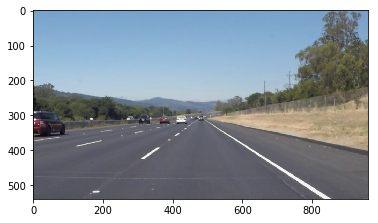

In [6]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [187]:
import math

threshold = 0.1

def load_image(source_folder, file_name):
    s = "";
    sequence = (source_folder, file_name)
    fileFullPath = s.join(sequence)
    img = mpimg.imread(fileFullPath)
    return img

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, 255)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines_old(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1) / (x2 - x1);
            if abs(slope) > 0.5:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    global avg_pos_slope
    global avg_neg_slope
    global nFrames
    
    #print('lines = ',lines)
    if lines is None:
        return;
    
    # lines is an array of <1,4> tuples
    num_line_segments = lines.shape
    slopes = [None]* num_line_segments[0]
    line_index=0
    for line in lines:
        for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            slopes[line_index] = (y2 - y1) / (x2 - x1);
        line_index+=1
    
    imshape = img.shape
    bottom_y = imshape[0] - 20
    
    
    mean_negative_slope = compute_mean_slope(slopes, 1)
    print('avg_neg_slope(before) = ', avg_neg_slope)
    print('mean_negative_slope = ', mean_negative_slope)
    print('nFrames = ',nFrames)
    if nFrames > 10:
        nFrames_used = 10
    else:
        nFrames_used = nFrames
    if ~np.isinf(mean_negative_slope) and ~np.isnan(mean_negative_slope):
        if avg_neg_slope != 0:
            avg_neg_slope = (mean_negative_slope + avg_neg_slope*nFrames_used)/(nFrames_used+1)
        else:
            avg_neg_slope = mean_negative_slope
    else:
        plt.imshow(img)
    print('avg_neg_slope = ', avg_neg_slope)
    if avg_neg_slope != 0:
        rlp1 = compute_highest_point(lines,1,avg_neg_slope)#[485, 300];
        rlp2 = compute_other_point(avg_neg_slope, rlp1, bottom_y)
        cv2.line(img, (rlp1[0], rlp1[1]), (int(rlp2[0]), int(rlp2[1])), color, 10)
        print('end-points = ', rlp1[0], rlp1[1], int(rlp2[0]), int(rlp2[1]))
    
    mean_positive_slope = compute_mean_slope(slopes, 0)
    print('avg_pos_slope(before) = ', avg_pos_slope)
    print('mean_positive_slope = ',mean_positive_slope)
    if ~np.isinf(mean_positive_slope) and ~np.isnan(mean_positive_slope):
        if avg_pos_slope != 0:
            avg_pos_slope = (mean_positive_slope + avg_pos_slope*nFrames_used)/(nFrames_used+1)
        else:
            avg_pos_slope = mean_positive_slope
    else:
        plt.imshow(img)
    print('avg_pos_slope = ', avg_pos_slope)
    if avg_pos_slope != 0:
        llp1 = compute_highest_point(lines,0,avg_pos_slope)#[485, 310];
        llp2 = compute_other_point(avg_pos_slope, llp1, bottom_y)
        cv2.line(img, (llp1[0], llp1[1]), (int(llp2[0]), int(llp2[1])), color, 10)
        print('end points = ', llp1[0], llp1[1], int(llp2[0]), int(llp2[1]))

def remove_noisy_slopes(slope_candidates):
    global threshold
    mean_slope = np.mean(slope_candidates)
    new_slope_candidates = []
    for slope in slope_candidates:
        if abs(slope - mean_slope) < threshold and abs(slope) > 0.5:
            new_slope_candidates.append(slope)
    return new_slope_candidates
    
def compute_mean_slope(slopes, is_slope_negative):
    num_line_segments = len(slopes)
    if is_slope_negative==1:
        slope_indices =  [i for i in range(num_line_segments) if slopes[i] < 0]
    else:
        slope_indices = [i for i in range(num_line_segments) if slopes[i] > 0]
    slope_candidates = [slopes[i] for i in slope_indices]
    slope_candidates = remove_noisy_slopes(slope_candidates)
    mean_slope = np.mean(slope_candidates)
    return mean_slope

def compute_highest_point(lines, is_slope_negative, mean_slope):
    global threshold
    highest_x = 0
    highest_y = 1000
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2 - y1) / (x2 - x1);
            if abs(slope - mean_slope) < threshold and abs(slope) > 0.5:
                if is_slope_negative and slope < 0:
                    if highest_y > y1:
                        highest_x = x1
                        highest_y = y1
                    if highest_y > y2:
                        highest_x = x2
                        highest_y = y2
            
            if abs(slope - mean_slope) < threshold and abs(slope) > 0.5:
                if not is_slope_negative and slope > 0:
                    if highest_y > y1:
                        highest_x = x1
                        highest_y = y1
                    if highest_y > y2:
                        highest_x = x2
                        highest_y = y2
    print('highest = ', [highest_x, highest_y])
    return [highest_x, highest_y]

def compute_other_point(slope, point, bottom_y):
    bias = point[1] - slope*point[0]
    bottom_x = (bottom_y - bias)/ slope;
    print('bottom = ',[bottom_x, bottom_y])
    return [bottom_x, bottom_y]
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [8]:
import os, sys
src_folder = "test_images/"
file_list = os.listdir(src_folder)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [83]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
i = 0
for file in file_list:
    
    img = load_image(src_folder, file)
    
    # Compute GrayScale of the  image
    gray = grayscale(img)
    
    # Compute guassian blur of the image
    kernel_size=5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Compute canny edges pf the image
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    # Create masked edge image using region of interest
    imshape = image.shape
    vertices = np.array([[(0, imshape[0]), (450, 320), (490, 320), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 60 #minimum number of pixels making up a line
    max_line_gap = 60   # maximum gap in pixels between connectable line segments
    
    # Run hough on edge detected image and draw lines on image
    line_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Create a color binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))
    
    # Draw lines on edge image
    lane_overlayed_image = weighted_img(line_image, img)
    
    
    # save image in src_folder 
    s = "";
    new_file_name = s.join((src_folder, "modified_", file))
    mpimg.imsave(new_file_name, lane_overlayed_image)
    

NameError: name 'file_list' is not defined

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

In [182]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # Compute GrayScale of the  image
    global nFrames
    
    nFrames = nFrames + 1
    
    gray = grayscale(image)
    
    # Compute guassian blur of the image
    kernel_size=5
    blur_gray = gaussian_blur(gray, kernel_size)
    
    # Compute canny edges pf the image
    low_threshold = 40
    high_threshold = 120
    edges = canny(blur_gray, low_threshold, high_threshold)
    
   # Create masked edge image using region of interest
    imshape = image.shape
    vertices = np.array([[(50, imshape[0]-20), (imshape[1]/2-10, imshape[0]/2+40), (imshape[1]/2 + 10, imshape[0]/2+40), (imshape[1]-50, imshape[0]-20)]], dtype=np.int32)
    #vertices = np.array([[(0, imshape[0]), (480, 310), (490, 310), (imshape[1], imshape[0])]], dtype=np.int32)
    masked_image = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 10     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100 #minimum number of pixels making up a line
    max_line_gap = 150   # maximum gap in pixels between connectable line segments
    # Run hough on edge detected image and draw lines on image
    line_image = hough_lines(masked_image, rho, theta, threshold, min_line_length, max_line_gap)
    
    #plt.imshow(line_image)
    # Create a color binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges))
    
    # Draw lines on edge image
    lane_overlayed_image = weighted_img(line_image, image)
    
    
    # save image in src_folder 
    #s = "";
    #new_file_name = s.join((src_folder, "modified_", file))
    #mpimg.imsave(new_file_name, lane_overlayed_image)
    plt.imshow(lane_overlayed_image)
    return lane_overlayed_image

Let's try the one with the solid white lane on the right first ...

(540, 960, 3)
avg_neg_slope(before) =  0
mean_negative_slope =  -0.744302139485
nFrames =  1
avg_neg_slope =  -0.744302139485
highest =  [461, 319]
bottom =  [204.38378211287031, 510]
end-points =  461 319 204 510
avg_pos_slope(before) =  0
mean_positive_slope =  0.616812687927
avg_pos_slope =  0.616812687927
highest =  [487, 310]
bottom =  [811.24754534839076, 510]
end points =  487 310 811 510
[MoviePy] >>>> Building video test_videos/modified_solidWhiteRight.mp4
[MoviePy] Writing video test_videos/modified_solidWhiteRight.mp4


  0%|          | 0/222 [00:00<?, ?it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.744302139485
mean_negative_slope =  -0.744302139485
nFrames =  2
avg_neg_slope =  -0.744302139485
highest =  [461, 319]
bottom =  [204.38378211287031, 510]
end-points =  461 319 204 510
avg_pos_slope(before) =  0.616812687927
mean_positive_slope =  0.616812687927
avg_pos_slope =  0.616812687927
highest =  [487, 310]
bottom =  [811.24754534839076, 510]
end points =  487 310 811 510


  1%|          | 2/222 [00:00<00:12, 17.39it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.744302139485
mean_negative_slope =  -0.742375817274
nFrames =  3
avg_neg_slope =  -0.743820558932
highest =  [463, 318]
bottom =  [204.87322776400967, 510]
end-points =  463 318 204 510
avg_pos_slope(before) =  0.616812687927
mean_positive_slope =  0.596197557369
avg_pos_slope =  0.611658905287
highest =  [490, 310]
bottom =  [816.97962585219761, 510]
end points =  490 310 816 510
(540, 960, 3)
avg_neg_slope(before) =  -0.743820558932
mean_negative_slope =  -0.73506605904
nFrames =  4
avg_neg_slope =  -0.742069658954
highest =  [463, 318]
bottom =  [204.26418229973831, 510]
end-points =  463 318 204 510
avg_pos_slope(before) =  0.611658905287
mean_positive_slope =  0.628243224522
avg_pos_slope =  0.614975769134
highest =  [482, 310]
bottom =  [807.21606547451347, 510]
end points =  482 310 807 510
(540, 960, 3)
avg_neg_slope(before) =  -0.742069658954
mean_negative_slope =  -0.740688108421
nFrames =  5
avg_neg_slope =  -0.741839400532
highest =

  2%|▏         | 5/222 [00:00<00:17, 12.55it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.741839400532
mean_negative_slope =  -0.726188406816
nFrames =  6
avg_neg_slope =  -0.739603544287
highest =  [463, 318]
bottom =  [203.40146037269261, 510]
end-points =  463 318 203 510
avg_pos_slope(before) =  0.616183282347
mean_positive_slope =  0.613847862488
avg_pos_slope =  0.615849650939
highest =  [491, 310]
bottom =  [815.75458855116756, 510]
end points =  491 310 815 510
(540, 960, 3)
avg_neg_slope(before) =  -0.739603544287
mean_negative_slope =  -0.710772869062
nFrames =  7
avg_neg_slope =  -0.735999709884
highest =  [467, 316]
bottom =  [203.41293957753373, 510]
end-points =  467 316 203 510
avg_pos_slope(before) =  0.615849650939
mean_positive_slope =  0.610510567387
avg_pos_slope =  0.615182265495
highest =  [491, 310]
bottom =  [816.10690118663558, 510]
end points =  491 310 816 510
(540, 960, 3)


  3%|▎         | 7/222 [00:00<00:17, 12.07it/s]

avg_neg_slope(before) =  -0.735999709884
mean_negative_slope =  -0.711430591589
nFrames =  8
avg_neg_slope =  -0.733269807851
highest =  [467, 316]
bottom =  [202.43162704515171, 510]
end-points =  467 316 202 510
avg_pos_slope(before) =  0.615182265495
mean_positive_slope =  0.605670828063
avg_pos_slope =  0.614125439114
highest =  [491, 310]
bottom =  [816.66636596050648, 510]
end points =  491 310 816 510
(540, 960, 3)
avg_neg_slope(before) =  -0.733269807851
mean_negative_slope =  -0.714707195105
nFrames =  9
avg_neg_slope =  -0.731413546576
highest =  [465, 317]
bottom =  [201.12739208420041, 510]
end-points =  465 317 201 510
avg_pos_slope(before) =  0.614125439114
mean_positive_slope =  0.61107688355
avg_pos_slope =  0.613820583557
highest =  [491, 310]
bottom =  [816.82810899072649, 510]
end points =  491 310 816 510
(540, 960, 3)
avg_neg_slope(before) = 

  5%|▌         | 12/222 [00:01<00:30,  6.98it/s]

 -0.731413546576
mean_negative_slope =  -0.709855078418
nFrames =  10
avg_neg_slope =  -0.729453685835
highest =  [465, 317]
bottom =  [200.41843197459994, 510]
end-points =  465 317 200 510
avg_pos_slope(before) =  0.613820583557
mean_positive_slope =  0.61942651119
avg_pos_slope =  0.614330213342
highest =  [491, 310]
bottom =  [816.55781183544218, 510]
end points =  491 310 816 510
(540, 960, 3)
avg_neg_slope(before) =  -0.729453685835
mean_negative_slope =  -0.710550872845
nFrames =  11
avg_neg_slope =  -0.72773524829
highest =  [474, 313]
bottom =  [203.29715791161271, 510]
end-points =  474 313 203 510
avg_pos_slope(before) =  0.614330213342
mean_positive_slope =  0.610541786532
avg_pos_slope =  0.613985810905
highest =  [483, 310]
bottom =  [808.74042664817159, 510]
end points =  483 310 808 510
(540, 960, 3)
avg_neg_slope(before) =  -0.72773524829
mean_negative_slope =  -0.714180593007
nFrames =  12
avg_neg_slope =  -0.726503006901
highest =  [478, 312]
bottom =  [205.461554708

  7%|▋         | 15/222 [00:01<00:23,  8.76it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.724183889219
mean_negative_slope =  -0.716379923077
nFrames =  15
avg_neg_slope =  -0.723474437752
highest =  [473, 313]
bottom =  [200.70288800778511, 510]
end-points =  473 313 200 510
avg_pos_slope(before) =  0.618390424534
mean_positive_slope =  0.640564185142
avg_pos_slope =  0.620406220953
highest =  [485, 310]
bottom =  [807.36943029493398, 510]
end points =  485 310 807 510
(540, 960, 3)
avg_neg_slope(before) =  -0.723474437752
mean_negative_slope =  -0.704189566726
nFrames =  16
avg_neg_slope =  -0.721721267659
highest =  [463, 318]
bottom =  [196.96931945360487, 510]
end-points =  463 318 196 510
avg_pos_slope(before) =  0.620406220953
mean_positive_slope =  0.635163998938
avg_pos_slope =  0.621747837133
highest =  [487, 310]
bottom =  [808.67381702868499, 510]
end points =  487 310 808 510
(540, 960, 3)
avg_neg_slope(before) =  -0.721721267659
mean_negative_slope =  -0.714896905343
nFrames =  17
avg_neg_slope =  -0.721100871084
highe

  9%|▉         | 21/222 [00:01<00:15, 12.63it/s]

510
avg_pos_slope(before) =  0.625572019102
mean_positive_slope =  0.653412544768
avg_pos_slope =  0.62810297598
highest =  [491, 311]
bottom =  [807.82702934089195, 510]
end points =  491 311 807 510
(540, 960, 3)
avg_neg_slope(before) =  -0.716217999186
mean_negative_slope =  -0.687092373053
nFrames =  20
avg_neg_slope =  -0.713570214992
highest =  [476, 313]
bottom =  [199.92345439724303, 510]
end-points =  476 313 199 510
avg_pos_slope(before) =  0.62810297598
mean_positive_slope =  0.654854393678
avg_pos_slope =  0.630534923044
highest =  [491, 312]
bottom =  [805.01908564274629, 510]
end points =  491 312 805 510
(540, 960, 3)
avg_neg_slope(before) =  -0.713570214992
mean_negative_slope =  -0.708834287945
nFrames =  21
avg_neg_slope =  -0.71313967617
highest =  [471, 314]
bottom =  [196.15903048227088, 510]
end-points =  471 314 196 510
avg_pos_slope(before) =  0.630534923044
mean_positive_slope =  0.642407556273
avg_pos_slope =  0.631614253337
highest =  [484, 310]
bottom =  [80

 12%|█▏        | 26/222 [00:02<00:12, 15.38it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.710593653223
mean_negative_slope =  -0.699944328822
nFrames =  25
avg_neg_slope =  -0.709625532823
highest =  [479, 310]
bottom =  [197.16121214742839, 510]
end-points =  479 310 197 510
avg_pos_slope(before) =  0.633818134765
mean_positive_slope =  0.644964099377
avg_pos_slope =  0.634831404276
highest =  [486, 310]
bottom =  [801.04427577619879, 510]
end points =  486 310 801 510
(540, 960, 3)
avg_neg_slope(before) =  -0.709625532823
mean_negative_slope =  -0.711752008929
nFrames =  26
avg_neg_slope =  -0.709818848832
highest =  [475, 312]
bottom =  [196.05558999216152, 510]
end-points =  475 312 196 510
avg_pos_slope(before) =  0.634831404276
mean_positive_slope =  0.639582985211
avg_pos_slope =  0.635263366179
highest =  [485, 310]
bottom =  [799.83005419157291, 510]
end points =  485 310 799 510
(540, 960, 3)
avg_neg_slope(before) =  -0.709818848832
mean_negative_slope =  -0.691298887565
nFrames =  27
avg_neg_slope =  -0.70813521599
highes

 14%|█▍        | 31/222 [00:02<00:11, 17.22it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709081099865
mean_negative_slope =  -0.723247618735
nFrames =  29
avg_neg_slope =  -0.710368965217
highest =  [481, 310]
bottom =  [199.45616884614475, 510]
end-points =  481 310 199 510
avg_pos_slope(before) =  0.635963175409
mean_positive_slope =  0.637503846059
avg_pos_slope =  0.636103236377
highest =  [485, 310]
bottom =  [799.41437264049, 510]
end points =  485 310 799 510
(540, 960, 3)
avg_neg_slope(before) =  -0.710368965217
mean_negative_slope =  -0.70942187997
nFrames =  30
avg_neg_slope =  -0.710282866558
highest =  [479, 310]
bottom =  [197.42204082843347, 510]
end-points =  479 310 197 510
avg_pos_slope(before) =  0.636103236377
mean_positive_slope =  0.636312798624
avg_pos_slope =  0.63612228749
highest =  [485, 310]
bottom =  [799.40495630031194, 510]
end points =  485 310 799 510
(540, 960, 3)
avg_neg_slope(before) =  -0.710282866558
mean_negative_slope =  -0.721703958361
nFrames =  31
avg_neg_slope =  -0.711321147631
highest = 

 16%|█▌        | 35/222 [00:02<00:10, 18.41it/s]

 -0.710674997104
mean_negative_slope =  -0.703394079231
nFrames =  33
avg_neg_slope =  -0.710013095479
highest =  [475, 313]
bottom =  [197.54032882714444, 510]
end-points =  475 313 197 510
avg_pos_slope(before) =  0.636668441796
mean_positive_slope =  0.638674348136
avg_pos_slope =  0.636850796918
highest =  [488, 310]
bottom =  [802.04530066995255, 510]
end points =  488 310 802 510
(540, 960, 3)
avg_neg_slope(before) =  -0.710013095479
mean_negative_slope =  -0.731070528862
nFrames =  34
avg_neg_slope =  -0.711927407605
highest =  [459, 320]
bottom =  [192.11885738564621, 510]
end-points =  459 320 192 510
avg_pos_slope(before) =  0.636850796918
mean_positive_slope =  0.631930366618
avg_pos_slope =  0.636403485073
highest =  [489, 310]
bottom =  [803.26603513525777, 510]
end points =  489 310 803 510
(540, 960, 3)
avg_neg_slope(before) =  -0.711927407605
mean_negative_slope =  -0.695765229503
nFrames =  35
avg_neg_slope =  -0.710458118686
highest =  [480, 313]
bottom =  [202.714126

 18%|█▊        | 40/222 [00:02<00:09, 19.66it/s]

[197.19473274451582, 510]
end-points =  479 310 197 510
avg_pos_slope(before) =  0.636585523778
mean_positive_slope =  0.639480871313
avg_pos_slope =  0.63684873719
highest =  [485, 310]
bottom =  [799.0463163708381, 510]
end points =  485 310 799 510
(540, 960, 3)
avg_neg_slope(before) =  -0.709709942429
mean_negative_slope =  -0.712270943871
nFrames =  38
avg_neg_slope =  -0.709942760742
highest =  [477, 311]
bottom =  [196.6957120992376, 510]
end-points =  477 311 196 510
avg_pos_slope(before) =  0.63684873719
mean_positive_slope =  0.634481181094
avg_pos_slope =  0.636633504818
highest =  [486, 310]
bottom =  [800.15248881260538, 510]
end points =  486 310 800 510
(540, 960, 3)
avg_neg_slope(before) =  -0.709942760742
mean_negative_slope =  -0.716789432373
nFrames =  39
avg_neg_slope =  -0.710565185435
highest =  [480, 310]
bottom =  [198.53391624100149, 510]
end-points =  480 310 198 510
avg_pos_slope(before) =  0.636633504818
mean_positive_slope =  0.636708887903
avg_pos_slope = 

 19%|█▉        | 43/222 [00:03<00:08, 20.24it/s]

 [490, 310]
bottom =  [803.81080922813339, 510]
end points =  490 310 803 510
(540, 960, 3)
avg_neg_slope(before) =  -0.711853558126
mean_negative_slope =  -0.730082144271
nFrames =  43
avg_neg_slope =  -0.713510702321
highest =  [465, 317]
bottom =  [194.50651003236186, 510]
end-points =  465 317 194 510
avg_pos_slope(before) =  0.637326676197
mean_positive_slope =  0.6385051139
avg_pos_slope =  0.637433806897
highest =  [490, 310]
bottom =  [803.75806842369218, 510]
end points =  490 310 803 510
(540, 960, 3)
avg_neg_slope(before) =  -0.713510702321
mean_negative_slope =  -0.724185772087
nFrames =  44
avg_neg_slope =  -0.714481163209
highest =  [463, 318]
bottom =  [194.27353121843487, 510]
end-points =  463 318 194 510
avg_pos_slope(before) =  0.637433806897
mean_positive_slope =  0.673558655006
avg_pos_slope =  0.640717883998
highest =  [490, 310]
bottom =  [802.14986345011107, 510]
end points =  490 310 802 510
(540, 960, 3)
avg_neg_slope(before) =  -0.714481163209
mean_negative_s

 22%|██▏       | 49/222 [00:03<00:09, 18.47it/s]

bottom =  [799.85056637736363, 510]
end points =  489 310 799 510
(540, 960, 3)
avg_neg_slope(before) =  -0.718199018602
mean_negative_slope =  -0.740597375486
nFrames =  48
avg_neg_slope =  -0.720235232865
highest =  [446, 326]
bottom =  [190.52791032147454, 510]
end-points =  446 326 190 510
avg_pos_slope(before) =  0.643395964597
mean_positive_slope =  0.641949392643
avg_pos_slope =  0.643264458056
highest =  [489, 310]
bottom =  [799.91411548589485, 510]
end points =  489 310 799 510
(540, 960, 3)
avg_neg_slope(before) =  -0.720235232865
mean_negative_slope =  -0.704484886224
nFrames =  49
avg_neg_slope =  -0.71880338317
highest =  [454, 324]
bottom =  [195.23661023999665, 510]
end-points =  454 324 195 510
avg_pos_slope(before) =  0.643264458056
mean_positive_slope =  0.653643657817
avg_pos_slope =  0.644208021671
highest =  [493, 312]
bottom =  [800.35413614771323, 510]
end points =  493 312 800 510
(540, 960, 3)
avg_neg_slope(before) =  -0.71880338317
mean_negative_slope =  -0.7

 23%|██▎       | 51/222 [00:03<00:10, 15.89it/s]

avg_neg_slope(before) =  -0.719424708659
mean_negative_slope =  -0.707258426904
nFrames =  51
avg_neg_slope =  -0.718318683045
highest =  [465, 317]
bottom =  [196.31702605617909, 510]
end-points =  465 317 196 510
avg_pos_slope(before) =  0.644815617567
mean_positive_slope =  0.654625574597
avg_pos_slope =  0.645707431842
highest =  [495, 314]
bottom =  [798.54304493715722, 510]
end points =  495 314 798 510
(540, 960, 3)
avg_neg_slope(before) =  -0.718318683045
mean_negative_slope =  -0.717550935072
nFrames =  52
avg_neg_slope =  -0.718248887775
highest =  [457, 321]
bottom =  [193.8600171654756, 510]
end-points =  457 321 193 510
avg_pos_slope(before) =  0.645707431842
mean_positive_slope =  0.645246530534
avg_pos_slope =  0.645665531723
highest =  [488, 310]
bottom =  [797.75790122501746, 510]
end points =  488 310 797 510
(540, 960, 3)
avg_neg_slope(before) =  -0.718248887775
mean_negative_slope =  -0.70627711917
nFrames =  53
avg_neg_slope =  -0.717160545174
highest =  [455, 322]

 25%|██▍       | 55/222 [00:03<00:09, 16.95it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.716521453963
mean_negative_slope =  -0.692667506801
nFrames =  55
avg_neg_slope =  -0.714352913312
highest =  [461, 319]
bottom =  [193.62515426097883, 510]
end-points =  461 319 193 510
avg_pos_slope(before) =  0.645522179943
mean_positive_slope =  0.645590993022
avg_pos_slope =  0.645528435678
highest =  [491, 310]
bottom =  [800.82368699224719, 510]
end points =  491 310 800 510
(540, 960, 3)
avg_neg_slope(before) =  -0.714352913312
mean_negative_slope =  -0.674132682613
nFrames =  56
avg_neg_slope =  -0.710696528703
highest =  [465, 317]
bottom =  [193.43542608510944, 510]
end-points =  465 317 193 510
avg_pos_slope(before) =  0.645528435678
mean_positive_slope =  0.649185187034
avg_pos_slope =  0.645860867619
highest =  [487, 310]
bottom =  [796.6642172133154, 510]
end points =  487 310 796 510
(540, 960, 3)
avg_neg_slope(before) =  -0.710696528703
mean_negative_slope =  -0.685907021268
nFrames =  57
avg_neg_slope =  -0.708442937118
highes

 27%|██▋       | 59/222 [00:04<00:09, 16.98it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.706658022213
mean_negative_slope =  -0.689426687519
nFrames =  59
avg_neg_slope =  -0.705091537241
highest =  [477, 312]
bottom =  [196.18539715449748, 510]
end-points =  477 312 196 510
avg_pos_slope(before) =  0.645148972784
mean_positive_slope =  0.650658323369
avg_pos_slope =  0.645649822837
highest =  [490, 311]
bottom =  [798.21661055448442, 510]
end points =  490 311 798 510
(540, 960, 3)
avg_neg_slope(before) =  -0.705091537241
mean_negative_slope =  -0.670748626374
nFrames =  60
avg_neg_slope =  -0.701969454435
highest =  [463, 319]
bottom =  [190.90838861526345, 510]
end-points =  463 319 190 510
avg_pos_slope(before) =  0.645649822837
mean_positive_slope =  0.647369914348
avg_pos_slope =  0.645806194793
highest =  [484, 311]
bottom =  [792.14198068177768, 510]
end points =  484 311 792 510
(540, 960, 3)
avg_neg_slope(before) =  -0.701969454435
mean_negative_slope =  -0.686750464169
nFrames =  61
avg_neg_slope =  -0.700585909865
highe

 28%|██▊       | 63/222 [00:04<00:09, 17.63it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.700940243225
mean_negative_slope =  -0.685574616225
nFrames =  63
avg_neg_slope =  -0.699543368043
highest =  [463, 319]
bottom =  [189.96474768337933, 510]
end-points =  463 319 189 510
avg_pos_slope(before) =  0.647344151135
mean_positive_slope =  0.657596599372
avg_pos_slope =  0.648276191884
highest =  [491, 312]
bottom =  [796.42537652743806, 510]
end points =  491 312 796 510
(540, 960, 3)
avg_neg_slope(before) =  -0.699543368043
mean_negative_slope =  -0.686924319208
nFrames =  64
avg_neg_slope =  -0.698396181785
highest =  [475, 312]
bottom =  [191.49329540449568, 510]
end-points =  475 312 191 510
avg_pos_slope(before) =  0.648276191884
mean_positive_slope =  0.657456126148
avg_pos_slope =  0.649110731363
highest =  [483, 311]
bottom =  [789.57327076110982, 510]
end points =  483 311 789 510
(540, 960, 3)
avg_neg_slope(before) =  -0.698396181785
mean_negative_slope =  -0.690510806643
nFrames =  65
avg_neg_slope =  -0.6976793295
highest

 31%|███       | 69/222 [00:04<00:08, 17.65it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.69506680109
mean_negative_slope =  -0.649583114566
nFrames =  67
avg_neg_slope =  -0.690931920497
highest =  [477, 311]
bottom =  [188.98320109905728, 510]
end-points =  477 311 188 510
avg_pos_slope(before) =  0.650748668224
mean_positive_slope =  0.65807623314
avg_pos_slope =  0.651414810489
highest =  [481, 310]
bottom =  [788.02402951184183, 510]
end points =  481 310 788 510
(540, 960, 3)
avg_neg_slope(before) =  -0.690931920497
mean_negative_slope =  -0.677679281489
nFrames =  68
avg_neg_slope =  -0.689727135133
highest =  [465, 317]
bottom =  [185.17919816521317, 510]
end-points =  465 317 185 510
avg_pos_slope(before) =  0.651414810489
mean_positive_slope =  0.65562831358
avg_pos_slope =  0.651797856224
highest =  [485, 310]
bottom =  [791.84359896257172, 510]
end points =  485 310 791 510
(540, 960, 3)
avg_neg_slope(before) =  -0.689727135133
mean_negative_slope =  -0.676362345657
nFrames =  69
avg_neg_slope =  -0.688512154271
highest 

 32%|███▏      | 71/222 [00:04<00:08, 17.23it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.688132804247
mean_negative_slope =  -0.665516310666
nFrames =  71
avg_neg_slope =  -0.686076759376
highest =  [469, 315]
bottom =  [184.7752433161956, 510]
end-points =  469 315 184 510
avg_pos_slope(before) =  0.652645886538
mean_positive_slope =  0.6556730127
avg_pos_slope =  0.652921079825
highest =  [482, 310]
bottom =  [788.31573428976037, 510]
end points =  482 310 788 510
(540, 960, 3)
avg_neg_slope(before) =  -0.686076759376
mean_negative_slope =  -0.68700540246
nFrames =  72
avg_neg_slope =  -0.686161181474
highest =  [461, 319]
bottom =  [182.63974710782128, 510]
end-points =  461 319 182 510
avg_pos_slope(before) =  0.652921079825
mean_positive_slope =  0.657045953549
avg_pos_slope =  0.653296068346
highest =  [484, 310]
bottom =  [790.13991066321466, 510]
end points =  484 310 790 510
(540, 960, 3)
avg_neg_slope(before) =  -0.686161181474
mean_negative_slope =  -0.683261972622
nFrames =  73
avg_neg_slope =  -0.685897617033
highest =

 34%|███▍      | 75/222 [00:04<00:08, 16.42it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.685600001615
mean_negative_slope =  -0.657336545465
nFrames =  75
avg_neg_slope =  -0.683030596511
highest =  [469, 315]
bottom =  [183.50766481600607, 510]
end-points =  469 315 183 510
avg_pos_slope(before) =  0.654105721657
mean_positive_slope =  0.660878321305
avg_pos_slope =  0.654721412534
highest =  [482, 310]
bottom =  [787.47343674916488, 510]
end points =  482 310 787 510
(540, 960, 3)
avg_neg_slope(before) =  -0.683030596511
mean_negative_slope =  -0.655399520324
nFrames =  76
avg_neg_slope =  -0.680518680494
highest =  [479, 310]
bottom =  [185.1065247248529, 510]
end-points =  479 310 185 510
avg_pos_slope(before) =  0.654721412534
mean_positive_slope =  0.660712579274
avg_pos_slope =  0.655266064056
highest =  [483, 310]
bottom =  [788.21952985342148, 510]
end points =  483 310 788 510
(540, 960, 3)
avg_neg_slope(before) =  -0.680518680494
mean_negative_slope =  -0.666880549447
nFrames =  77
avg_neg_slope =  -0.679278850399
highes

 36%|███▌      | 79/222 [00:05<00:08, 16.16it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.679278850399
mean_negative_slope =  -0.6625601633
nFrames =  78
avg_neg_slope =  -0.677758969753
highest =  [459, 320]
bottom =  [178.66435196107599, 510]
end-points =  459 320 178 510
avg_pos_slope(before) =  0.656148410602
mean_positive_slope =  0.659279913215
avg_pos_slope =  0.656433092658
highest =  [485, 310]
bottom =  [789.67690041387925, 510]
end points =  485 310 789 510
(540, 960, 3)
avg_neg_slope(before) =  -0.677758969753
mean_negative_slope =  -0.687537188617
nFrames =  79
avg_neg_slope =  -0.678647898741
highest =  [455, 322]
bottom =  [177.97858676233082, 510]
end-points =  455 322 177 510
avg_pos_slope(before) =  0.656433092658
mean_positive_slope =  0.681078874301
avg_pos_slope =  0.658673618261
highest =  [490, 313]
bottom =  [789.08591226101646, 510]
end points =  490 313 789 510
(540, 960, 3)
avg_neg_slope(before) =  -0.678647898741
mean_negative_slope =  -0.663245592181
nFrames =  80
avg_neg_slope =  -0.677247689054
highest

 37%|███▋      | 83/222 [00:05<00:08, 16.58it/s]

 [457, 321]
bottom =  [177.30954532687772, 510]
end-points =  457 321 177 510
avg_pos_slope(before) =  0.659771142302
mean_positive_slope =  0.69058281137
avg_pos_slope =  0.662572203126
highest =  [491, 310]
bottom =  [792.85389464938555, 510]
end points =  491 310 792 510
(540, 960, 3)
avg_neg_slope(before) =  -0.675747051221
mean_negative_slope =  -0.693827966084
nFrames =  82
avg_neg_slope =  -0.677390770754
highest =  [456, 321]
bottom =  [176.98822694375681, 510]
end-points =  456 321 176 510
avg_pos_slope(before) =  0.662572203126
mean_positive_slope =  0.679911621
avg_pos_slope =  0.664148513842
highest =  [485, 310]
bottom =  [786.13746523814473, 510]
end points =  485 310 786 510
(540, 960, 3)
avg_neg_slope(before) =  -0.677390770754
mean_negative_slope =  -0.662588734036
nFrames =  83
avg_neg_slope =  -0.676045131052
highest =  [456, 321]
bottom =  [176.4328656197965, 510]
end-points =  456 321 176 510
avg_pos_slope(before) =  0.664148513842
mean_positive_slope =  0.68197537

 39%|███▉      | 87/222 [00:05<00:08, 16.80it/s]

[176.82638656412783, 510]
end-points =  459 320 176 510
avg_pos_slope(before) =  0.667694426259
mean_positive_slope =  0.678859990588
avg_pos_slope =  0.668709477562
highest =  [484, 310]
bottom =  [783.08354331877604, 510]
end points =  484 310 783 510
(540, 960, 3)
avg_neg_slope(before) =  -0.673344320493
mean_negative_slope =  -0.660980579383
nFrames =  86
avg_neg_slope =  -0.672220344028
highest =  [459, 320]
bottom =  [176.35458218745106, 510]
end-points =  459 320 176 510
avg_pos_slope(before) =  0.668709477562
mean_positive_slope =  0.681949423352
avg_pos_slope =  0.669913108997
highest =  [485, 310]
bottom =  [783.54618056270192, 510]
end points =  485 310 783 510
(540, 960, 3)
avg_neg_slope(before) =  -0.672220344028
mean_negative_slope =  -0.664636506496
nFrames =  87
avg_neg_slope =  -0.671530904253
highest =  [463, 318]
bottom =  [177.08612949294255, 510]
end-points =  463 318 177 510
avg_pos_slope(before) =  0.669913108997
mean_positive_slope =  0.681916462765
avg_pos_slop

 41%|████      | 91/222 [00:05<00:07, 17.68it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.66889174585
mean_negative_slope =  -0.654363074685
nFrames =  90
avg_neg_slope =  -0.667570957562
highest =  [482, 311]
bottom =  [183.90434777633251, 510]
end-points =  482 311 183 510
avg_pos_slope(before) =  0.671834429987
mean_positive_slope =  0.681960987036
avg_pos_slope =  0.672755026083
highest =  [483, 310]
bottom =  [780.28503280690109, 510]
end points =  483 310 780 510
(540, 960, 3)
avg_neg_slope(before) =  -0.667570957562
mean_negative_slope =  -0.661364777471
nFrames =  91
avg_neg_slope =  -0.667006759372
highest =  [467, 316]
bottom =  [176.14837477405123, 510]
end-points =  467 316 176 510
avg_pos_slope(before) =  0.672755026083
mean_positive_slope =  0.655358566512
avg_pos_slope =  0.671173529758
highest =  [483, 310]
bottom =  [780.98553001946414, 510]
end points =  483 310 780 510
(540, 960, 3)
avg_neg_slope(before) =  -0.667006759372
mean_negative_slope =  -0.660433816432
nFrames =  92
avg_neg_slope =  -0.666409219105
highes

 43%|████▎     | 95/222 [00:06<00:07, 18.09it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.666233381204
mean_negative_slope =  -0.647701695354
nFrames =  94
avg_neg_slope =  -0.66454868249
highest =  [482, 311]
bottom =  [182.54865016918714, 510]
end-points =  482 311 182 510
avg_pos_slope(before) =  0.675807493602
mean_positive_slope =  0.708363794806
avg_pos_slope =  0.678767157348
highest =  [491, 311]
bottom =  [784.17859275571868, 510]
end points =  491 311 784 510
(540, 960, 3)
avg_neg_slope(before) =  -0.66454868249
mean_negative_slope =  -0.659512815473
nFrames =  95
avg_neg_slope =  -0.664090876398
highest =  [477, 311]
bottom =  [177.34221659625643, 510]
end-points =  477 311 177 510
avg_pos_slope(before) =  0.678767157348
mean_positive_slope =  0.69071274833
avg_pos_slope =  0.679853120164
highest =  [485, 310]
bottom =  [779.18119012482987, 510]
end points =  485 310 779 510
(540, 960, 3)
avg_neg_slope(before) =  -0.664090876398
mean_negative_slope =  -0.657424894652
nFrames =  96
avg_neg_slope =  -0.663484878057
highest 

 45%|████▍     | 99/222 [00:06<00:07, 17.02it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.663642824271
mean_negative_slope =  -0.663165414966
nFrames =  98
avg_neg_slope =  -0.663599423425
highest =  [467, 316]
bottom =  [174.65495997749696, 510]
end-points =  467 316 174 510
avg_pos_slope(before) =  0.684801342616
mean_positive_slope =  0.693269086165
avg_pos_slope =  0.685571137484
highest =  [497, 314]
bottom =  [782.89301574058049, 510]
end points =  497 314 782 510
(540, 960, 3)
avg_neg_slope(before) =  -0.663599423425
mean_negative_slope =  -0.661116149383
nFrames =  99
avg_neg_slope =  -0.663373671239
highest =  [471, 314]
bottom =  [175.54058022245894, 510]
end-points =  471 314 175 510
avg_pos_slope(before) =  0.685571137484
mean_positive_slope =  0.708526447313
avg_pos_slope =  0.687657983832
highest =  [503, 317]
bottom =  [783.66277791827088, 510]
end points =  503 317 783 510
(540, 960, 3)
avg_neg_slope(before) =  -0.663373671239
mean_negative_slope =  -0.660031562577
nFrames =  100
avg_neg_slope =  -0.663069843179
high

 46%|████▋     | 103/222 [00:06<00:06, 17.45it/s]

[476, 312]
bottom =  [176.97228786041336, 510]
end-points =  476 312 176 510
avg_pos_slope(before) =  0.688702880596
mean_positive_slope =  0.708478144359
avg_pos_slope =  0.690500631847
highest =  [506, 318]
bottom =  [784.05912282285112, 510]
end points =  506 318 784 510
(540, 960, 3)
avg_neg_slope(before) =  -0.662145988354
mean_negative_slope =  -0.667638653928
nFrames =  102
avg_neg_slope =  -0.662645321588
highest =  [471, 314]
bottom =  [175.2158246432524, 510]
end-points =  471 314 175 510
avg_pos_slope(before) =  0.690500631847
mean_positive_slope =  0.686667149378
avg_pos_slope =  0.690152133441
highest =  [501, 317]
bottom =  [780.648487120955, 510]
end points =  501 317 780 510
(540, 960, 3)
avg_neg_slope(before) =  -0.662645321588
mean_negative_slope =  -0.649584784048
nFrames =  103
avg_neg_slope =  -0.661457999994
highest =  [483, 310]
bottom =  [180.6376429011197, 510]
end-points =  483 310 180 510
avg_pos_slope(before) =  0.690152133441
mean_positive_slope =  0.712128

 48%|████▊     | 107/222 [00:06<00:06, 17.71it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.664504339204
mean_negative_slope =  -0.693283207738
nFrames =  106
avg_neg_slope =  -0.66712059998
highest =  [480, 310]
bottom =  [180.20413099805893, 510]
end-points =  480 310 180 510
avg_pos_slope(before) =  0.69118036989
mean_positive_slope =  0.688830160549
avg_pos_slope =  0.690966714495
highest =  [493, 311]
bottom =  [781.00229566104713, 510]
end points =  493 311 781 510
(540, 960, 3)
avg_neg_slope(before) =  -0.66712059998
mean_negative_slope =  -0.685044235715
nFrames =  107
avg_neg_slope =  -0.66875002141
highest =  [473, 314]
bottom =  [179.91589723362463, 510]
end-points =  473 314 179 510
avg_pos_slope(before) =  0.690966714495
mean_positive_slope =  0.693603611868
avg_pos_slope =  0.691206432438
highest =  [487, 310]
bottom =  [776.34915911374492, 510]
end points =  487 310 776 510
(540, 960, 3)
avg_neg_slope(before) =  -0.66875002141
mean_negative_slope =  -0.690422247963
nFrames =  108
avg_neg_slope =  -0.670720223824
highest

 50%|█████     | 111/222 [00:07<00:06, 17.72it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.671515896297
mean_negative_slope =  -0.657556081762
nFrames =  110
avg_neg_slope =  -0.670246822249
highest =  [479, 310]
bottom =  [180.60246440400456, 510]
end-points =  479 310 180 510
avg_pos_slope(before) =  0.690143025851
mean_positive_slope =  0.690392977663
avg_pos_slope =  0.690165748743
highest =  [493, 311]
bottom =  [781.33653417657467, 510]
end points =  493 311 781 510
(540, 960, 3)
avg_neg_slope(before) =  -0.670246822249
mean_negative_slope =  -0.689203347066
nFrames =  111
avg_neg_slope =  -0.671970142686
highest =  [471, 315]
bottom =  [180.80853521198469, 510]
end-points =  471 315 180 510
avg_pos_slope(before) =  0.690165748743
mean_positive_slope =  0.692360666964
avg_pos_slope =  0.690365286763
highest =  [493, 311]
bottom =  [781.25319554086593, 510]
end points =  493 311 781 510
(540, 960, 3)
avg_neg_slope(before) =  -0.671970142686
mean_negative_slope =  -0.680211987942
nFrames =  112
avg_neg_slope =  -0.672719401346
hi

 52%|█████▏    | 115/222 [00:07<00:05, 18.07it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.673594095054
mean_negative_slope =  -0.672336757946
nFrames =  114
avg_neg_slope =  -0.673479791681
highest =  [480, 310]
bottom =  [183.03489062261869, 510]
end-points =  480 310 183 510
avg_pos_slope(before) =  0.689640457819
mean_positive_slope =  0.681337940799
avg_pos_slope =  0.688885683544
highest =  [497, 313]
bottom =  [782.96907252668416, 510]
end points =  497 313 782 510
(540, 960, 3)
avg_neg_slope(before) =  -0.673479791681
mean_negative_slope =  -0.66702213655
nFrames =  115
avg_neg_slope =  -0.672892732124
highest =  [480, 310]
bottom =  [182.77580593149995, 510]
end-points =  480 310 182 510
avg_pos_slope(before) =  0.688885683544
mean_positive_slope =  0.668397230265
avg_pos_slope =  0.687023096882
highest =  [492, 312]
bottom =  [780.19991772987498, 510]
end points =  492 312 780 510
(540, 960, 3)
avg_neg_slope(before) =  -0.672892732124
mean_negative_slope =  -0.653423766259
nFrames =  116
avg_neg_slope =  -0.671122826136
hig

 54%|█████▎    | 119/222 [00:07<00:05, 17.77it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.670305288226
mean_negative_slope =  -0.660152941067
nFrames =  118
avg_neg_slope =  -0.669382347575
highest =  [479, 310]
bottom =  [180.21709853201796, 510]
end-points =  479 310 180 510
avg_pos_slope(before) =  0.680171107752
mean_positive_slope =  0.658962341703
avg_pos_slope =  0.678243038111
highest =  [488, 310]
bottom =  [782.87954724459246, 510]
end points =  488 310 782 510
(540, 960, 3)
avg_neg_slope(before) =  -0.669382347575
mean_negative_slope =  -0.650932139831
nFrames =  119
avg_neg_slope =  -0.667705055962
highest =  [480, 310]
bottom =  [180.46654849452162, 510]
end-points =  480 310 180 510
avg_pos_slope(before) =  0.678243038111
mean_positive_slope =  0.663331431139
avg_pos_slope =  0.676887437477
highest =  [493, 311]
bottom =  [786.992751204912, 510]
end points =  493 311 786 510
(540, 960, 3)
avg_neg_slope(before) =  -0.667705055962
mean_negative_slope =  -0.661301023178
nFrames =  120
avg_neg_slope =  -0.667122871164
high

 55%|█████▌    | 123/222 [00:07<00:05, 17.21it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.665272226442
mean_negative_slope =  -0.674926070941
nFrames =  122
avg_neg_slope =  -0.666149848669
highest =  [480, 311]
bottom =  [181.26841521094866, 510]
end-points =  480 311 181 510
avg_pos_slope(before) =  0.674537708111
mean_positive_slope =  0.65199848061
avg_pos_slope =  0.672488687429
highest =  [490, 310]
bottom =  [787.40277232704238, 510]
end points =  490 310 787 510
(540, 960, 3)
avg_neg_slope(before) =  -0.666149848669
mean_negative_slope =  -0.685987125962
nFrames =  123
avg_neg_slope =  -0.667953237514
highest =  [479, 310]
bottom =  [179.57784172991387, 510]
end-points =  479 310 179 510
avg_pos_slope(before) =  0.672488687429
mean_positive_slope =  0.6341039911
avg_pos_slope =  0.668999169581
highest =  [490, 310]
bottom =  [788.95403326921655, 510]
end points =  490 310 788 510
(540, 960, 3)
avg_neg_slope(before) =  -0.667953237514
mean_negative_slope =  -0.707190708593
nFrames =  124
avg_neg_slope =  -0.67152028034
highes

 57%|█████▋    | 127/222 [00:07<00:05, 16.87it/s]


avg_pos_slope =  0.659531195116
highest =  [491, 310]
bottom =  [794.24570161518113, 510]
end points =  491 310 794 510
(540, 960, 3)
avg_neg_slope(before) =  -0.671776069272
mean_negative_slope =  -0.690631334794
nFrames =  126
avg_neg_slope =  -0.673490184319
highest =  [480, 310]
bottom =  [183.03947309619264, 510]
end-points =  480 310 183 510
avg_pos_slope(before) =  0.659531195116
mean_positive_slope =  0.636313817117
avg_pos_slope =  0.657420524389
highest =  [485, 310]
bottom =  [789.21928214969057, 510]
end points =  485 310 789 510
(540, 960, 3)
avg_neg_slope(before) =  -0.673490184319
mean_negative_slope =  -0.678972263838
nFrames =  127
avg_neg_slope =  -0.673988555185
highest =  [481, 310]
bottom =  [184.25905616423199, 510]
end-points =  481 310 184 510
avg_pos_slope(before) =  0.657420524389
mean_positive_slope =  0.635760186493
avg_pos_slope =  0.655451402762
highest =  [485, 310]
bottom =  [790.13322445765709, 510]
end points =  485 310 790 510
(540, 960, 3)
avg_neg_s

 59%|█████▉    | 131/222 [00:08<00:05, 17.37it/s]

0.654036211197
mean_positive_slope =  0.640665444834
avg_pos_slope =  0.652820686982
highest =  [491, 310]
bottom =  [797.3628404986008, 510]
end points =  491 310 797 510
(540, 960, 3)
avg_neg_slope(before) =  -0.675482833358
mean_negative_slope =  -0.689476642534
nFrames =  130
avg_neg_slope =  -0.676754997828
highest =  [481, 311]
bottom =  [186.94971498024407, 510]
end-points =  481 311 186 510
avg_pos_slope(before) =  0.652820686982
mean_positive_slope =  0.634256748059
avg_pos_slope =  0.651133056171
highest =  [486, 310]
bottom =  [793.15688307426251, 510]
end points =  486 310 793 510
(540, 960, 3)
avg_neg_slope(before) =  -0.676754997828
mean_negative_slope =  -0.687104632226
nFrames =  131
avg_neg_slope =  -0.677695873683
highest =  [480, 310]
bottom =  [184.88237015058249, 510]
end-points =  480 310 184 510
avg_pos_slope(before) =  0.651133056171
mean_positive_slope =  0.635958124914
avg_pos_slope =  0.649753516966
highest =  [491, 310]
bottom =  [798.80903031359355, 510]
en

 61%|██████    | 135/222 [00:08<00:05, 17.22it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.683523705725
mean_negative_slope =  -0.69319166374
nFrames =  134
avg_neg_slope =  -0.684402610999
highest =  [480, 310]
bottom =  [187.77434687441354, 510]
end-points =  480 310 187 510
avg_pos_slope(before) =  0.647218678711
mean_positive_slope =  0.631867211736
avg_pos_slope =  0.645823090804
highest =  [485, 310]
bottom =  [794.68233073064675, 510]
end points =  485 310 794 510
(540, 960, 3)
avg_neg_slope(before) =  -0.684402610999
mean_negative_slope =  -0.698395419847
nFrames =  135
avg_neg_slope =  -0.685674684531
highest =  [480, 310]
bottom =  [188.31648810698582, 510]
end-points =  480 310 188 510
avg_pos_slope(before) =  0.645823090804
mean_positive_slope =  0.639607368552
avg_pos_slope =  0.645258025145
highest =  [486, 310]
bottom =  [795.95352588601838, 510]
end points =  486 310 795 510
(540, 960, 3)
avg_neg_slope(before) =  -0.685674684531
mean_negative_slope =  -0.697253953624
nFrames =  136
avg_neg_slope =  -0.686727345357
hig

 63%|██████▎   | 139/222 [00:08<00:04, 17.49it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.688959835887
mean_negative_slope =  -0.711847595694
nFrames =  138
avg_neg_slope =  -0.691040541324
highest =  [471, 314]
bottom =  [187.36975216458438, 510]
end-points =  471 314 187 510
avg_pos_slope(before) =  0.643924875859
mean_positive_slope =  0.638834363931
avg_pos_slope =  0.643462102047
highest =  [491, 310]
bottom =  [801.81861598953537, 510]
end points =  491 310 801 510
(540, 960, 3)
avg_neg_slope(before) =  -0.691040541324
mean_negative_slope =  -0.690862669689
nFrames =  139
avg_neg_slope =  -0.691024371175
highest =  [473, 313]
bottom =  [187.91598818004263, 510]
end-points =  473 313 187 510
avg_pos_slope(before) =  0.643462102047
mean_positive_slope =  0.635860962157
avg_pos_slope =  0.64277108933
highest =  [491, 310]
bottom =  [802.15276234425585, 510]
end points =  491 310 802 510
(540, 960, 3)
avg_neg_slope(before) =  -0.691024371175
mean_negative_slope =  -0.705775126015
nFrames =  140
avg_neg_slope =  -0.692365348888
hig

 64%|██████▍   | 143/222 [00:08<00:04, 16.84it/s]

141
avg_neg_slope =  -0.694006608231
highest =  [477, 311]
bottom =  [190.25921448041569, 510]
end-points =  477 311 190 510
avg_pos_slope(before) =  0.641317675424
mean_positive_slope =  0.63428690923
avg_pos_slope =  0.640678514861
highest =  [491, 312]
bottom =  [800.04735433949804, 510]
end points =  491 312 800 510
(540, 960, 3)
avg_neg_slope(before) =  -0.694006608231
mean_negative_slope =  -0.712920020235
nFrames =  142
avg_neg_slope =  -0.695726009322
highest =  [477, 311]
bottom =  [190.96785899409886, 510]
end-points =  477 311 190 510
avg_pos_slope(before) =  0.640678514861
mean_positive_slope =  0.639078797172
avg_pos_slope =  0.64053308598
highest =  [492, 313]
bottom =  [799.55632193223153, 510]
end points =  492 313 799 510
(540, 960, 3)
avg_neg_slope(before) =  -0.695726009322
mean_negative_slope =  -0.733506407886
nFrames =  143
avg_neg_slope =  -0.69916059101
highest =  [480, 311]
bottom =  [195.3729735932416, 510]
end-points =  480 311 195 510
avg_pos_slope(before) =

 66%|██████▌   | 147/222 [00:09<00:04, 16.62it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.698218786883
mean_negative_slope =  -0.714940474304
nFrames =  145
avg_neg_slope =  -0.699738940285
highest =  [480, 310]
bottom =  [194.17911954632109, 510]
end-points =  480 310 194 510
avg_pos_slope(before) =  0.639024626292
mean_positive_slope =  0.638791927352
avg_pos_slope =  0.639003471843
highest =  [492, 311]
bottom =  [803.42240812263913, 510]
end points =  492 311 803 510
(540, 960, 3)
avg_neg_slope(before) =  -0.699738940285
mean_negative_slope =  -0.714419934773
nFrames =  146
avg_neg_slope =  -0.701073576148
highest =  [485, 310]
bottom =  [199.72323761082495, 510]
end-points =  485 310 199 510
avg_pos_slope(before) =  0.639003471843
mean_positive_slope =  0.639934520151
avg_pos_slope =  0.639088112598
highest =  [491, 311]
bottom =  [802.38116337514975, 510]
end points =  491 311 802 510
(540, 960, 3)
avg_neg_slope(before) =  -0.701073576148
mean_negative_slope =  -0.731491685751
nFrames =  147
avg_neg_slope =  -0.703838858839
hi

 67%|██████▋   | 149/222 [00:09<00:04, 14.91it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.705025157831
mean_negative_slope =  -0.72964307336
nFrames =  149
avg_neg_slope =  -0.707263150152
highest =  [476, 312]
bottom =  [196.04762307012336, 510]
end-points =  476 312 196 510
avg_pos_slope(before) =  0.638011860191
mean_positive_slope =  0.634065370025
avg_pos_slope =  0.637653088357
highest =  [503, 318]
bottom =  [804.10416385591634, 510]
end points =  503 318 804 510
(540, 960, 3)
avg_neg_slope(before) =  -0.707263150152
mean_negative_slope =  -0.736563886504
nFrames =  150
avg_neg_slope =  -0.709926853457
highest =  [468, 317]
bottom =  [196.14100627376104, 510]
end-points =  468 317 196 510
avg_pos_slope(before) =  0.637653088357
mean_positive_slope =  0.610272300103
avg_pos_slope =  0.635163925789
highest =  [488, 310]
bottom =  [802.879343551533, 510]
end points =  488 310 802 510
(540, 960, 3)
avg_neg_slope(before) =  -0.709926853457
mean_negative_slope =  -0.725274884045
nFrames =  151
avg_neg_slope =  -0.711322128965
highe

 69%|██████▉   | 153/222 [00:09<00:04, 15.67it/s]

 510
(540, 960, 3)
avg_neg_slope(before) =  -0.711322128965
mean_negative_slope =  -0.746533778176
nFrames =  152
avg_neg_slope =  -0.714523187984
highest =  [481, 310]
bottom =  [201.09305875111207, 510]
end-points =  481 310 201 510
avg_pos_slope(before) =  0.63234670994
mean_positive_slope =  0.608049218871
avg_pos_slope =  0.630137847115
highest =  [486, 310]
bottom =  [803.39087076829492, 510]
end points =  486 310 803 510
(540, 960, 3)
avg_neg_slope(before) =  -0.714523187984
mean_negative_slope =  -0.684470322148
nFrames =  153
avg_neg_slope =  -0.711791109272
highest =  [481, 311]
bottom =  [201.42359421484119, 510]
end-points =  481 311 201 510
avg_pos_slope(before) =  0.630137847115
mean_positive_slope =  0.634651198924
avg_pos_slope =  0.630548151825
highest =  [497, 313]
bottom =  [809.42657587647227, 510]
end points =  497 313 809 510
(540, 960, 3)
avg_neg_slope(before) =  -0.711791109272
mean_negative_slope =  -0.733433987335
nFrames =  154
avg_neg_slope =  -0.71375864364

 71%|███████   | 157/222 [00:09<00:03, 16.40it/s]

highest =  [497, 313]
bottom =  [809.06084215514852, 510]
end points =  497 313 809 510
(540, 960, 3)
avg_neg_slope(before) =  -0.715726415269
mean_negative_slope =  -0.708734310872
nFrames =  156
avg_neg_slope =  -0.715090769415
highest =  [481, 310]
bottom =  [201.31522632630112, 510]
end-points =  481 310 201 510
avg_pos_slope(before) =  0.631287151055
mean_positive_slope =  0.633707049694
avg_pos_slope =  0.63150714184
highest =  [501, 315]
bottom =  [809.78510642283902, 510]
end points =  501 315 809 510
(540, 960, 3)
avg_neg_slope(before) =  -0.715090769415
mean_negative_slope =  -0.734270107785
nFrames =  157
avg_neg_slope =  -0.71683434563
highest =  [479, 310]
bottom =  [199.99551141889916, 510]
end-points =  479 310 199 510
avg_pos_slope(before) =  0.63150714184
mean_positive_slope =  0.592034256607
avg_pos_slope =  0.627918697728
highest =  [487, 310]
bottom =  [805.5125729231271, 510]
end points =  487 310 805 510
(540, 960, 3)
avg_neg_slope(before) =  -0.71683434563
mean_n

 73%|███████▎  | 161/222 [00:10<00:03, 16.85it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.718343507703
mean_negative_slope =  -0.734399883849
nFrames =  160
avg_neg_slope =  -0.719803178261
highest =  [475, 312]
bottom =  [199.92480447463686, 510]
end-points =  475 312 199 510
avg_pos_slope(before) =  0.627039248842
mean_positive_slope =  0.61024169094
avg_pos_slope =  0.625512198123
highest =  [488, 310]
bottom =  [807.73796929948514, 510]
end points =  488 310 807 510
(540, 960, 3)
avg_neg_slope(before) =  -0.719803178261
mean_negative_slope =  -0.70808151551
nFrames =  161
avg_neg_slope =  -0.718737572557
highest =  [481, 310]
bottom =  [202.73431912209671, 510]
end-points =  481 310 202 510
avg_pos_slope(before) =  0.625512198123
mean_positive_slope =  0.609597245492
avg_pos_slope =  0.624065384248
highest =  [497, 314]
bottom =  [811.06965511518672, 510]
end points =  497 314 811 510
(540, 960, 3)
avg_neg_slope(before) =  -0.718737572557
mean_negative_slope =  -0.740716662485
nFrames =  162
avg_neg_slope =  -0.720735671641
high

 74%|███████▍  | 165/222 [00:10<00:03, 17.54it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.721263444641
mean_negative_slope =  -0.71846872455
nFrames =  164
avg_neg_slope =  -0.721009379179
highest =  [481, 310]
bottom =  [203.61109803056988, 510]
end-points =  481 310 203 510
avg_pos_slope(before) =  0.620051995481
mean_positive_slope =  0.59328113094
avg_pos_slope =  0.617618280523
highest =  [492, 311]
bottom =  [814.20548885249036, 510]
end points =  492 311 814 510
(540, 960, 3)
avg_neg_slope(before) =  -0.721009379179
mean_negative_slope =  -0.753118572534
nFrames =  165
avg_neg_slope =  -0.723928396756
highest =  [477, 311]
bottom =  [202.11093515375427, 510]
end-points =  477 311 202 510
avg_pos_slope(before) =  0.617618280523
mean_positive_slope =  0.591670113805
avg_pos_slope =  0.615259356275
highest =  [486, 310]
bottom =  [811.0661659348284, 510]
end points =  486 310 811 510
(540, 960, 3)
avg_neg_slope(before) =  -0.723928396756
mean_negative_slope =  -0.763274368835
nFrames =  166
avg_neg_slope =  -0.727505303309
highe

 76%|███████▌  | 169/222 [00:10<00:03, 17.56it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.730809231399
mean_negative_slope =  -0.741145415633
nFrames =  168
avg_neg_slope =  -0.731748884511
highest =  [479, 310]
bottom =  [205.68219353211134, 510]
end-points =  479 310 205 510
avg_pos_slope(before) =  0.611079228077
mean_positive_slope =  0.588350667817
avg_pos_slope =  0.609012995326
highest =  [484, 310]
bottom =  [812.40021729387104, 510]
end points =  484 310 812 510
(540, 960, 3)
avg_neg_slope(before) =  -0.731748884511
mean_negative_slope =  -0.76588964984
nFrames =  169
avg_neg_slope =  -0.73485259045
highest =  [483, 310]
bottom =  [210.83657212473116, 510]
end-points =  483 310 210 510
avg_pos_slope(before) =  0.609012995326
mean_positive_slope =  0.591231982606
avg_pos_slope =  0.607396539625
highest =  [484, 310]
bottom =  [813.27418408347353, 510]
end points =  484 310 813 510
(540, 960, 3)
avg_neg_slope(before) =  -0.73485259045
mean_negative_slope =  -0.772447054439
nFrames =  170
avg_neg_slope =  -0.738270268995
highe

 78%|███████▊  | 173/222 [00:10<00:02, 16.51it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.741089086497
mean_negative_slope =  -0.757302134492
nFrames =  172
avg_neg_slope =  -0.742562999951
highest =  [484, 310]
bottom =  [214.66258349354626, 510]
end-points =  484 310 214 510
avg_pos_slope(before) =  0.604380144441
mean_positive_slope =  0.590025782211
avg_pos_slope =  0.60307520242
highest =  [483, 310]
bottom =  [814.63359925501129, 510]
end points =  483 310 814 510
(540, 960, 3)
avg_neg_slope(before) =  -0.742562999951
mean_negative_slope =  -0.769607127882
nFrames =  173
avg_neg_slope =  -0.745021557035
highest =  [479, 310]
bottom =  [210.551391887428, 510]
end-points =  479 310 210 510
avg_pos_slope(before) =  0.60307520242
mean_positive_slope =  0.590547041207
avg_pos_slope =  0.601936278673
highest =  [483, 310]
bottom =  [815.26108325081361, 510]
end points =  483 310 815 510
(540, 960, 3)
avg_neg_slope(before) =  -0.745021557035
mean_negative_slope =  -0.774807544305
nFrames =  174
avg_neg_slope =  -0.74772937406
highest

 80%|███████▉  | 177/222 [00:10<00:02, 17.06it/s]

-0.74772937406
mean_negative_slope =  -0.77359791588
nFrames =  175
avg_neg_slope =  -0.75008105968
highest =  [476, 312]
bottom =  [212.02852992380474, 510]
end-points =  476 312 212 510
avg_pos_slope(before) =  0.600776719842
mean_positive_slope =  0.585986136762
avg_pos_slope =  0.59943212138
highest =  [491, 311]
bottom =  [822.98087473504836, 510]
end points =  491 311 822 510
(540, 960, 3)
avg_neg_slope(before) =  -0.75008105968
mean_negative_slope =  -0.793203369546
nFrames =  176
avg_neg_slope =  -0.754001269668
highest =  [484, 310]
bottom =  [218.7484572696558, 510]
end-points =  484 310 218 510
avg_pos_slope(before) =  0.59943212138
mean_positive_slope =  0.584564750529
avg_pos_slope =  0.598080542212
highest =  [490, 313]
bottom =  [819.38707430858449, 510]
end points =  490 313 819 510
(540, 960, 3)
avg_neg_slope(before) =  -0.754001269668
mean_negative_slope =  -0.784307656821
nFrames =  177
avg_neg_slope =  -0.756756395773
highest =  [480, 311]
bottom =  [217.03558884780

 82%|████████▏ | 181/222 [00:11<00:02, 17.42it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.764313429331
mean_negative_slope =  -0.777286897031
nFrames =  180
avg_neg_slope =  -0.765492835485
highest =  [480, 310]
bottom =  [218.73040905316765, 510]
end-points =  480 310 218 510
avg_pos_slope(before) =  0.596829643363
mean_positive_slope =  0.588571464165
avg_pos_slope =  0.5960788998
highest =  [489, 312]
bottom =  [821.17079159576645, 510]
end points =  489 312 821 510
(540, 960, 3)
avg_neg_slope(before) =  -0.765492835485
mean_negative_slope =  -0.796923713426
nFrames =  181
avg_neg_slope =  -0.768350188025
highest =  [481, 311]
bottom =  [222.00351232892658, 510]
end-points =  481 311 222 510
avg_pos_slope(before) =  0.5960788998
mean_positive_slope =  0.590744318045
avg_pos_slope =  0.595593937822
highest =  [486, 311]
bottom =  [820.12025771736864, 510]
end points =  486 311 820 510
(540, 960, 3)
avg_neg_slope(before) =  -0.768350188025
mean_negative_slope =  -0.787952359654
nFrames =  182
avg_neg_slope =  -0.770132203628
highes

 83%|████████▎ | 185/222 [00:11<00:02, 17.03it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.772620413711
mean_negative_slope =  -0.804444141921
nFrames =  184
avg_neg_slope =  -0.775513479912
highest =  [481, 310]
bottom =  [223.10635252553627, 510]
end-points =  481 310 223 510
avg_pos_slope(before) =  0.594301949759
mean_positive_slope =  0.601296931887
avg_pos_slope =  0.594937857225
highest =  [501, 315]
bottom =  [828.7653247845293, 510]
end points =  501 315 828 510
(540, 960, 3)
avg_neg_slope(before) =  -0.775513479912
mean_negative_slope =  -0.757236289659
nFrames =  185
avg_neg_slope =  -0.773851917161
highest =  [487, 311]
bottom =  [229.84485754071281, 510]
end-points =  487 311 229 510
avg_pos_slope(before) =  0.594937857225
mean_positive_slope =  0.57893596133
avg_pos_slope =  0.593483139416
highest =  [486, 310]
bottom =  [822.99356682086693, 510]
end points =  486 310 822 510
(540, 960, 3)
avg_neg_slope(before) =  -0.773851917161
mean_negative_slope =  -0.787608891441
nFrames =  186
avg_neg_slope =  -0.775102551187
high

 85%|████████▌ | 189/222 [00:11<00:02, 16.05it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.774488191378
mean_negative_slope =  -0.789757031633
nFrames =  188
avg_neg_slope =  -0.775876267765
highest =  [480, 310]
bottom =  [222.22693964314885, 510]
end-points =  480 310 222 510
avg_pos_slope(before) =  0.592518732462
mean_positive_slope =  0.58950507767
avg_pos_slope =  0.592244763845
highest =  [491, 310]
bottom =  [828.69821568637008, 510]
end points =  491 310 828 510
(540, 960, 3)
avg_neg_slope(before) =  -0.775876267765
mean_negative_slope =  -0.780896939688
nFrames =  189
avg_neg_slope =  -0.776332692485
highest =  [481, 310]
bottom =  [223.37849064455352, 510]
end-points =  481 310 223 510
avg_pos_slope(before) =  0.592244763845
mean_positive_slope =  0.591250316962
avg_pos_slope =  0.592154359583
highest =  [500, 315]
bottom =  [829.30602780228048, 510]
end points =  500 315 829 510
(540, 960, 3)
avg_neg_slope(before) =  -0.776332692485
mean_negative_slope =  -0.793966473999
nFrames =  190
avg_neg_slope =  -0.777935763532
hig

 87%|████████▋ | 193/222 [00:11<00:01, 16.86it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.777935763532
mean_negative_slope =  -0.797186573134
nFrames =  191
avg_neg_slope =  -0.779685837132
highest =  [466, 317]
bottom =  [218.46440193151912, 510]
end-points =  466 317 218 510
avg_pos_slope(before) =  0.591389638121
mean_positive_slope =  0.578054394901
avg_pos_slope =  0.590177343283
highest =  [501, 315]
bottom =  [831.40915958464961, 510]
end points =  501 315 831 510
(540, 960, 3)
avg_neg_slope(before) =  -0.779685837132
mean_negative_slope =  -0.796445375384
nFrames =  192
avg_neg_slope =  -0.781209431519
highest =  [465, 318]
bottom =  [219.22723759648264, 510]
end-points =  465 318 219 510
avg_pos_slope(before) =  0.590177343283
mean_positive_slope =  0.565009896565
avg_pos_slope =  0.587889393581
highest =  [490, 310]
bottom =  [830.20004814450806, 510]
end points =  490 310 830 510
(540, 960, 3)
avg_neg_slope(before) =  -0.781209431519
mean_negative_slope =  -0.803189766074
nFrames =  193
avg_neg_slope =  -0.783207643751
hi

 88%|████████▊ | 195/222 [00:12<00:01, 16.59it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.783444964902
mean_negative_slope =  -0.764793760886
nFrames =  195
avg_neg_slope =  -0.781749400901
highest =  [479, 311]
bottom =  [224.44272145174605, 510]
end-points =  479 311 224 510
avg_pos_slope(before) =  0.584864981226
mean_positive_slope =  0.584825507859
avg_pos_slope =  0.584861392738
highest =  [484, 310]
bottom =  [825.96136466390328, 510]
end points =  484 310 825 510
(540, 960, 3)
avg_neg_slope(before) =  -0.781749400901
mean_negative_slope =  -0.782424087897
nFrames =  196
avg_neg_slope =  -0.781810736082
highest =  [481, 310]
bottom =  [225.18361021461232, 510]
end-points =  481 310 225 510
avg_pos_slope(before) =  0.584861392738
mean_positive_slope =  0.589914673258
avg_pos_slope =  0.585320781876
highest =  [484, 310]
bottom =  [825.69297621527846, 510]
end points =  484 310 825 510
(540, 960, 3)
avg_neg_slope(before) =  -0.781810736082
mean_negative_slope =  -0.793030847463
nFrames =  197
avg_neg_slope =  -0.782830746208
hi

 90%|████████▉ | 199/222 [00:12<00:01, 15.71it/s]

 824 510
(540, 960, 3)
avg_neg_slope(before) =  -0.782877477971
mean_negative_slope =  -0.744194150005
nFrames =  199
avg_neg_slope =  -0.779360811792
highest =  [484, 310]
bottom =  [227.379450218779, 510]
end-points =  484 310 227 510
avg_pos_slope(before) =  0.586973547479
mean_positive_slope =  0.57553121518
avg_pos_slope =  0.585933335452
highest =  [490, 310]
bottom =  [831.3357593754846, 510]
end points =  490 310 831 510
(540, 960, 3)
avg_neg_slope(before) =  -0.779360811792
mean_negative_slope =  -0.800268496342
nFrames =  200
avg_neg_slope =  -0.781261510387
highest =  [480, 311]
bottom =  [225.28375280985668, 510]
end-points =  480 311 225 510
avg_pos_slope(before) =  0.585933335452
mean_positive_slope =  0.580274047724
avg_pos_slope =  0.58541885475
highest =  [484, 310]
bottom =  [825.63573376109866, 510]
end points =  484 310 825 510
(540, 960, 3)
avg_neg_slope(before) =  -0.781261510387
mean_negative_slope =  -0.792316212997
nFrames =  201
avg_neg_slope =  -0.78226648335

 91%|█████████▏| 203/222 [00:12<00:01, 16.45it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.782266483352
mean_negative_slope =  -0.724736858296
nFrames =  203
avg_neg_slope =  -0.777036517438
highest =  [481, 310]
bottom =  [223.61183932580391, 510]
end-points =  481 310 223 510
avg_pos_slope(before) =  0.585658792833
mean_positive_slope =  0.563185872008
avg_pos_slope =  0.583615800031
highest =  [486, 311]
bottom =  [826.97774595794897, 510]
end points =  486 311 826 510
(540, 960, 3)
avg_neg_slope(before) =  -0.777036517438
mean_negative_slope =  -0.777725830663
nFrames =  204
avg_neg_slope =  -0.777099182276
highest =  [481, 310]
bottom =  [223.63259496154578, 510]
end-points =  481 310 223 510
avg_pos_slope(before) =  0.583615800031
mean_positive_slope =  0.579217091595
avg_pos_slope =  0.583215917446
highest =  [486, 310]
bottom =  [828.92616853783863, 510]
end points =  486 310 828 510
(540, 960, 3)
avg_neg_slope(before) =  -0.777099182276
mean_negative_slope =  -0.782290247408
nFrames =  205
avg_neg_slope =  -0.777571097288
hi

 93%|█████████▎| 207/222 [00:12<00:00, 16.75it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.776046371211
mean_negative_slope =  -0.759867363197
nFrames =  207
avg_neg_slope =  -0.774575552301
highest =  [483, 311]
bottom =  [226.0851007253564, 510]
end-points =  483 311 226 510
avg_pos_slope(before) =  0.580797311809
mean_positive_slope =  0.57030965019
avg_pos_slope =  0.579843888025
highest =  [490, 310]
bottom =  [834.92042449757378, 510]
end points =  490 310 834 510
(540, 960, 3)
avg_neg_slope(before) =  -0.774575552301
mean_negative_slope =  -0.796780893
nFrames =  208
avg_neg_slope =  -0.776594219637
highest =  [475, 312]
bottom =  [220.0405952126695, 510]
end-points =  475 312 220 510
avg_pos_slope(before) =  0.579843888025
mean_positive_slope =  0.555452784849
avg_pos_slope =  0.577626515009
highest =  [482, 310]
bottom =  [828.24449328959952, 510]
end points =  482 310 828 510
(540, 960, 3)
avg_neg_slope(before) =  -0.776594219637
mean_negative_slope =  -0.80849982588
nFrames =  209
avg_neg_slope =  -0.779494729296
highest =

 95%|█████████▌| 211/222 [00:13<00:00, 17.20it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.781341191508
mean_negative_slope =  -0.742151756899
nFrames =  211
avg_neg_slope =  -0.777778515635
highest =  [479, 310]
bottom =  [221.85738680144297, 510]
end-points =  479 310 221 510
avg_pos_slope(before) =  0.575661339419
mean_positive_slope =  0.564812804146
avg_pos_slope =  0.57467510894
highest =  [489, 310]
bottom =  [837.02272951916393, 510]
end points =  489 310 837 510
(540, 960, 3)
avg_neg_slope(before) =  -0.777778515635
mean_negative_slope =  -0.790226293019
nFrames =  212
avg_neg_slope =  -0.778910131761
highest =  [480, 310]
bottom =  [223.23096870244066, 510]
end-points =  480 310 223 510
avg_pos_slope(before) =  0.57467510894
mean_positive_slope =  0.540613075545
avg_pos_slope =  0.571578560449
highest =  [489, 310]
bottom =  [838.90815583203573, 510]
end points =  489 310 838 510
(540, 960, 3)
avg_neg_slope(before) =  -0.778910131761
mean_negative_slope =  -0.72762952336
nFrames =  213
avg_neg_slope =  -0.77424825827
highes

 97%|█████████▋| 215/222 [00:13<00:00, 17.04it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.775754864974
mean_negative_slope =  -0.775138397453
nFrames =  215
avg_neg_slope =  -0.775698822472
highest =  [482, 310]
bottom =  [224.16797266412195, 510]
end-points =  482 310 224 510
avg_pos_slope(before) =  0.570256473828
mean_positive_slope =  0.564517652415
avg_pos_slope =  0.56973476279
highest =  [488, 310]
bottom =  [839.04054212951485, 510]
end points =  488 310 839 510
(540, 960, 3)
avg_neg_slope(before) =  -0.775698822472
mean_negative_slope =  -0.746022952014
nFrames =  216
avg_neg_slope =  -0.773001016067
highest =  [481, 313]
bottom =  [226.14910600971493, 510]
end-points =  481 313 226 510
avg_pos_slope(before) =  0.56973476279
mean_positive_slope =  0.563323169056
avg_pos_slope =  0.569151890633
highest =  [482, 310]
bottom =  [833.40004503476689, 510]
end points =  482 310 833 510
(540, 960, 3)
avg_neg_slope(before) =  -0.773001016067
mean_negative_slope =  -0.775203295098
nFrames =  217
avg_neg_slope =  -0.773201223251
high

100%|█████████▉| 221/222 [00:13<00:00, 16.29it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.774051677963
mean_negative_slope =  -0.787146561046
nFrames =  219
avg_neg_slope =  -0.775242121879
highest =  [482, 312]
bottom =  [226.59592118135481, 510]
end-points =  482 312 226 510
avg_pos_slope(before) =  0.568537749358
mean_positive_slope =  0.568510239591
avg_pos_slope =  0.56853524847
highest =  [481, 310]
bottom =  [832.78117898248513, 510]
end points =  481 310 832 510
(540, 960, 3)
avg_neg_slope(before) =  -0.775242121879
mean_negative_slope =  -0.789352866715
nFrames =  220
avg_neg_slope =  -0.776524916864
highest =  [481, 311]
bottom =  [224.73005208440281, 510]
end-points =  481 311 224 510
avg_pos_slope(before) =  0.56853524847
mean_positive_slope =  0.5646515612
avg_pos_slope =  0.568182185991
highest =  [482, 310]
bottom =  [833.99977213484442, 510]
end points =  482 310 833 510
(540, 960, 3)
avg_neg_slope(before) =  -0.776524916864
mean_negative_slope =  -0.791536738905
nFrames =  221
avg_neg_slope =  -0.777889627959
highes

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/modified_solidWhiteRight.mp4 

CPU times: user 10.3 s, sys: 3.97 s, total: 14.2 s
Wall time: 14.6 s


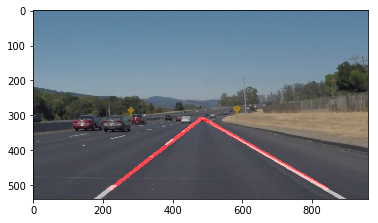

In [159]:
nFrames = 0
white_output = 'test_videos/modified_solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [254]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

(540, 960, 3)
avg_neg_slope(before) =  -0.782719300349
mean_negative_slope =  -0.646139690388
nFrames =  1
avg_neg_slope =  -0.714429495369
highest =  [463, 318]
bottom =  [152.26254943409512, 540]
end-points =  463 318 152 540
avg_pos_slope(before) =  0.56743716881
mean_positive_slope =  0.686782617083
avg_pos_slope =  0.627109892947
highest =  [509, 319]
bottom =  [861.41032311184495, 540]
end points =  509 319 861 540
[MoviePy] >>>> Building video test_videos/modified_solidYellowLeft.mp4
[MoviePy] Writing video test_videos/modified_solidYellowLeft.mp4



  0%|          | 0/683 [00:00<?, ?it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.714429495369
mean_negative_slope =  -0.646139690388
nFrames =  2
avg_neg_slope =  -0.691666227042
highest =  [463, 318]
bottom =  [142.03594057296144, 540]
end-points =  463 318 142 540
avg_pos_slope(before) =  0.627109892947
mean_positive_slope =  0.686782617083
avg_pos_slope =  0.647000800992
highest =  [509, 319]
bottom =  [850.57608408064732, 540]
end points =  509 319 850 540



  0%|          | 2/683 [00:00<00:46, 14.49it/s]

(540, 960, 3)
(540, 960, 3)


(540, 960, 3)



  1%|          | 4/683 [00:00<00:58, 11.56it/s]

(540, 960, 3)
(540, 960, 3)
avg_neg_slope(before) =  -0.691666227042
mean_negative_slope =  -0.0581504702194
nFrames =  7
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.647000800992
mean_positive_slope =  nan



  1%|          | 6/683 [00:00<00:54, 12.35it/s]

avg_pos_slope =  0.647000800992
highest =  [0, 1000]
bottom =  [-710.97284469274996, 540]
end points =  0 1000 -710 540
(540, 960, 3)
(540, 960, 3)



  1%|          | 8/683 [00:00<00:50, 13.39it/s]

(540, 960, 3)



  1%|▏         | 10/683 [00:00<00:50, 13.30it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  11
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.647000800992
mean_positive_slope =  0.72493202301
avg_pos_slope =  0.654085457539
highest =  [651, 409]
bottom =  [851.27964005317915, 540]
end points =  651 409 851 540
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  14



  2%|▏         | 13/683 [00:00<00:45, 14.57it/s]

avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.654085457539
mean_positive_slope =  0.628448584847
avg_pos_slope =  0.651754832749
highest =  [614, 383]
bottom =  [854.88812558206575, 540]
end points =  614 383 854 540
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  15
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.651754832749
mean_positive_slope =  0.63032870937
avg_pos_slope =  0.649807003351
highest =  [623, 389]
bottom =  [855.37668911122125, 540]
end points =  623 389 855 540
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  16
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.649807003351
mean_positive_sl


  2%|▏         | 17/683 [00:01<00:53, 12.39it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  17
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.645083380849
mean_positive_slope =  0.597949097298
avg_pos_slope =  0.640798445981
highest =  [640, 404]
bottom =  [852.23522131331924, 540]
end points =  640 404 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  18
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.640798445981
mean_positive_slope =  0.601050095781
avg_pos_slope =  0.637184959599
highest =  [655, 413]
bottom =  [854.31418356123697, 540]
end points =  655 413 854 540
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  19
avg_neg_slope = 


  3%|▎         | 21/683 [00:01<00:45, 14.55it/s]

 -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.637184959599
mean_positive_slope =  0.674846625767
avg_pos_slope =  0.640608747433
highest =  [673, 426]
bottom =  [850.95573422450241, 540]
end points =  673 426 850 540
(540, 960, 3)
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  21
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.640608747433
mean_positive_slope =  0.603299822914
avg_pos_slope =  0.637217027022
highest =  [604, 379]
bottom =  [856.66117064145385, 540]
end points =  604 379 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  22
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.637217027022
mean_positive_slo


  4%|▎         | 25/683 [00:01<00:43, 15.13it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  24
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.636235279769
mean_positive_slope =  0.6125
avg_pos_slope =  0.634077527063
highest =  [592, 371]
bottom =  [858.52892239048936, 540]
end points =  592 371 858 540
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  25
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.634077527063
mean_positive_slope =  0.628251208909
avg_pos_slope =  0.633547861776
highest =  [564, 352]
bottom =  [860.74159024550829, 540]
end points =  564 352 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  26
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 5


  4%|▍         | 27/683 [00:01<00:44, 14.76it/s]

avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.6327184926
mean_positive_slope =  0.642838161019
avg_pos_slope =  0.633638462456
highest =  [539, 337]
bottom =  [859.37196607831481, 540]
end points =  539 337 859 540
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  nan
nFrames =  28
avg_neg_slope =  -0.612476757439
highest =  [0, 1000]
bottom =  [751.04890824472898, 540]
end-points =  0 1000 751 540
avg_pos_slope(before) =  0.633638462456
mean_positive_slope =  0.622385569786
avg_pos_slope =  0.632615472214
highest =  [539, 339]
bottom =  [856.72855522591908, 540]
end points =  539 339 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.612476757439
mean_negative_slope =  -0.599943534726
nFrames =  29
avg_neg_slope =  -0.611337373556
highest =  [300, 442]
bottom =  [139.69571591881677, 540]
end-points =  300 442 139 540
avg_pos_slope(before) =  0.632615472214
mea


  5%|▍         | 33/683 [00:02<00:37, 17.13it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.608196040173
mean_negative_slope =  -0.534653465347
nFrames =  31
avg_neg_slope =  -0.601510351553
highest =  [242, 484]
bottom =  [148.90102031421071, 540]
end-points =  242 484 148 540
avg_pos_slope(before) =  0.632641738027
mean_positive_slope =  0.623935489491
avg_pos_slope =  0.631850260888
highest =  [545, 339]
bottom =  [863.11334495238589, 540]
end points =  545 339 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.601510351553
mean_negative_slope =  -0.708778992454
nFrames =  32
avg_neg_slope =  -0.61126204618
highest =  [448, 325]
bottom =  [96.268690419144079, 540]
end-points =  448 325 96 540
avg_pos_slope(before) =  0.631850260888
mean_positive_slope =  0.609595552261
avg_pos_slope =  0.629827105558
highest =  [540, 334]
bottom =  [867.07388771005151, 540]
end points =  540 334 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.61126204618
mean_negative_slope =  -0.712087566488
nFrames =  33
avg_neg_slope =  -0.620428002572
highest 


  5%|▌         | 36/683 [00:02<00:35, 18.04it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.632030902872
mean_negative_slope =  -0.710685703973
nFrames =  35
avg_neg_slope =  -0.639181339336
highest =  [401, 364]
bottom =  [125.64778120271956, 540]
end-points =  401 364 125 540
avg_pos_slope(before) =  0.628174116012
mean_positive_slope =  0.598220461157
avg_pos_slope =  0.62545105648
highest =  [533, 332]
bottom =  [865.55999465529123, 540]
end points =  533 332 865 540
(540, 960, 3)
avg_neg_slope(before) =  -0.639181339336
mean_negative_slope =  -0.711461986895
nFrames =  36
avg_neg_slope =  -0.645752307296
highest =  [437, 334]
bottom =  [117.99223545538369, 540]
end-points =  437 334 117 540
avg_pos_slope(before) =  0.62545105648
mean_positive_slope =  0.639475491117
avg_pos_slope =  0.626726005083
highest =  [531, 330]
bottom =  [866.07465510735335, 540]
end points =  531 330 866 540
(540, 960, 3)
avg_neg_slope(before) =  -0.645752307296
mean_negative_slope =  -0.736822503685
nFrames =  37
avg_neg_slope =  -0.654031416059
highest


  6%|▌         | 42/683 [00:02<00:31, 20.17it/s]

540
avg_pos_slope(before) =  0.627260567167
mean_positive_slope =  0.606762976014
avg_pos_slope =  0.62539714979
highest =  [535, 332]
bottom =  [867.58865997375324, 540]
end points =  535 332 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.667615702743
mean_negative_slope =  -0.735043799992
nFrames =  40
avg_neg_slope =  -0.673745529766
highest =  [439, 330]
bottom =  [127.30962029087013, 540]
end-points =  439 330 127 540
avg_pos_slope(before) =  0.62539714979
mean_positive_slope =  0.612788678105
avg_pos_slope =  0.624250925091
highest =  [536, 333]
bottom =  [867.59742609873729, 540]
end points =  536 333 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.673745529766
mean_negative_slope =  -0.728857434468
nFrames =  41
avg_neg_slope =  -0.67875570292
highest =  [438, 330]
bottom =  [128.61033432729957, 540]
end-points =  438 330 128 540
avg_pos_slope(before) =  0.624250925091
mean_positive_slope =  0.580924790858
avg_pos_slope =  0.620312185615
highest =  [538, 333]
bottom =  [87


  7%|▋         | 45/683 [00:02<00:34, 18.25it/s]

 -0.691213422421
mean_negative_slope =  -0.727529680447
nFrames =  44
avg_neg_slope =  -0.694514900423
highest =  [440, 329]
bottom =  [136.19082344884359, 540]
end-points =  440 329 136 540
avg_pos_slope(before) =  0.618224663208
mean_positive_slope =  0.636820493492
avg_pos_slope =  0.619915193234
highest =  [525, 327]
bottom =  [868.59538582842526, 540]
end points =  525 327 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.694514900423
mean_negative_slope =  -0.727346582738
nFrames =  45
avg_neg_slope =  -0.697499598815
highest =  [442, 328]
bottom =  [138.05717284983001, 540]
end-points =  442 328 138 540
avg_pos_slope(before) =  0.619915193234
mean_positive_slope =  0.600242338785
avg_pos_slope =  0.61812675192
highest =  [524, 327]
bottom =  [868.5895187974985, 540]
end points =  524 327 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.697499598815
mean_negative_slope =  -0.719517845198
nFrames =  46
avg_neg_slope =  -0.699501257577
highest =  [443, 328]
bottom =  [139.92692085


  7%|▋         | 49/683 [00:03<00:39, 16.06it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70229986194
mean_negative_slope =  -0.719499232391
nFrames =  49
avg_neg_slope =  -0.703863441072
highest =  [446, 326]
bottom =  [141.96375161324599, 540]
end-points =  446 326 141 540
avg_pos_slope(before) =  0.620622389095
mean_positive_slope =  0.628119603361
avg_pos_slope =  0.621303954028
highest =  [513, 321]
bottom =  [865.48447813704274, 540]
end points =  513 321 865 540
(540, 960, 3)
avg_neg_slope(before) =  -0.703863441072
mean_negative_slope =  -0.737456809839
nFrames =  50
avg_neg_slope =  -0.706917383687
highest =  [439, 332]
bottom =  [144.76476855722549, 540]
end-points =  439 332 144 540
avg_pos_slope(before) =  0.621303954028
mean_positive_slope =  0.613811420243
avg_pos_slope =  0.620622814593
highest =  [516, 323]
bottom =  [865.64876394745318, 540]
end points =  516 323 865 540
(540, 960, 3)
avg_neg_slope(before) =  -0.706917383687
mean_negative_slope =  -0.730486320134
nFrames =  51
avg_neg_slope =  -0.709060014273
highes


  8%|▊         | 53/683 [00:03<00:42, 14.86it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709060014273
mean_negative_slope =  -0.738362644627
nFrames =  52
avg_neg_slope =  -0.71172388976
highest =  [444, 327]
bottom =  [144.72663983227034, 540]
end-points =  444 327 144 540
avg_pos_slope(before) =  0.619525287803
mean_positive_slope =  0.609951662577
avg_pos_slope =  0.618654958237
highest =  [519, 324]
bottom =  [868.14453868674684, 540]
end points =  519 324 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71172388976
mean_negative_slope =  -0.738756391742
nFrames =  53
avg_neg_slope =  -0.71418138994
highest =  [444, 327]
bottom =  [145.75644030999916, 540]
end-points =  444 327 145 540
avg_pos_slope(before) =  0.618654958237
mean_positive_slope =  0.626919749668
avg_pos_slope =  0.619406302913
highest =  [518, 325]
bottom =  [865.10657445520349, 540]
end points =  518 325 865 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71418138994
mean_negative_slope =  -0.742293726068
nFrames =  54
avg_neg_slope =  -0.716737056861
highest =


  8%|▊         | 55/683 [00:03<00:41, 15.27it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.716737056861
mean_negative_slope =  -0.73299824534
nFrames =  55
avg_neg_slope =  -0.718215346722
highest =  [448, 325]
bottom =  [148.64688678519158, 540]
end-points =  448 325 148 540
avg_pos_slope(before) =  0.618361562803
mean_positive_slope =  0.607943999553
avg_pos_slope =  0.617414511599
highest =  [511, 320]
bottom =  [867.32463420771785, 540]
end points =  511 320 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.718215346722
mean_negative_slope =  -0.700509452784
nFrames =  56
avg_neg_slope =  -0.716605720001
highest =  [448, 325]
bottom =  [147.97448527232484, 540]
end-points =  448 325 147 540
avg_pos_slope(before) =  0.617414511599
mean_positive_slope =  0.613017220265
avg_pos_slope =  0.617014757841
highest =  [511, 320]
bottom =  [867.5554911031993, 540]
end points =  511 320 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.716605720001
mean_negative_slope =  nan
nFrames =  57
avg_neg_slope =  -0.716605720001
highest =  [446, 32


  9%|▊         | 59/683 [00:03<00:45, 13.82it/s]

 -0.716605720001
mean_negative_slope =  -0.72641375416
nFrames =  58
avg_neg_slope =  -0.71749735947
highest =  [446, 326]
bottom =  [147.74106263168517, 540]
end-points =  446 326 147 540
avg_pos_slope(before) =  0.618138052562
mean_positive_slope =  0.644586338625
avg_pos_slope =  0.620542442204
highest =  [511, 320]
bottom =  [865.5285302620947, 540]
end points =  511 320 865 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71749735947
mean_negative_slope =  -0.737342995236
nFrames =  59
avg_neg_slope =  -0.719301508176
highest =  [446, 326]
bottom =  [148.48915431478693, 540]
end-points =  446 326 148 540
avg_pos_slope(before) =  0.620542442204
mean_positive_slope =  0.646853306815
avg_pos_slope =  0.622934338987
highest =  [507, 318]
bottom =  [863.37784932665568, 540]
end points =  507 318 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.719301508176
mean_negative_slope =  -0.735242494745
nFrames =  60
avg_neg_slope =  -0.720750688773
highest =  [446, 326]
bottom =  [149.0873458277


  9%|▉         | 61/683 [00:04<00:44, 14.05it/s]


avg_neg_slope(before) =  -0.720750688773
mean_negative_slope =  -0.737822162635
nFrames =  61
avg_neg_slope =  -0.722302640942
highest =  [448, 325]
bottom =  [150.34083635697002, 540]
end-points =  448 325 150 540
avg_pos_slope(before) =  0.623805572997
mean_positive_slope =  0.62800600091
avg_pos_slope =  0.62418743008
highest =  [507, 318]
bottom =  [862.66240090996109, 540]
end points =  507 318 862 540
(540, 960, 3)
avg_neg_slope(before) =  -0.722302640942
mean_negative_slope =  -0.710723455033
nFrames =  62
avg_neg_slope =  -0.721249987678
highest =  [444, 327]
bottom =  [148.67937103776168, 540]
end-points =  444 327 148 540
avg_pos_slope(before) =  0.62418743008
mean_positive_slope =  0.610718170199
avg_pos_slope =  0.622962951909
highest =  [509, 320]
bottom =  [862.15101696804732, 540]
end points =  509 320 862 540
(540, 960, 3)
avg_neg_slope(before) =  -0.721249987678
mean_negative_slope =  -0.736263386523
nFrames =  63
avg_neg_slope =  -0.722614842118
highest =  [446, 326]


 10%|▉         | 65/683 [00:04<00:41, 14.97it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.72016043693
mean_negative_slope =  -0.713297624842
nFrames =  65
avg_neg_slope =  -0.719536544922
highest =  [448, 325]
bottom =  [149.1965528127071, 540]
end-points =  448 325 149 540
avg_pos_slope(before) =  0.621131758718
mean_positive_slope =  0.603198980015
avg_pos_slope =  0.619501506108
highest =  [507, 318]
bottom =  [865.3526396806061, 540]
end points =  507 318 865 540
(540, 960, 3)
avg_neg_slope(before) =  -0.719536544922
mean_negative_slope =  -0.713322121383
nFrames =  66
avg_neg_slope =  -0.718971597328
highest =  [448, 325]
bottom =  [148.96176149502563, 540]
end-points =  448 325 148 540
avg_pos_slope(before) =  0.619501506108
mean_positive_slope =  0.60866907136
avg_pos_slope =  0.618516739313
highest =  [505, 317]
bottom =  [865.53995927048766, 540]
end points =  505 317 865 540
(540, 960, 3)
avg_neg_slope(before) =  -0.718971597328
mean_negative_slope =  -0.702062297762
nFrames =  67
avg_neg_slope =  -0.717434388276
highest =


 10%|█         | 69/683 [00:04<00:40, 15.09it/s]

highest =  [450, 324]
bottom =  [149.80369938929579, 540]
end-points =  450 324 149 540
avg_pos_slope(before) =  0.620335928235
mean_positive_slope =  0.625166136706
avg_pos_slope =  0.620775038096
highest =  [505, 317]
bottom =  [864.2283618297995, 540]
end points =  505 317 864 540
(540, 960, 3)
avg_neg_slope(before) =  -0.719529186604
mean_negative_slope =  -0.687638344836
nFrames =  69
avg_neg_slope =  -0.716630019171
highest =  [451, 324]
bottom =  [149.58923820976329, 540]
end-points =  451 324 149 540
avg_pos_slope(before) =  0.620775038096
mean_positive_slope =  0.649211087409
avg_pos_slope =  0.623360133488
highest =  [503, 316]
bottom =  [862.34283886044489, 540]
end points =  503 316 862 540
(540, 960, 3)
avg_neg_slope(before) =  -0.716630019171
mean_negative_slope =  -0.702059887428
nFrames =  70
avg_neg_slope =  -0.71530546174
highest =  [452, 324]
bottom =  [150.03110481680514, 540]
end-points =  452 324 150 540
avg_pos_slope(before) =  0.623360133488
mean_positive_slope 


 11%|█         | 73/683 [00:04<00:37, 16.36it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.712575053579
mean_negative_slope =  -0.709992533156
nFrames =  73
avg_neg_slope =  -0.712340278995
highest =  [453, 323]
bottom =  [148.37030770447259, 540]
end-points =  453 323 148 540
avg_pos_slope(before) =  0.628694014373
mean_positive_slope =  0.631266095296
avg_pos_slope =  0.628927839912
highest =  [502, 316]
bottom =  [858.16168626182036, 540]
end points =  502 316 858 540
(540, 960, 3)
avg_neg_slope(before) =  -0.712340278995
mean_negative_slope =  -0.691650879021
nFrames =  74
avg_neg_slope =  -0.710459424452
highest =  [446, 329]
bottom =  [149.00907731256024, 540]
end-points =  446 329 149 540
avg_pos_slope(before) =  0.628927839912
mean_positive_slope =  0.643563987182
avg_pos_slope =  0.630258398755
highest =  [501, 315]
bottom =  [857.99643264510894, 540]
end points =  501 315 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.710459424452
mean_negative_slope =  -0.701158819891
nFrames =  75
avg_neg_slope =  -0.709613914947
highe


 11%|█▏        | 77/683 [00:04<00:36, 16.66it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.708846713513
mean_negative_slope =  -0.714940196772
nFrames =  77
avg_neg_slope =  -0.709400666537
highest =  [454, 322]
bottom =  [146.69834342801735, 540]
end-points =  454 322 146 540
avg_pos_slope(before) =  0.629344492997
mean_positive_slope =  0.641566344819
avg_pos_slope =  0.630455570435
highest =  [499, 314]
bottom =  [857.47093847380643, 540]
end points =  499 314 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.709400666537
mean_negative_slope =  -0.709947054206
nFrames =  78
avg_neg_slope =  -0.709450338143
highest =  [456, 321]
bottom =  [147.31031697972949, 540]
end-points =  456 321 147 540
avg_pos_slope(before) =  0.630455570435
mean_positive_slope =  0.64412535178
avg_pos_slope =  0.63169827783
highest =  [499, 314]
bottom =  [856.76573711145124, 540]
end points =  499 314 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.709450338143
mean_negative_slope =  -0.719875919226
nFrames =  79
avg_neg_slope =  -0.710398118241
highest


 12%|█▏        | 83/683 [00:05<00:34, 17.51it/s]

 [508, 319]
bottom =  [858.7451679649738, 540]
end points =  508 319 858 540
(540, 960, 3)
avg_neg_slope(before) =  -0.710473760839
mean_negative_slope =  -0.713218502081
nFrames =  81
avg_neg_slope =  -0.71072328277
highest =  [452, 324]
bottom =  [148.08424933242625, 540]
end-points =  452 324 148 540
avg_pos_slope(before) =  0.630087083686
mean_positive_slope =  0.649921041669
avg_pos_slope =  0.631890170775
highest =  [501, 315]
bottom =  [857.0745370100193, 540]
end points =  501 315 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71072328277
mean_negative_slope =  -0.697099134673
nFrames =  82
avg_neg_slope =  -0.709484723852
highest =  [456, 321]
bottom =  [147.32527785670177, 540]
end-points =  456 321 147 540
avg_pos_slope(before) =  0.631890170775
mean_positive_slope =  0.658534130683
avg_pos_slope =  0.634312348949
highest =  [501, 315]
bottom =  [855.71483469131056, 540]
end points =  501 315 855 540
(540, 960, 3)
avg_neg_slope(before) =  -0.709484723852
mean_negative_slo


 12%|█▏        | 85/683 [00:05<00:36, 16.58it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.708878864531
mean_negative_slope =  -0.694556455871
nFrames =  85
avg_neg_slope =  -0.70757682738
highest =  [452, 323]
bottom =  [145.31952149495905, 540]
end-points =  452 323 145 540
avg_pos_slope(before) =  0.638962431909
mean_positive_slope =  0.639345353468
avg_pos_slope =  0.638997242959
highest =  [502, 316]
bottom =  [852.54924331530515, 540]
end points =  502 316 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.70757682738
mean_negative_slope =  -0.707986140191
nFrames =  86
avg_neg_slope =  -0.707614037636
highest =  [452, 323]
bottom =  [145.33564844886857, 540]
end-points =  452 323 145 540
avg_pos_slope(before) =  0.638997242959
mean_positive_slope =  0.655241558726
avg_pos_slope =  0.640473998938
highest =  [503, 316]
bottom =  [852.74097367160584, 540]
end points =  503 316 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.707614037636
mean_negative_slope =  -0.703939392367
nFrames =  87
avg_neg_slope =  -0.707279978975
highest


 13%|█▎        | 89/683 [00:05<00:36, 16.10it/s]

 540
(540, 960, 3)
avg_neg_slope(before) =  -0.706228279306
mean_negative_slope =  -0.688736734596
nFrames =  89
avg_neg_slope =  -0.704638138878
highest =  [454, 322]
bottom =  [144.62134452859502, 540]
end-points =  454 322 144 540
avg_pos_slope(before) =  0.641206618874
mean_positive_slope =  0.637826311142
avg_pos_slope =  0.640899318171
highest =  [503, 317]
bottom =  [850.9485680160949, 540]
end points =  503 317 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.704638138878
mean_negative_slope =  -0.692041942503
nFrames =  90
avg_neg_slope =  -0.703493030117
highest =  [449, 326]
bottom =  [144.80366707473067, 540]
end-points =  449 326 144 540
avg_pos_slope(before) =  0.640899318171
mean_positive_slope =  0.637327342848
avg_pos_slope =  0.640574593141
highest =  [501, 315]
bottom =  [852.24714968257592, 540]
end points =  501 315 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.703493030117
mean_negative_slope =  -0.688158605644
nFrames =  91
avg_neg_slope =  -0.702098991528
h


 14%|█▎        | 93/683 [00:06<00:38, 15.13it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.700767491896
mean_negative_slope =  -0.686253380225
nFrames =  93
avg_neg_slope =  -0.699448027199
highest =  [459, 320]
bottom =  [144.46626561935844, 540]
end-points =  459 320 144 540
avg_pos_slope(before) =  0.642167938393
mean_positive_slope =  0.632918767382
avg_pos_slope =  0.641327104665
highest =  [490, 310]
bottom =  [848.63134167745886, 540]
end points =  490 310 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.699448027199
mean_negative_slope =  nan
nFrames =  94
avg_neg_slope =  -0.699448027199
highest =  [481, 310]
bottom =  [152.16927769296555, 540]
end-points =  481 310 152 540
avg_pos_slope(before) =  0.641327104665
mean_positive_slope =  0.64356681171
avg_pos_slope =  0.641530714396
highest =  [485, 310]
bottom =  [843.51751886352429, 540]
end points =  485 310 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.699448027199
mean_negative_slope =  nan
nFrames =  95
avg_neg_slope =  -0.699448027199
highest =  [467, 316]
bottom =


 14%|█▍        | 97/683 [00:06<00:38, 15.39it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.699448027199
mean_negative_slope =  -0.686611846821
nFrames =  96
avg_neg_slope =  -0.69828110171
highest =  [467, 316]
bottom =  [146.21228363261872, 540]
end-points =  467 316 146 540
avg_pos_slope(before) =  0.645417167096
mean_positive_slope =  0.664816384808
avg_pos_slope =  0.647180732343
highest =  [493, 313]
bottom =  [843.75209853388435, 540]
end points =  493 313 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.69828110171
mean_negative_slope =  -0.688643151679
nFrames =  97
avg_neg_slope =  -0.697404924434
highest =  [467, 316]
bottom =  [145.80926538953312, 540]
end-points =  467 316 145 540
avg_pos_slope(before) =  0.647180732343
mean_positive_slope =  0.658207781346
avg_pos_slope =  0.648183191343
highest =  [491, 312]
bottom =  [842.75241049908743, 540]
end points =  491 312 842 540
(540, 960, 3)
avg_neg_slope(before) =  -0.697404924434
mean_negative_slope =  -0.69285205415
nFrames =  98
avg_neg_slope =  -0.696991027136
highest 


 14%|█▍        | 99/683 [00:06<00:38, 14.98it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.696991027136
mean_negative_slope =  -0.697701277262
nFrames =  99
avg_neg_slope =  -0.697055595329
highest =  [492, 311]
bottom =  [163.47527179392614, 540]
end-points =  492 311 163 540
avg_pos_slope(before) =  0.648924560091
mean_positive_slope =  0.608333333333
avg_pos_slope =  0.645234448567
highest =  [493, 312]
bottom =  [846.35993065200125, 540]
end points =  493 312 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.697055595329
mean_negative_slope =  -0.695413576959
nFrames =  100
avg_neg_slope =  -0.696906320932
highest =  [461, 319]
bottom =  [143.8842078738642, 540]
end-points =  461 319 143 540
avg_pos_slope(before) =  0.645234448567
mean_positive_slope =  0.638128056914
avg_pos_slope =  0.644588412962
highest =  [492, 311]
bottom =  [847.26546148659043, 540]
end points =  492 311 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.696906320932
mean_negative_slope =  -0.700028353225
nFrames =  101
avg_neg_slope =  -0.697190142049
high


 15%|█▌        | 103/683 [00:06<00:37, 15.59it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.696669973949
mean_negative_slope =  -0.688941870454
nFrames =  103
avg_neg_slope =  -0.695967419086
highest =  [463, 318]
bottom =  [144.01955075481047, 540]
end-points =  463 318 144 540
avg_pos_slope(before) =  0.645005211825
mean_positive_slope =  0.662511208592
avg_pos_slope =  0.646596666076
highest =  [491, 311]
bottom =  [845.16204879256338, 540]
end points =  491 311 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.695967419086
mean_negative_slope =  -0.674968258647
nFrames =  104
avg_neg_slope =  -0.6940584045
highest =  [463, 318]
bottom =  [143.14219183788518, 540]
end-points =  463 318 143 540
avg_pos_slope(before) =  0.646596666076
mean_positive_slope =  0.642157023673
avg_pos_slope =  0.646193062221
highest =  [491, 311]
bottom =  [845.3832538417912, 540]
end points =  491 311 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.6940584045
mean_negative_slope =  -0.685169116346
nFrames =  105
avg_neg_slope =  -0.693250287395
highest


 16%|█▌        | 107/683 [00:07<01:18,  7.36it/s]

mean_negative_slope =  -0.709848919033
nFrames =  106
avg_neg_slope =  -0.694759253908
highest =  [463, 318]
bottom =  [143.46485347080878, 540]
end-points =  463 318 143 540
avg_pos_slope(before) =  0.645845753856
mean_positive_slope =  0.641887154752
avg_pos_slope =  0.64548588121
highest =  [493, 311]
bottom =  [847.77150882180661, 540]
end points =  493 311 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.694759253908
mean_negative_slope =  -0.669311721082
nFrames =  107
avg_neg_slope =  -0.692445841833
highest =  [463, 318]
bottom =  [142.39730938037914, 540]
end-points =  463 318 142 540
avg_pos_slope(before) =  0.64548588121
mean_positive_slope =  0.631878163334
avg_pos_slope =  0.644248815948
highest =  [491, 311]
bottom =  [846.45272933546289, 540]
end points =  491 311 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.692445841833
mean_negative_slope =  nan
nFrames =  108
avg_neg_slope =  -0.692445841833
highest =  [438, 337]
bottom =  [144.83627839737363, 540]
end-points = 

 16%|█▋        | 111/683 [00:07<00:54, 10.55it/s]

 324 138 540
avg_pos_slope(before) =  0.645507474096
mean_positive_slope =  0.663508056186
avg_pos_slope =  0.647143890649
highest =  [492, 312]
bottom =  [844.31731813336762, 540]
end points =  492 312 844 540
(540, 960, 3)
avg_neg_slope(before) =  -0.692445841833
mean_negative_slope =  -0.674569324812
nFrames =  110
avg_neg_slope =  -0.690820703922
highest =  [467, 316]
bottom =  [142.74799260025594, 540]
end-points =  467 316 142 540
avg_pos_slope(before) =  0.647143890649
mean_positive_slope =  0.657910240292
avg_pos_slope =  0.648122649708
highest =  [490, 312]
bottom =  [841.78526796244864, 540]
end points =  490 312 841 540
(540, 960, 3)
avg_neg_slope(before) =  -0.690820703922
mean_negative_slope =  -0.671735190464
nFrames =  111
avg_neg_slope =  -0.689085657244
highest =  [443, 335]
bottom =  [145.50432896847445, 540]
end-points =  443 335 145 540
avg_pos_slope(before) =  0.648122649708
mean_positive_slope =  0.643379536543
avg_pos_slope =  0.647691457602
highest =  [492, 313]

 17%|█▋        | 115/683 [00:08<00:42, 13.48it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.688560867955
mean_negative_slope =  -0.688703599275
nFrames =  114
avg_neg_slope =  -0.688573843529
highest =  [469, 315]
bottom =  [142.23766054386525, 540]
end-points =  469 315 142 540
avg_pos_slope(before) =  0.647739711405
mean_positive_slope =  0.628591476954
avg_pos_slope =  0.645998962818
highest =  [487, 310]
bottom =  [843.03772333724032, 540]
end points =  487 310 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688573843529
mean_negative_slope =  -0.68764862306
nFrames =  115
avg_neg_slope =  -0.688489732578
highest =  [469, 315]
bottom =  [142.19774086157253, 540]
end-points =  469 315 142 540
avg_pos_slope(before) =  0.645998962818
mean_positive_slope =  0.636973277509
avg_pos_slope =  0.645178445972
highest =  [487, 310]
bottom =  [843.49052046915938, 540]
end points =  487 310 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688489732578
mean_negative_slope =  -0.687861152967
nFrames =  116
avg_neg_slope =  -0.688432588977
hig

 17%|█▋        | 119/683 [00:08<00:39, 14.21it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.688366817647
mean_negative_slope =  -0.687338090889
nFrames =  118
avg_neg_slope =  -0.688273297033
highest =  [480, 310]
bottom =  [145.8304179581346, 540]
end-points =  480 310 145 540
avg_pos_slope(before) =  0.644154949453
mean_positive_slope =  0.634793798508
avg_pos_slope =  0.643303935731
highest =  [490, 310]
bottom =  [847.52929093895966, 540]
end points =  490 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688273297033
mean_negative_slope =  nan
nFrames =  119
avg_neg_slope =  -0.688273297033
highest =  [480, 310]
bottom =  [145.8304179581346, 540]
end-points =  480 310 145 540
avg_pos_slope(before) =  0.643303935731
mean_positive_slope =  0.639689008396
avg_pos_slope =  0.642975305973
highest =  [491, 310]
bottom =  [848.71202698365653, 540]
end points =  491 310 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688273297033
mean_negative_slope =  nan
nFrames =  120
avg_neg_slope =  -0.688273297033
highest =  [480, 310]
bottom

 18%|█▊        | 121/683 [00:08<00:39, 14.40it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.688273297033
mean_negative_slope =  -0.68317049207
nFrames =  121
avg_neg_slope =  -0.687809405673
highest =  [480, 310]
bottom =  [145.605038106281, 540]
end-points =  480 310 145 540
avg_pos_slope(before) =  0.642392909377
mean_positive_slope =  0.648426807496
avg_pos_slope =  0.642941445569
highest =  [488, 310]
bottom =  [845.73086582761891, 540]
end points =  488 310 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.687809405673
mean_negative_slope =  -0.668086208496
nFrames =  122
avg_neg_slope =  -0.686016387747
highest =  [487, 310]
bottom =  [151.73104125801333, 540]
end-points =  487 310 151 540
avg_pos_slope(before) =  0.642941445569
mean_positive_slope =  0.63098344441
avg_pos_slope =  0.641854354555
highest =  [488, 310]
bottom =  [846.33674472691723, 540]
end points =  488 310 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.686016387747
mean_negative_slope =  -0.714481648759
nFrames =  123
avg_neg_slope =  -0.688604138748
highes

 19%|█▊        | 127/683 [00:08<00:32, 16.92it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.690743862363
mean_negative_slope =  -0.713724359417
nFrames =  125
avg_neg_slope =  -0.692832998459
highest =  [471, 314]
bottom =  [144.80306581408865, 540]
end-points =  471 314 144 540
avg_pos_slope(before) =  0.642554372709
mean_positive_slope =  0.64140684389
avg_pos_slope =  0.642450051907
highest =  [490, 311]
bottom =  [846.44794380548967, 540]
end points =  490 311 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.692832998459
mean_negative_slope =  -0.706406486294
nFrames =  126
avg_neg_slope =  -0.694066951898
highest =  [471, 315]
bottom =  [146.82378128696428, 540]
end-points =  471 315 146 540
avg_pos_slope(before) =  0.642450051907
mean_positive_slope =  0.627489604498
avg_pos_slope =  0.641090011233
highest =  [486, 311]
bottom =  [843.20413044558416, 540]
end points =  486 311 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.694066951898
mean_negative_slope =  -0.708883295763
nFrames =  127
avg_neg_slope =  -0.695413892249
hig

 19%|█▉        | 129/683 [00:08<00:32, 17.07it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.695963269027
mean_negative_slope =  -0.704762036795
nFrames =  129
avg_neg_slope =  -0.696763157006
highest =  [479, 310]
bottom =  [148.90217882889615, 540]
end-points =  479 310 148 540
avg_pos_slope(before) =  0.638025428582
mean_positive_slope =  0.626615817173
avg_pos_slope =  0.636988191181
highest =  [485, 310]
bottom =  [846.07419758202036, 540]
end points =  485 310 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.696763157006
mean_negative_slope =  -0.701398187593
nFrames =  130
avg_neg_slope =  -0.697184523423
highest =  [479, 310]
bottom =  [149.10168431345559, 540]
end-points =  479 310 149 540
avg_pos_slope(before) =  0.636988191181
mean_positive_slope =  0.639317502722
avg_pos_slope =  0.637199946776
highest =  [485, 310]
bottom =  [845.95420466330904, 540]
end points =  485 310 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.697184523423
mean_negative_slope =  -0.699633033011
nFrames =  131
avg_neg_slope =  -0.697407115204
hi

 20%|█▉        | 135/683 [00:09<00:31, 17.48it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.697407115204
mean_negative_slope =  -0.694987791639
nFrames =  133
avg_neg_slope =  -0.697187176698
highest =  [478, 311]
bottom =  [149.53727484686794, 540]
end-points =  478 311 149 540
avg_pos_slope(before) =  0.636012508519
mean_positive_slope =  0.649788484445
avg_pos_slope =  0.637264869967
highest =  [483, 310]
bottom =  [843.91743141596623, 540]
end points =  483 310 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.697187176698
mean_negative_slope =  -0.69918753762
nFrames =  134
avg_neg_slope =  -0.697369027691
highest =  [478, 311]
bottom =  [149.62292716340161, 540]
end-points =  478 311 149 540
avg_pos_slope(before) =  0.637264869967
mean_positive_slope =  0.640215895457
avg_pos_slope =  0.637533145011
highest =  [483, 310]
bottom =  [843.76555673972052, 540]
end points =  483 310 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.697369027691
mean_negative_slope =  -0.707153499618
nFrames =  135
avg_neg_slope =  -0.698258525139
hig

 20%|██        | 137/683 [00:09<00:30, 17.78it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.698480924606
mean_negative_slope =  -0.704401167623
nFrames =  137
avg_neg_slope =  -0.699019128517
highest =  [484, 310]
bottom =  [154.96751631383447, 540]
end-points =  484 310 154 540
avg_pos_slope(before) =  0.636194499991
mean_positive_slope =  0.630408933575
avg_pos_slope =  0.635668539408
highest =  [485, 310]
bottom =  [846.82378982325861, 540]
end points =  485 310 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.699019128517
mean_negative_slope =  -0.715787533356
nFrames =  138
avg_neg_slope =  -0.700543528957
highest =  [479, 310]
bottom =  [150.68349932151062, 540]
end-points =  479 310 150 540
avg_pos_slope(before) =  0.635668539408
mean_positive_slope =  0.616287231472
avg_pos_slope =  0.633906602323
highest =  [480, 310]
bottom =  [842.82947544194735, 540]
end points =  480 310 842 540
(540, 960, 3)
avg_neg_slope(before) =  -0.700543528957
mean_negative_slope =  -0.716601889482
nFrames =  139
avg_neg_slope =  -0.702003379913
hi

 21%|██        | 141/683 [00:09<00:34, 15.79it/s]

0.646895621831
avg_pos_slope =  0.634728798696
highest =  [484, 311]
bottom =  [844.7840080213897, 540]
end points =  484 311 844 540
(540, 960, 3)
avg_neg_slope(before) =  -0.700696964599
mean_negative_slope =  -0.707792145754
nFrames =  141
avg_neg_slope =  -0.701341981068
highest =  [477, 311]
bottom =  [150.48311354272806, 540]
end-points =  477 311 150 540
avg_pos_slope(before) =  0.634728798696
mean_positive_slope =  0.634329414538
avg_pos_slope =  0.634692491045
highest =  [484, 310]
bottom =  [846.38021285133868, 540]
end points =  484 310 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.701341981068
mean_negative_slope =  -0.699687416549
nFrames =  142
avg_neg_slope =  -0.701191566111
highest =  [480, 311]
bottom =  [153.41307130953092, 540]
end-points =  480 311 153 540
avg_pos_slope(before) =  0.634692491045
mean_positive_slope =  0.622416219338
avg_pos_slope =  0.633576466344
highest =  [482, 310]
bottom =  [845.01853401705523, 540]
end points =  482 310 845 540
(540, 960,

 21%|██        | 145/683 [00:09<00:34, 15.78it/s]


avg_neg_slope(before) =  -0.702346885226
mean_negative_slope =  -0.675996703902
nFrames =  144
avg_neg_slope =  -0.699951414196
highest =  [482, 311]
bottom =  [154.83443485433898, 540]
end-points =  482 311 154 540
avg_pos_slope(before) =  0.636643072439
mean_positive_slope =  0.651811160444
avg_pos_slope =  0.638021989531
highest =  [483, 310]
bottom =  [843.48914265357701, 540]
end points =  483 310 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.699951414196
mean_negative_slope =  -0.637264680315
nFrames =  145
avg_neg_slope =  -0.694252620207
highest =  [482, 310]
bottom =  [150.70848837210059, 540]
end-points =  482 310 150 540
avg_pos_slope(before) =  0.638021989531
mean_positive_slope =  0.606656346187
avg_pos_slope =  0.635170567408
highest =  [481, 311]
bottom =  [841.53307843650214, 540]
end points =  481 311 841 540
(540, 960, 3)
avg_neg_slope(before) =  -0.694252620207
mean_negative_slope =  -0.683538805241
nFrames =  146
avg_neg_slope =  -0.693278637028
highest =  [482

 22%|██▏       | 150/683 [00:10<00:30, 17.41it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.693260703551
mean_negative_slope =  -0.720444224282
nFrames =  148
avg_neg_slope =  -0.695731932709
highest =  [477, 313]
bottom =  [150.72490850567974, 540]
end-points =  477 313 150 540
avg_pos_slope(before) =  0.636266807427
mean_positive_slope =  0.608645537972
avg_pos_slope =  0.633755782931
highest =  [480, 312]
bottom =  [839.76003082033378, 540]
end points =  480 312 839 540
(540, 960, 3)
avg_neg_slope(before) =  -0.695731932709
mean_negative_slope =  -0.7170142803
nFrames =  149
avg_neg_slope =  -0.69766669158
highest =  [481, 311]
bottom =  [152.76303131051804, 540]
end-points =  481 311 152 540
avg_pos_slope(before) =  0.633755782931
mean_positive_slope =  0.629530369828
avg_pos_slope =  0.633371654468
highest =  [480, 311]
bottom =  [841.55707061523879, 540]
end points =  480 311 841 540
(540, 960, 3)
avg_neg_slope(before) =  -0.69766669158
mean_negative_slope =  -0.713545634524
nFrames =  150
avg_neg_slope =  -0.699110231848
highes

 23%|██▎       | 154/683 [00:10<00:29, 17.93it/s]


avg_neg_slope(before) =  -0.699465542741
mean_negative_slope =  -0.694155441718
nFrames =  152
avg_neg_slope =  -0.698982806284
highest =  [492, 311]
bottom =  [164.3810686883275, 540]
end-points =  492 311 164 540
avg_pos_slope(before) =  0.632067463731
mean_positive_slope =  0.611243405105
avg_pos_slope =  0.630174367492
highest =  [483, 310]
bottom =  [847.97834863600337, 540]
end points =  483 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.698982806284
mean_negative_slope =  -0.708046107364
nFrames =  153
avg_neg_slope =  -0.699806742746
highest =  [486, 310]
bottom =  [157.33783378887011, 540]
end-points =  486 310 157 540
avg_pos_slope(before) =  0.630174367492
mean_positive_slope =  0.600750005938
avg_pos_slope =  0.627499425533
highest =  [482, 310]
bottom =  [848.5342000987149, 540]
end points =  482 310 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.699806742746
mean_negative_slope =  -0.724101100536
nFrames =  154
avg_neg_slope =  -0.702015320727
highest =  [474, 

 23%|██▎       | 156/683 [00:10<00:29, 17.92it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.702762088065
mean_negative_slope =  -0.688126675237
nFrames =  156
avg_neg_slope =  -0.701431595989
highest =  [486, 310]
bottom =  [158.09917358288561, 540]
end-points =  486 310 158 540
avg_pos_slope(before) =  0.62389718417
mean_positive_slope =  0.613131433712
avg_pos_slope =  0.622918479583
highest =  [484, 310]
bottom =  [853.22969463671097, 540]
end points =  484 310 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.701431595989
mean_negative_slope =  -0.691096088116
nFrames =  157
avg_neg_slope =  -0.700492004365
highest =  [489, 310]
bottom =  [160.65935004692599, 540]
end-points =  489 310 160 540
avg_pos_slope(before) =  0.622918479583
mean_positive_slope =  0.61281864498
avg_pos_slope =  0.622000312801
highest =  [493, 312]
bottom =  [859.55930118957258, 540]
end points =  493 312 859 540
(540, 960, 3)
avg_neg_slope(before) =  -0.700492004365
mean_negative_slope =  -0.696692039721
nFrames =  158
avg_neg_slope =  -0.700146553033
high

 24%|██▎       | 161/683 [00:10<00:31, 16.68it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.698778484765
mean_negative_slope =  -0.70048394021
nFrames =  160
avg_neg_slope =  -0.698933526169
highest =  [489, 310]
bottom =  [159.9272178417275, 540]
end-points =  489 310 159 540
avg_pos_slope(before) =  0.617959176044
mean_positive_slope =  0.600527143748
avg_pos_slope =  0.616374445835
highest =  [485, 311]
bottom =  [856.52740764527232, 540]
end points =  485 311 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.698933526169
mean_negative_slope =  -0.688372952337
nFrames =  161
avg_neg_slope =  -0.697973474002
highest =  [488, 310]
bottom =  [158.47458310813238, 540]
end-points =  488 310 158 540
avg_pos_slope(before) =  0.616374445835
mean_positive_slope =  0.603057121379
avg_pos_slope =  0.615163779976
highest =  [483, 312]
bottom =  [853.63300444801791, 540]
end points =  483 312 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.697973474002
mean_negative_slope =  -0.711982972617
nFrames =  162
avg_neg_slope =  -0.699247064785
high

 24%|██▍       | 163/683 [00:10<00:33, 15.35it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.699247064785
mean_negative_slope =  -0.710902774568
nFrames =  163
avg_neg_slope =  -0.700306674766
highest =  [489, 310]
bottom =  [160.5724577707397, 540]
end-points =  489 310 160 540
avg_pos_slope(before) =  0.615037844895
mean_positive_slope =  0.588612105737
avg_pos_slope =  0.612635504972
highest =  [482, 313]
bottom =  [852.53027151997469, 540]
end points =  482 313 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.700306674766
mean_negative_slope =  -0.724064052495
nFrames =  164
avg_neg_slope =  -0.702466436377
highest =  [490, 310]
bottom =  [162.58222159889604, 540]
end-points =  490 310 162 540
avg_pos_slope(before) =  0.612635504972
mean_positive_slope =  0.577615738056
avg_pos_slope =  0.609451889798
highest =  [478, 311]
bottom =  [853.74746068312072, 540]
end points =  478 311 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.702466436377
mean_negative_slope =  -0.714754363052
nFrames =  165
avg_neg_slope =  -0.70358352062
high

 24%|██▍       | 167/683 [00:11<00:31, 16.44it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70511428279
mean_negative_slope =  -0.710329791651
nFrames =  167
avg_neg_slope =  -0.705588419959
highest =  [485, 310]
bottom =  [159.03093149773397, 540]
end-points =  485 310 159 540
avg_pos_slope(before) =  0.604589529755
mean_positive_slope =  0.604924861849
avg_pos_slope =  0.604620014491
highest =  [486, 310]
bottom =  [866.40421171567709, 540]
end points =  486 310 866 540
(540, 960, 3)
avg_neg_slope(before) =  -0.705588419959
mean_negative_slope =  -0.71529487803
nFrames =  168
avg_neg_slope =  -0.706470825238
highest =  [484, 310]
bottom =  [158.4380775774263, 540]
end-points =  484 310 158 540
avg_pos_slope(before) =  0.604620014491
mean_positive_slope =  0.594724674962
avg_pos_slope =  0.60372043817
highest =  [491, 310]
bottom =  [871.97103470120942, 540]
end points =  491 310 871 540
(540, 960, 3)
avg_neg_slope(before) =  -0.706470825238
mean_negative_slope =  -0.712069049188
nFrames =  169
avg_neg_slope =  -0.706979754688
highes

 25%|██▌       | 171/683 [00:11<00:30, 16.90it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.706271456939
mean_negative_slope =  -0.707504463559
nFrames =  171
avg_neg_slope =  -0.70638354845
highest =  [491, 310]
bottom =  [165.39785297294168, 540]
end-points =  491 310 165 540
avg_pos_slope(before) =  0.60061676578
mean_positive_slope =  0.605614716425
avg_pos_slope =  0.60107112493
highest =  [486, 310]
bottom =  [868.65022301135309, 540]
end points =  486 310 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.70638354845
mean_negative_slope =  -0.713283032454
nFrames =  172
avg_neg_slope =  -0.707010774269
highest =  [487, 310]
bottom =  [161.68671147499094, 540]
end-points =  487 310 161 540
avg_pos_slope(before) =  0.60107112493
mean_positive_slope =  0.566165730743
avg_pos_slope =  0.597897907276
highest =  [485, 310]
bottom =  [869.68105875758636, 540]
end points =  485 310 869 540
(540, 960, 3)
avg_neg_slope(before) =  -0.707010774269
mean_negative_slope =  -0.717319112669
nFrames =  173
avg_neg_slope =  -0.707947895942
highest

 26%|██▌       | 177/683 [00:11<00:28, 17.86it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.710640934337
mean_negative_slope =  -0.722831305257
nFrames =  175
avg_neg_slope =  -0.711749149876
highest =  [487, 310]
bottom =  [163.85244156567299, 540]
end-points =  487 310 163 540
avg_pos_slope(before) =  0.591629769148
mean_positive_slope =  0.583221983723
avg_pos_slope =  0.590865425018
highest =  [490, 311]
bottom =  [877.56710124467986, 540]
end points =  490 311 877 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711749149876
mean_negative_slope =  -0.737015378858
nFrames =  176
avg_neg_slope =  -0.714046079783
highest =  [480, 310]
bottom =  [157.89193651218659, 540]
end-points =  480 310 157 540
avg_pos_slope(before) =  0.590865425018
mean_positive_slope =  0.580069214482
avg_pos_slope =  0.589883951333
highest =  [484, 310]
bottom =  [873.90720035736308, 540]
end points =  484 310 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.714046079783
mean_negative_slope =  -0.726883768735
nFrames =  177
avg_neg_slope =  -0.715213142415
hi

 26%|██▌       | 179/683 [00:11<00:28, 17.53it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.718306031528
mean_negative_slope =  -0.748105871766
nFrames =  179
avg_neg_slope =  -0.721015107914
highest =  [483, 310]
bottom =  [164.00529728764977, 540]
end-points =  483 310 164 540
avg_pos_slope(before) =  0.588825618826
mean_positive_slope =  0.580586757841
avg_pos_slope =  0.588076631464
highest =  [486, 310]
bottom =  [877.10549152005706, 540]
end points =  486 310 877 540
(540, 960, 3)
avg_neg_slope(before) =  -0.721015107914
mean_negative_slope =  -0.74961080147
nFrames =  180
avg_neg_slope =  -0.723614716419
highest =  [486, 310]
bottom =  [168.15129573604878, 540]
end-points =  486 310 168 540
avg_pos_slope(before) =  0.588076631464
mean_positive_slope =  0.576930341564
avg_pos_slope =  0.587063332382
highest =  [490, 310]
bottom =  [881.78055809900866, 540]
end points =  490 310 881 540
(540, 960, 3)
avg_neg_slope(before) =  -0.723614716419
mean_negative_slope =  -0.727802752803
nFrames =  181
avg_neg_slope =  -0.723995446999
hig

 27%|██▋       | 185/683 [00:12<00:27, 18.34it/s]

end points =  483 310 878 540
(540, 960, 3)
avg_neg_slope(before) =  -0.723995446999
mean_negative_slope =  -0.749556987322
nFrames =  183
avg_neg_slope =  -0.726319223392
highest =  [485, 310]
bottom =  [168.33483048148219, 540]
end-points =  485 310 168 540
avg_pos_slope(before) =  0.581824419194
mean_positive_slope =  0.550325316254
avg_pos_slope =  0.578960864382
highest =  [485, 311]
bottom =  [880.53623411928208, 540]
end points =  485 311 880 540
(540, 960, 3)
avg_neg_slope(before) =  -0.726319223392
mean_negative_slope =  -0.761435496094
nFrames =  184
avg_neg_slope =  -0.72951161182
highest =  [483, 310]
bottom =  [167.72057706341027, 540]
end-points =  483 310 167 540
avg_pos_slope(before) =  0.578960864382
mean_positive_slope =  0.564031442573
avg_pos_slope =  0.577603644217
highest =  [487, 310]
bottom =  [885.19693366313049, 540]
end points =  487 310 885 540
(540, 960, 3)
avg_neg_slope(before) =  -0.72951161182
mean_negative_slope =  -0.766929598024
nFrames =  185
avg_neg

 27%|██▋       | 187/683 [00:12<00:27, 17.89it/s]


avg_neg_slope(before) =  -0.736043199458
mean_negative_slope =  -0.787144419774
nFrames =  187
avg_neg_slope =  -0.740688764942
highest =  [486, 310]
bottom =  [175.47821151556059, 540]
end-points =  486 310 175 540
avg_pos_slope(before) =  0.575329268191
mean_positive_slope =  0.533622018849
avg_pos_slope =  0.571537700069
highest =  [481, 312]
bottom =  [879.92381547632419, 540]
end points =  481 312 879 540
(540, 960, 3)
avg_neg_slope(before) =  -0.740688764942
mean_negative_slope =  -0.793882924056
nFrames =  188
avg_neg_slope =  -0.745524597588
highest =  [486, 310]
bottom =  [177.49240582535543, 540]
end-points =  486 310 177 540
avg_pos_slope(before) =  0.571537700069
mean_positive_slope =  0.551715666155
avg_pos_slope =  0.569735696986
highest =  [482, 311]
bottom =  [883.94076167523872, 540]
end points =  482 311 883 540
(540, 960, 3)
avg_neg_slope(before) =  -0.745524597588
mean_negative_slope =  -0.767872474183
nFrames =  189
avg_neg_slope =  -0.747556222733
highest =  [485

 28%|██▊       | 191/683 [00:12<00:28, 17.45it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.749446210651
mean_negative_slope =  -0.76927707274
nFrames =  191
avg_neg_slope =  -0.751249016295
highest =  [484, 310]
bottom =  [177.84319312094999, 540]
end-points =  484 310 177 540
avg_pos_slope(before) =  0.568441426023
mean_positive_slope =  0.569045406306
avg_pos_slope =  0.568496333321
highest =  [482, 312]
bottom =  [883.05799569191254, 540]
end points =  482 312 883 540
(540, 960, 3)
avg_neg_slope(before) =  -0.751249016295
mean_negative_slope =  -0.766168564471
nFrames =  192
avg_neg_slope =  -0.752605338857
highest =  [485, 310]
bottom =  [179.39493965139442, 540]
end-points =  485 310 179 540
avg_pos_slope(before) =  0.568496333321
mean_positive_slope =  0.567063542521
avg_pos_slope =  0.568366079612
highest =  [484, 311]
bottom =  [886.90933645495738, 540]
end points =  484 311 886 540
(540, 960, 3)
avg_neg_slope(before) =  -0.752605338857
mean_negative_slope =  -0.766402031641
nFrames =  193
avg_neg_slope =  -0.753859583655
hig

 29%|██▊       | 195/683 [00:12<00:28, 17.37it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.753859583655
mean_negative_slope =  -0.780053395184
nFrames =  195
avg_neg_slope =  -0.756240839249
highest =  [474, 313]
bottom =  [173.83107468054246, 540]
end-points =  474 313 173 540
avg_pos_slope(before) =  0.569367682101
mean_positive_slope =  0.546430500986
avg_pos_slope =  0.567282483818
highest =  [484, 311]
bottom =  [887.67895454598056, 540]
end points =  484 311 887 540
(540, 960, 3)
avg_neg_slope(before) =  -0.756240839249
mean_negative_slope =  -0.788510789938
nFrames =  196
avg_neg_slope =  -0.75917447113
highest =  [477, 311]
bottom =  [175.35655872456653, 540]
end-points =  477 311 175 540
avg_pos_slope(before) =  0.567282483818
mean_positive_slope =  0.590650787068
avg_pos_slope =  0.569406875023
highest =  [487, 310]
bottom =  [890.92908847616263, 540]
end points =  487 310 890 540
(540, 960, 3)
avg_neg_slope(before) =  -0.75917447113
mean_negative_slope =  -0.765784020194
nFrames =  197
avg_neg_slope =  -0.759775339226
high

 29%|██▉       | 200/683 [00:13<00:28, 17.17it/s]

avg_neg_slope(before) =  -0.760390017974
mean_negative_slope =  -0.769470827716
nFrames =  199
avg_neg_slope =  -0.761215546132
highest =  [483, 310]
bottom =  [180.85167792672803, 540]
end-points =  483 310 180 540
avg_pos_slope(before) =  0.57024996578
mean_positive_slope =  0.566312940577
avg_pos_slope =  0.569892054398
highest =  [489, 312]
bottom =  [889.07576564781527, 540]
end points =  489 312 889 540
(540, 960, 3)
avg_neg_slope(before) =  -0.761215546132
mean_negative_slope =  -0.77323001622
nFrames =  200
avg_neg_slope =  -0.762307770686
highest =  [481, 310]
bottom =  [179.28459207088582, 540]
end-points =  481 310 179 540
avg_pos_slope(before) =  0.569892054398
mean_positive_slope =  0.56234814068
avg_pos_slope =  0.56920624406
highest =  [490, 310]
bottom =  [894.07146337565086, 540]
end points =  490 310 894 540
(540, 960, 3)
avg_neg_slope(before) =  -0.762307770686
mean_negative_slope =  -0.771754715075
nFrames =  201
avg_neg_slope =  -0.763166583812
highest =  [480, 310

 30%|██▉       | 204/683 [00:13<00:27, 17.54it/s]

 -0.763166583812
mean_negative_slope =  -0.767026314708
nFrames =  202
avg_neg_slope =  -0.763517468439
highest =  [491, 310]
bottom =  [189.76262232712875, 540]
end-points =  491 310 189 540
avg_pos_slope(before) =  0.568046569348
mean_positive_slope =  0.595879440122
avg_pos_slope =  0.570576830328
highest =  [483, 310]
bottom =  [886.10084071906363, 540]
end points =  483 310 886 540
(540, 960, 3)
avg_neg_slope(before) =  -0.763517468439
mean_negative_slope =  -0.769481324581
nFrames =  203
avg_neg_slope =  -0.764059637179
highest =  [476, 312]
bottom =  [177.59397394458068, 540]
end-points =  476 312 177 540
avg_pos_slope(before) =  0.570576830328
mean_positive_slope =  0.550750326968
avg_pos_slope =  0.568774420932
highest =  [477, 313]
bottom =  [876.10374244363766, 540]
end points =  477 313 876 540
(540, 960, 3)
avg_neg_slope(before) =  -0.764059637179
mean_negative_slope =  -0.772871408756
nFrames =  204
avg_neg_slope =  -0.764860707323
highest =  [479, 310]
bottom =  [178.291

 30%|███       | 208/683 [00:13<00:26, 17.85it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.768430770721
mean_negative_slope =  -0.74876021362
nFrames =  207
avg_neg_slope =  -0.766642538257
highest =  [480, 310]
bottom =  [179.99055815137868, 540]
end-points =  480 310 179 540
avg_pos_slope(before) =  0.570579489555
mean_positive_slope =  0.586073485414
avg_pos_slope =  0.571988034633
highest =  [481, 310]
bottom =  [883.10631354835868, 540]
end points =  481 310 883 540
(540, 960, 3)
avg_neg_slope(before) =  -0.766642538257
mean_negative_slope =  -0.742652274241
nFrames =  208
avg_neg_slope =  -0.764461605165
highest =  [483, 310]
bottom =  [182.13466098750135, 540]
end-points =  483 310 182 540
avg_pos_slope(before) =  0.571988034633
mean_positive_slope =  0.580562971498
avg_pos_slope =  0.572767574348
highest =  [487, 312]
bottom =  [885.06722693685253, 540]
end points =  487 312 885 540
(540, 960, 3)
avg_neg_slope(before) =  -0.764461605165
mean_negative_slope =  -0.746785943996
nFrames =  209
avg_neg_slope =  -0.762854726877
hig

 31%|███       | 212/683 [00:13<00:26, 17.89it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.763766789545
mean_negative_slope =  -0.73784677994
nFrames =  211
avg_neg_slope =  -0.761410425036
highest =  [483, 310]
bottom =  [180.92901116483762, 540]
end-points =  483 310 180 540
avg_pos_slope(before) =  0.574644106366
mean_positive_slope =  0.568930392255
avg_pos_slope =  0.57412467781
highest =  [488, 311]
bottom =  [886.86806620708433, 540]
end points =  488 311 886 540
(540, 960, 3)
avg_neg_slope(before) =  -0.761410425036
mean_negative_slope =  -0.743271012204
nFrames =  212
avg_neg_slope =  -0.759761387506
highest =  [475, 312]
bottom =  [174.90578127626134, 540]
end-points =  475 312 174 540
avg_pos_slope(before) =  0.57412467781
mean_positive_slope =  0.577406634594
avg_pos_slope =  0.574423037518
highest =  [487, 310]
bottom =  [887.40176834444992, 540]
end points =  487 310 887 540
(540, 960, 3)
avg_neg_slope(before) =  -0.759761387506
mean_negative_slope =  -0.743952385123
nFrames =  213
avg_neg_slope =  -0.758324205471
highe

 32%|███▏      | 216/683 [00:13<00:25, 18.33it/s]


bottom =  [883.02476752606822, 540]
end points =  487 312 883 540
(540, 960, 3)
avg_neg_slope(before) =  -0.756194660365
mean_negative_slope =  -0.743573386841
nFrames =  215
avg_neg_slope =  -0.755047271863
highest =  [479, 310]
bottom =  [174.38331099127683, 540]
end-points =  479 310 174 540
avg_pos_slope(before) =  0.575721567679
mean_positive_slope =  0.593983310997
avg_pos_slope =  0.577381726163
highest =  [481, 313]
bottom =  [874.15411228646974, 540]
end points =  481 313 874 540
(540, 960, 3)
avg_neg_slope(before) =  -0.755047271863
mean_negative_slope =  -0.737097944289
nFrames =  216
avg_neg_slope =  -0.753415514811
highest =  [474, 314]
bottom =  [174.03272356726154, 540]
end-points =  474 314 174 540
avg_pos_slope(before) =  0.577381726163
mean_positive_slope =  0.593502407619
avg_pos_slope =  0.578847242659
highest =  [474, 313]
bottom =  [866.15873078586856, 540]
end points =  474 313 866 540
(540, 960, 3)
avg_neg_slope(before) =  -0.753415514811
mean_negative_slope = 

 32%|███▏      | 220/683 [00:14<00:25, 18.16it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.7495766382
mean_negative_slope =  nan
nFrames =  219
avg_neg_slope =  -0.7495766382
highest =  [478, 311]
bottom =  [172.4942140274643, 540]
end-points =  478 311 172 540
avg_pos_slope(before) =  0.580256897524
mean_positive_slope =  0.591073503239
avg_pos_slope =  0.581240225316
highest =  [478, 312]
bottom =  [870.26466109786088, 540]
end points =  478 312 870 540
(540, 960, 3)
avg_neg_slope(before) =  -0.7495766382
mean_negative_slope =  -0.721305855869
nFrames =  220
avg_neg_slope =  -0.747006567079
highest =  [479, 310]
bottom =  [171.10444708763333, 540]
end-points =  479 310 171 540
avg_pos_slope(before) =  0.581240225316
mean_positive_slope =  0.583638652477
avg_pos_slope =  0.581458264149
highest =  [479, 311]
bottom =  [872.83738114933305, 540]
end points =  479 311 872 540
(540, 960, 3)
avg_neg_slope(before) =  -0.747006567079
mean_negative_slope =  -0.717065025048
nFrames =  221
avg_neg_slope =  -0.744284608713
highest =  [486, 311]

 33%|███▎      | 224/683 [00:14<00:25, 17.83it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.741148091612
mean_negative_slope =  -0.71377898837
nFrames =  223
avg_neg_slope =  -0.738659991317
highest =  [479, 310]
bottom =  [167.62534494399765, 540]
end-points =  479 310 167 540
avg_pos_slope(before) =  0.58415430673
mean_positive_slope =  0.609483583847
avg_pos_slope =  0.586456968286
highest =  [486, 310]
bottom =  [878.18563754508932, 540]
end points =  486 310 878 540
(540, 960, 3)
avg_neg_slope(before) =  -0.738659991317
mean_negative_slope =  -0.726561332358
nFrames =  224
avg_neg_slope =  -0.73756011323
highest =  [475, 312]
bottom =  [165.87265443141646, 540]
end-points =  475 312 165 540
avg_pos_slope(before) =  0.586456968286
mean_positive_slope =  0.613820388801
avg_pos_slope =  0.588944551969
highest =  [487, 310]
bottom =  [877.52912405927862, 540]
end points =  487 310 877 540
(540, 960, 3)
avg_neg_slope(before) =  -0.73756011323
mean_negative_slope =  -0.723360001555
nFrames =  225
avg_neg_slope =  -0.736269193987
highes

 33%|███▎      | 228/683 [00:14<00:24, 18.32it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.734785502383
mean_negative_slope =  -0.738524730958
nFrames =  227
avg_neg_slope =  -0.735125432253
highest =  [475, 312]
bottom =  [164.8488475616571, 540]
end-points =  475 312 164 540
avg_pos_slope(before) =  0.590667647181
mean_positive_slope =  0.600940891419
avg_pos_slope =  0.591601578475
highest =  [481, 312]
bottom =  [866.39450923635468, 540]
end points =  481 312 866 540
(540, 960, 3)
avg_neg_slope(before) =  -0.735125432253
mean_negative_slope =  -0.7437036231
nFrames =  228
avg_neg_slope =  -0.735905267785
highest =  [477, 312]
bottom =  [167.17751335522672, 540]
end-points =  477 312 167 540
avg_pos_slope(before) =  0.591601578475
mean_positive_slope =  0.613086189607
avg_pos_slope =  0.593554724942
highest =  [481, 310]
bottom =  [868.49586236129744, 540]
end points =  481 310 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.735905267785
mean_negative_slope =  -0.746706351222
nFrames =  229
avg_neg_slope =  -0.736887184461
highe

 34%|███▍      | 233/683 [00:14<00:24, 18.43it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.73488475013
mean_negative_slope =  -0.713073587032
nFrames =  231
avg_neg_slope =  -0.732901917121
highest =  [478, 311]
bottom =  [165.54345615626946, 540]
end-points =  478 311 165 540
avg_pos_slope(before) =  0.59497325392
mean_positive_slope =  0.608963115026
avg_pos_slope =  0.596245059475
highest =  [491, 310]
bottom =  [876.74743110256918, 540]
end points =  491 310 876 540
(540, 960, 3)
avg_neg_slope(before) =  -0.732901917121
mean_negative_slope =  -0.699538918886
nFrames =  232
avg_neg_slope =  -0.729868917281
highest =  [477, 311]
bottom =  [163.24503033637993, 540]
end-points =  477 311 163 540
avg_pos_slope(before) =  0.596245059475
mean_positive_slope =  0.586124317067
avg_pos_slope =  0.595324991983
highest =  [481, 310]
bottom =  [867.34359903792938, 540]
end points =  481 310 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.729868917281
mean_negative_slope =  -0.711196318752
nFrames =  233
avg_neg_slope =  -0.728171408324
high

 35%|███▍      | 237/683 [00:15<00:24, 18.58it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.725833174994
mean_negative_slope =  -0.708172003418
nFrames =  235
avg_neg_slope =  -0.724227613942
highest =  [477, 313]
bottom =  [163.5626280602936, 540]
end-points =  477 313 163 540
avg_pos_slope(before) =  0.598546219399
mean_positive_slope =  0.600711630362
avg_pos_slope =  0.598743074941
highest =  [492, 311]
bottom =  [874.46788912370721, 540]
end points =  492 311 874 540
(540, 960, 3)
avg_neg_slope(before) =  -0.724227613942
mean_negative_slope =  -0.707257295248
nFrames =  236
avg_neg_slope =  -0.722684857697
highest =  [477, 313]
bottom =  [162.89351557262057, 540]
end-points =  477 313 162 540
avg_pos_slope(before) =  0.598743074941
mean_positive_slope =  0.60531960266
avg_pos_slope =  0.599340941097
highest =  [487, 312]
bottom =  [867.41786296574048, 540]
end points =  487 312 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.722684857697
mean_negative_slope =  -0.711809133338
nFrames =  237
avg_neg_slope =  -0.721696155482
high

 35%|███▌      | 241/683 [00:15<00:23, 18.52it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.719198712899
mean_negative_slope =  -0.722091694481
nFrames =  239
avg_neg_slope =  -0.719461711225
highest =  [481, 310]
bottom =  [161.31655276215275, 540]
end-points =  481 310 161 540
avg_pos_slope(before) =  0.596413505565
mean_positive_slope =  0.605368271605
avg_pos_slope =  0.597227575205
highest =  [487, 310]
bottom =  [872.11282725175727, 540]
end points =  487 310 872 540
(540, 960, 3)
avg_neg_slope(before) =  -0.719461711225
mean_negative_slope =  -0.707593135841
nFrames =  240
avg_neg_slope =  -0.718382749826
highest =  [478, 311]
bottom =  [159.22842585606153, 540]
end-points =  478 311 159 540
avg_pos_slope(before) =  0.597227575205
mean_positive_slope =  0.622325456328
avg_pos_slope =  0.599509200762
highest =  [497, 313]
bottom =  [875.64306287800343, 540]
end points =  497 313 875 540
(540, 960, 3)
avg_neg_slope(before) =  -0.718382749826
mean_negative_slope =  -0.708907173144
nFrames =  241
avg_neg_slope =  -0.717521333764
hi

 36%|███▌      | 243/683 [00:15<00:23, 18.42it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.716895128409
mean_negative_slope =  -0.709623752177
nFrames =  243
avg_neg_slope =  -0.716234094206
highest =  [477, 312]
bottom =  [158.66832346519243, 540]
end-points =  477 312 158 540
avg_pos_slope(before) =  0.599465293557
mean_positive_slope =  0.603233064968
avg_pos_slope =  0.599807818231
highest =  [487, 310]
bottom =  [870.45615547066996, 540]
end points =  487 310 870 540
(540, 960, 3)
avg_neg_slope(before) =  -0.716234094206
mean_negative_slope =  -0.699918260328
nFrames =  244
avg_neg_slope =  -0.714750836581
highest =  [481, 311]
bottom =  [160.60862963729292, 540]
end-points =  481 311 160 540
avg_pos_slope(before) =  0.599807818231
mean_positive_slope =  0.600593697174
avg_pos_slope =  0.599879261771
highest =  [485, 310]
bottom =  [868.41048717200124, 540]
end points =  485 310 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.714750836581
mean_negative_slope =  nan
nFrames =  245
avg_neg_slope =  -0.714750836581
highest =  [47

 36%|███▌      | 247/683 [00:15<00:24, 17.92it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.714255293383
mean_negative_slope =  -0.700295993168
nFrames =  247
avg_neg_slope =  -0.712986266091
highest =  [476, 313]
bottom =  [157.620795804815, 540]
end-points =  476 313 157 540
avg_pos_slope(before) =  0.595842802778
mean_positive_slope =  0.60357816924
avg_pos_slope =  0.596546017911
highest =  [487, 312]
bottom =  [869.20018767085696, 540]
end points =  487 312 869 540
(540, 960, 3)
avg_neg_slope(before) =  -0.712986266091
mean_negative_slope =  -0.701013316265
nFrames =  248
avg_neg_slope =  -0.711897816106
highest =  [476, 313]
bottom =  [157.13401268523134, 540]
end-points =  476 313 157 540
avg_pos_slope(before) =  0.596546017911
mean_positive_slope =  0.614439933766
avg_pos_slope =  0.598172737534
highest =  [487, 310]
bottom =  [871.50431717767276, 540]
end points =  487 310 871 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711897816106
mean_negative_slope =  -0.713678282327
nFrames =  249
avg_neg_slope =  -0.712059676672
highe

 37%|███▋      | 252/683 [00:15<00:23, 18.37it/s]

avg_neg_slope(before) =  -0.712728937572
mean_negative_slope =  -0.689419250975
nFrames =  251
avg_neg_slope =  -0.710609875154
highest =  [488, 310]
bottom =  [164.33436004498523, 540]
end-points =  488 310 164 540
avg_pos_slope(before) =  0.598333352212
mean_positive_slope =  0.618133306738
avg_pos_slope =  0.600133348078
highest =  [481, 312]
bottom =  [860.91556498267312, 540]
end points =  481 312 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.710609875154
mean_negative_slope =  -0.682604018045
nFrames =  252
avg_neg_slope =  -0.708063888144
highest =  [480, 312]
bottom =  [157.99515860402678, 540]
end-points =  480 312 157 540
avg_pos_slope(before) =  0.600133348078
mean_positive_slope =  0.587627181818
avg_pos_slope =  0.598996423873
highest =  [486, 311]
bottom =  [868.30612216263148, 540]
end points =  486 311 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.708063888144
mean_negative_slope =  -0.68282593588
nFrames =  253
avg_neg_slope =  -0.705769528847
highest =  [487, 

 37%|███▋      | 256/683 [00:16<00:24, 17.46it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.707430114193
mean_negative_slope =  -0.701073192203
nFrames =  255
avg_neg_slope =  -0.706852212193
highest =  [488, 310]
bottom =  [162.6137367438258, 540]
end-points =  488 310 162 540
avg_pos_slope(before) =  0.595458686192
mean_positive_slope =  0.592756254483
avg_pos_slope =  0.595213010582
highest =  [481, 313]
bottom =  [862.37607203512403, 540]
end points =  481 313 862 540
(540, 960, 3)
avg_neg_slope(before) =  -0.706852212193
mean_negative_slope =  -0.714440362051
nFrames =  256
avg_neg_slope =  -0.707542043999
highest =  [489, 313]
bottom =  [168.17100909352382, 540]
end-points =  489 313 168 540
avg_pos_slope(before) =  0.595213010582
mean_positive_slope =  0.607384248102
avg_pos_slope =  0.59631948672
highest =  [486, 311]
bottom =  [870.02233215533465, 540]
end points =  486 311 870 540
(540, 960, 3)
avg_neg_slope(before) =  -0.707542043999
mean_negative_slope =  -0.715606486353
nFrames =  257
avg_neg_slope =  -0.708275175122
high

 38%|███▊      | 260/683 [00:16<00:23, 17.78it/s]


highest =  [485, 313]
bottom =  [864.46466564014065, 540]
end points =  485 313 864 540
(540, 960, 3)
avg_neg_slope(before) =  -0.707895913491
mean_negative_slope =  -0.718498172791
nFrames =  259
avg_neg_slope =  -0.708859755246
highest =  [474, 313]
bottom =  [153.76740346705904, 540]
end-points =  474 313 153 540
avg_pos_slope(before) =  0.598211165767
mean_positive_slope =  0.586358522743
avg_pos_slope =  0.597133652765
highest =  [480, 313]
bottom =  [860.14940030416562, 540]
end points =  480 313 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.708859755246
mean_negative_slope =  -0.722679584143
nFrames =  260
avg_neg_slope =  -0.710116103327
highest =  [474, 313]
bottom =  [154.33396378928097, 540]
end-points =  474 313 154 540
avg_pos_slope(before) =  0.597133652765
mean_positive_slope =  0.577018124539
avg_pos_slope =  0.595304968381
highest =  [485, 312]
bottom =  [867.99697148538837, 540]
end points =  485 312 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.710116103327


 39%|███▊      | 264/683 [00:16<00:23, 18.06it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.714677875104
mean_negative_slope =  -0.711705258228
nFrames =  263
avg_neg_slope =  -0.714407637206
highest =  [486, 310]
bottom =  [164.05495347239713, 540]
end-points =  486 310 164 540
avg_pos_slope(before) =  0.595350724543
mean_positive_slope =  0.592798342233
avg_pos_slope =  0.595118689788
highest =  [486, 312]
bottom =  [869.11685368401777, 540]
end points =  486 312 869 540
(540, 960, 3)
avg_neg_slope(before) =  -0.714407637206
mean_negative_slope =  -0.713707357287
nFrames =  264
avg_neg_slope =  -0.714343975395
highest =  [495, 312]
bottom =  [175.82603360122357, 540]
end-points =  495 312 175 540
avg_pos_slope(before) =  0.595118689788
mean_positive_slope =  0.599889446976
avg_pos_slope =  0.595552394987
highest =  [485, 312]
bottom =  [867.83785258747344, 540]
end points =  485 312 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.714343975395
mean_negative_slope =  -0.712074666213
nFrames =  265
avg_neg_slope =  -0.714137674561
hi

 39%|███▉      | 268/683 [00:16<00:23, 17.47it/s]


avg_neg_slope(before) =  -0.714110776251
mean_negative_slope =  -0.713638585374
nFrames =  267
avg_neg_slope =  -0.714067849808
highest =  [481, 311]
bottom =  [160.30218387286885, 540]
end-points =  481 311 160 540
avg_pos_slope(before) =  0.594567938455
mean_positive_slope =  0.60255196626
avg_pos_slope =  0.595293759164
highest =  [487, 310]
bottom =  [873.36386902986089, 540]
end points =  487 310 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.714067849808
mean_negative_slope =  -0.710353497711
nFrames =  268
avg_neg_slope =  -0.713730181436
highest =  [475, 312]
bottom =  [155.55155024910817, 540]
end-points =  475 312 155 540
avg_pos_slope(before) =  0.595293759164
mean_positive_slope =  0.580835103507
avg_pos_slope =  0.593979335923
highest =  [485, 312]
bottom =  [868.85173727610174, 540]
end points =  485 312 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.713730181436
mean_negative_slope =  nan
nFrames =  269
avg_neg_slope =  -0.713730181436
highest =  [473, 313]
bottom

 40%|███▉      | 272/683 [00:17<00:24, 16.65it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.713783280667
mean_negative_slope =  -0.710083875946
nFrames =  271
avg_neg_slope =  -0.713446971147
highest =  [476, 312]
bottom =  [156.42474182291483, 540]
end-points =  476 312 156 540
avg_pos_slope(before) =  0.592990989069
mean_positive_slope =  0.585635311773
avg_pos_slope =  0.592322291133
highest =  [488, 310]
bottom =  [876.30211768697131, 540]
end points =  488 310 876 540
(540, 960, 3)
avg_neg_slope(before) =  -0.713446971147
mean_negative_slope =  -0.712398297471
nFrames =  272
avg_neg_slope =  -0.713351637177
highest =  [477, 311]
bottom =  [155.98019985434701, 540]
end-points =  477 311 155 540
avg_pos_slope(before) =  0.592322291133
mean_positive_slope =  0.578468499864
avg_pos_slope =  0.591062855563
highest =  [488, 310]
bottom =  [877.12951107544154, 540]
end points =  488 310 877 540
(540, 960, 3)
avg_neg_slope(before) =  -0.713351637177
mean_negative_slope =  -0.721681386937
nFrames =  273
avg_neg_slope =  -0.714108887155
hi

 40%|████      | 276/683 [00:17<00:23, 17.44it/s]

avg_neg_slope(before) =  -0.714108887155
mean_negative_slope =  -0.718281179515
nFrames =  274
avg_neg_slope =  -0.71448818646
highest =  [477, 312]
bottom =  [157.89045512487382, 540]
end-points =  477 312 157 540
avg_pos_slope(before) =  0.590658640641
mean_positive_slope =  0.58041432881
avg_pos_slope =  0.589727339566
highest =  [487, 312]
bottom =  [873.61934881276386, 540]
end points =  487 312 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71448818646
mean_negative_slope =  -0.715231583793
nFrames =  275
avg_neg_slope =  -0.714555768036
highest =  [488, 310]
bottom =  [166.12169422105123, 540]
end-points =  488 310 166 540
avg_pos_slope(before) =  0.589727339566
mean_positive_slope =  0.564397128334
avg_pos_slope =  0.58742459309
highest =  [486, 312]
bottom =  [874.13492434938166, 540]
end points =  486 312 874 540
(540, 960, 3)
avg_neg_slope(before) =  -0.714555768036
mean_negative_slope =  -0.722517030794
nFrames =  276
avg_neg_slope =  -0.715279519196
highest =  [489, 310

 41%|████      | 278/683 [00:17<00:24, 16.67it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.715071386229
mean_negative_slope =  -0.658904697267
nFrames =  278
avg_neg_slope =  -0.709965323596
highest =  [477, 312]
bottom =  [155.8575548378607, 540]
end-points =  477 312 155 540
avg_pos_slope(before) =  0.584627229106
mean_positive_slope =  0.564510058791
avg_pos_slope =  0.582798395441
highest =  [486, 311]
bottom =  [878.93176129428934, 540]
end points =  486 311 878 540
(540, 960, 3)
avg_neg_slope(before) =  -0.709965323596
mean_negative_slope =  -0.711123301854
nFrames =  279
avg_neg_slope =  -0.710070594347
highest =  [477, 311]
bottom =  [154.49685478717194, 540]
end-points =  477 311 154 540
avg_pos_slope(before) =  0.582798395441
mean_positive_slope =  0.584173051955
avg_pos_slope =  0.582923364215
highest =  [486, 311]
bottom =  [878.84752346218954, 540]
end points =  486 311 878 540
(540, 960, 3)
avg_neg_slope(before) =  -0.710070594347
mean_negative_slope =  -0.708090581536
nFrames =  280
avg_neg_slope =  -0.709890593182
hig

 41%|████▏     | 282/683 [00:17<00:23, 17.32it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.71014323753
mean_negative_slope =  -0.637300632158
nFrames =  282
avg_neg_slope =  -0.703521182496
highest =  [490, 310]
bottom =  [163.07309897359659, 540]
end-points =  490 310 163 540
avg_pos_slope(before) =  0.580804871289
mean_positive_slope =  0.584478397605
avg_pos_slope =  0.581138828227
highest =  [484, 313]
bottom =  [874.61234420127573, 540]
end points =  484 313 874 540
(540, 960, 3)
avg_neg_slope(before) =  -0.703521182496
mean_negative_slope =  -0.682208314534
nFrames =  283
avg_neg_slope =  -0.701583649045
highest =  [486, 311]
bottom =  [159.59558576998822, 540]
end-points =  486 311 159 540
avg_pos_slope(before) =  0.581138828227
mean_positive_slope =  0.568060153386
avg_pos_slope =  0.579949857787
highest =  [471, 315]
bottom =  [858.9645748318801, 540]
end points =  471 315 858 540
(540, 960, 3)
avg_neg_slope(before) =  -0.701583649045
mean_negative_slope =  -0.745961451456
nFrames =  284
avg_neg_slope =  -0.705617994719
high

 42%|████▏     | 286/683 [00:17<00:22, 17.33it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.706598617038
mean_negative_slope =  -0.735273636853
nFrames =  286
avg_neg_slope =  -0.709205437021
highest =  [487, 310]
bottom =  [162.69340561459506, 540]
end-points =  487 310 162 540
avg_pos_slope(before) =  0.581979118549
mean_positive_slope =  0.582017248818
avg_pos_slope =  0.581982584937
highest =  [492, 311]
bottom =  [885.48256447345091, 540]
end points =  492 311 885 540
(540, 960, 3)
avg_neg_slope(before) =  -0.709205437021
mean_negative_slope =  -0.703978824786
nFrames =  287
avg_neg_slope =  -0.708730290454
highest =  [486, 310]
bottom =  [161.47598416809544, 540]
end-points =  486 310 161 540
avg_pos_slope(before) =  0.581982584937
mean_positive_slope =  0.556879751434
avg_pos_slope =  0.579700509164
highest =  [476, 312]
bottom =  [869.30653742002391, 540]
end points =  476 312 869 540
(540, 960, 3)
avg_neg_slope(before) =  -0.708730290454
mean_negative_slope =  -0.717934625819
nFrames =  288
avg_neg_slope =  -0.709567048215
hi

 42%|████▏     | 290/683 [00:18<00:24, 15.76it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709461636373
mean_negative_slope =  -0.709248712205
nFrames =  290
avg_neg_slope =  -0.709442279631
highest =  [485, 312]
bottom =  [163.62078910959073, 540]
end-points =  485 312 163 540
avg_pos_slope(before) =  0.57805145363
mean_positive_slope =  nan
avg_pos_slope =  0.57805145363
highest =  [469, 315]
bottom =  [858.23870632465184, 540]
end points =  469 315 858 540
(540, 960, 3)
avg_neg_slope(before) =  -0.709442279631
mean_negative_slope =  nan
nFrames =  291
avg_neg_slope =  -0.709442279631
highest =  [485, 312]
bottom =  [163.62078910959073, 540]
end-points =  485 312 163 540
avg_pos_slope(before) =  0.57805145363
mean_positive_slope =  0.577845996948
avg_pos_slope =  0.57803277575
highest =  [473, 314]
bottom =  [863.98128943789447, 540]
end points =  473 314 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.709442279631
mean_negative_slope =  -0.735140248245
nFrames =  292
avg_neg_slope =  -0.711778458596
highest =  [484, 312]
bottom 

 43%|████▎     | 294/683 [00:18<00:25, 15.26it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.711778458596
mean_negative_slope =  nan
nFrames =  293
avg_neg_slope =  -0.711778458596
highest =  [490, 312]
bottom =  [169.67561079348343, 540]
end-points =  490 312 169 540
avg_pos_slope(before) =  0.57803277575
mean_positive_slope =  0.607793628265
avg_pos_slope =  0.580738307797
highest =  [483, 311]
bottom =  [877.32563157210348, 540]
end points =  483 311 877 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711778458596
mean_negative_slope =  -0.71128851562
nFrames =  294
avg_neg_slope =  -0.711733918325
highest =  [485, 310]
bottom =  [161.84552600604775, 540]
end-points =  485 310 161 540
avg_pos_slope(before) =  0.580738307797
mean_positive_slope =  0.591517697514
avg_pos_slope =  0.581718252316
highest =  [478, 313]
bottom =  [868.22327234206728, 540]
end points =  478 313 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711733918325
mean_negative_slope =  nan
nFrames =  295
avg_neg_slope =  -0.711733918325
highest =  [477, 312]
bottom

 44%|████▎     | 298/683 [00:18<00:23, 16.60it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.711733918325
mean_negative_slope =  -0.725654290903
nFrames =  296
avg_neg_slope =  -0.712999406741
highest =  [482, 310]
bottom =  [159.41908643207086, 540]
end-points =  482 310 159 540
avg_pos_slope(before) =  0.583149520637
mean_positive_slope =  0.618844665399
avg_pos_slope =  0.586394533797
highest =  [482, 311]
bottom =  [872.52205776393373, 540]
end points =  482 311 872 540
(540, 960, 3)
avg_neg_slope(before) =  -0.712999406741
mean_negative_slope =  -0.726710337637
nFrames =  297
avg_neg_slope =  -0.714245855005
highest =  [482, 310]
bottom =  [159.98203043327899, 540]
end-points =  482 310 159 540
avg_pos_slope(before) =  0.586394533797
mean_positive_slope =  0.59677016091
avg_pos_slope =  0.587337772626
highest =  [482, 311]
bottom =  [871.89489638354451, 540]
end points =  482 311 871 540
(540, 960, 3)
avg_neg_slope(before) =  -0.714245855005
mean_negative_slope =  -0.719053779528
nFrames =  298
avg_neg_slope =  -0.714682939052
hig

 44%|████▍     | 302/683 [00:18<00:21, 17.48it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.715818776103
mean_negative_slope =  -0.709506149423
nFrames =  300
avg_neg_slope =  -0.71524490095
highest =  [482, 310]
bottom =  [160.43182147196558, 540]
end-points =  482 310 160 540
avg_pos_slope(before) =  0.592560168714
mean_positive_slope =  0.632725150259
avg_pos_slope =  0.596211530673
highest =  [479, 311]
bottom =  [863.09186709550249, 540]
end points =  479 311 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71524490095
mean_negative_slope =  -0.713473459158
nFrames =  301
avg_neg_slope =  -0.715083860787
highest =  [483, 310]
bottom =  [161.35940284429381, 540]
end-points =  483 310 161 540
avg_pos_slope(before) =  0.596211530673
mean_positive_slope =  0.619645079802
avg_pos_slope =  0.598341853321
highest =  [491, 311]
bottom =  [873.72435519759551, 540]
end points =  491 311 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.715083860787
mean_negative_slope =  -0.701543103016
nFrames =  302
avg_neg_slope =  -0.713852882808
high

 45%|████▍     | 304/683 [00:18<00:21, 17.33it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.714552408751
mean_negative_slope =  -0.713762900908
nFrames =  304
avg_neg_slope =  -0.714480635311
highest =  [481, 310]
bottom =  [159.08784642572286, 540]
end-points =  481 310 159 540
avg_pos_slope(before) =  0.600267009148
mean_positive_slope =  0.611878334391
avg_pos_slope =  0.60132258417
highest =  [484, 312]
bottom =  [863.16420570638263, 540]
end points =  484 312 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.714480635311
mean_negative_slope =  -0.745594155744
nFrames =  305
avg_neg_slope =  -0.717309137168
highest =  [480, 310]
bottom =  [159.35721422987893, 540]
end-points =  480 310 159 540
avg_pos_slope(before) =  0.60132258417
mean_positive_slope =  0.615274898797
avg_pos_slope =  0.602590976409
highest =  [487, 315]
bottom =  [860.3876025509237, 540]
end points =  487 315 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.717309137168
mean_negative_slope =  -0.722422746142
nFrames =  306
avg_neg_slope =  -0.717774010711
highe

 45%|████▌     | 310/683 [00:19<00:20, 18.21it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.717774010711
mean_negative_slope =  -0.71476831037
nFrames =  308
avg_neg_slope =  -0.717500765226
highest =  [474, 313]
bottom =  [157.62403080004651, 540]
end-points =  474 313 157 540
avg_pos_slope(before) =  0.602925419462
mean_positive_slope =  0.613586018197
avg_pos_slope =  0.603894564802
highest =  [487, 314]
bottom =  [861.23751292446912, 540]
end points =  487 314 861 540
(540, 960, 3)
avg_neg_slope(before) =  -0.717500765226
mean_negative_slope =  -0.721505437328
nFrames =  309
avg_neg_slope =  -0.717864826326
highest =  [473, 313]
bottom =  [156.78447908948726, 540]
end-points =  473 313 156 540
avg_pos_slope(before) =  0.603894564802
mean_positive_slope =  0.606387841438
avg_pos_slope =  0.604121226314
highest =  [480, 312]
bottom =  [857.40769578826814, 540]
end points =  480 312 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.717864826326
mean_negative_slope =  -0.716141035876
nFrames =  310
avg_neg_slope =  -0.717708118103
hig

 46%|████▌     | 314/683 [00:19<00:20, 18.19it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.719328300254
mean_negative_slope =  -0.713365542793
nFrames =  312
avg_neg_slope =  -0.718786231394
highest =  [474, 313]
bottom =  [158.18983268514705, 540]
end-points =  474 313 158 540
avg_pos_slope(before) =  0.60466602706
mean_positive_slope =  0.615114518758
avg_pos_slope =  0.605615889941
highest =  [491, 310]
bottom =  [870.77867460230675, 540]
end points =  491 310 870 540
(540, 960, 3)
avg_neg_slope(before) =  -0.718786231394
mean_negative_slope =  -0.719026253228
nFrames =  313
avg_neg_slope =  -0.71880805156
highest =  [474, 313]
bottom =  [158.19941943159179, 540]
end-points =  474 313 158 540
avg_pos_slope(before) =  0.605615889941
mean_positive_slope =  0.604512287227
avg_pos_slope =  0.605515562422
highest =  [478, 314]
bottom =  [851.23565904088105, 540]
end points =  478 314 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71880805156
mean_negative_slope =  -0.713287156732
nFrames =  314
avg_neg_slope =  -0.718306152031
highe

 46%|████▋     | 316/683 [00:19<00:20, 17.97it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.713837855639
mean_negative_slope =  -0.714689323509
nFrames =  316
avg_neg_slope =  -0.713915261809
highest =  [478, 311]
bottom =  [157.23363983026891, 540]
end-points =  478 311 157 540
avg_pos_slope(before) =  0.605222094831
mean_positive_slope =  0.603444825558
avg_pos_slope =  0.605060524897
highest =  [490, 310]
bottom =  [870.12726088698309, 540]
end points =  490 310 870 540
(540, 960, 3)
avg_neg_slope(before) =  -0.713915261809
mean_negative_slope =  -0.697900066235
nFrames =  317
avg_neg_slope =  -0.712459334938
highest =  [480, 310]
bottom =  [157.17455759084896, 540]
end-points =  480 310 157 540
avg_pos_slope(before) =  0.605060524897
mean_positive_slope =  0.61803723244
avg_pos_slope =  0.606240225583
highest =  [490, 310]
bottom =  [869.38756006969015, 540]
end points =  490 310 869 540
(540, 960, 3)
avg_neg_slope(before) =  -0.712459334938
mean_negative_slope =  -0.7128556872
nFrames =  318
avg_neg_slope =  -0.712495366962
highe

 47%|████▋     | 322/683 [00:19<00:19, 18.20it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709157719966
mean_negative_slope =  -0.69977224145
nFrames =  320
avg_neg_slope =  -0.708304494646
highest =  [480, 310]
bottom =  [155.28089721502306, 540]
end-points =  480 310 155 540
avg_pos_slope(before) =  0.60407551729
mean_positive_slope =  0.605510956222
avg_pos_slope =  0.604206011739
highest =  [477, 312]
bottom =  [854.35473591851303, 540]
end points =  477 312 854 540
(540, 960, 3)
avg_neg_slope(before) =  -0.708304494646
mean_negative_slope =  -0.727010098516
nFrames =  321
avg_neg_slope =  -0.710005004089
highest =  [454, 324]
bottom =  [149.77679205619546, 540]
end-points =  454 324 149 540
avg_pos_slope(before) =  0.604206011739
mean_positive_slope =  0.58918210081
avg_pos_slope =  0.602840201654
highest =  [477, 311]
bottom =  [856.86849478789952, 540]
end points =  477 311 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.710005004089
mean_negative_slope =  -0.722070401275
nFrames =  322
avg_neg_slope =  -0.711101858378
highe

 48%|████▊     | 326/683 [00:20<00:19, 18.28it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.712373732689
mean_negative_slope =  -0.70502163084
nFrames =  324
avg_neg_slope =  -0.711705359794
highest =  [490, 310]
bottom =  [166.8325588179984, 540]
end-points =  490 310 166 540
avg_pos_slope(before) =  0.599664681486
mean_positive_slope =  0.60069759155
avg_pos_slope =  0.599758582401
highest =  [479, 310]
bottom =  [862.48763443977396, 540]
end points =  479 310 862 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711705359794
mean_negative_slope =  -0.715328687397
nFrames =  325
avg_neg_slope =  -0.712034753212
highest =  [480, 310]
bottom =  [156.98205886375541, 540]
end-points =  480 310 156 540
avg_pos_slope(before) =  0.599758582401
mean_positive_slope =  0.591959478082
avg_pos_slope =  0.599049572918
highest =  [479, 310]
bottom =  [862.94151402158479, 540]
end points =  479 310 862 540
(540, 960, 3)
avg_neg_slope(before) =  -0.712034753212
mean_negative_slope =  -0.702726780799
nFrames =  326
avg_neg_slope =  -0.711188573902
highe

 48%|████▊     | 330/683 [00:20<00:18, 18.68it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.711695148707
mean_negative_slope =  -0.718866126987
nFrames =  328
avg_neg_slope =  -0.712347055823
highest =  [481, 310]
bottom =  [158.12367431047014, 540]
end-points =  481 310 158 540
avg_pos_slope(before) =  0.598823164987
mean_positive_slope =  0.592900553482
avg_pos_slope =  0.598284745759
highest =  [480, 312]
bottom =  [861.08944213620748, 540]
end points =  480 312 861 540
(540, 960, 3)
avg_neg_slope(before) =  -0.712347055823
mean_negative_slope =  -0.715297674992
nFrames =  329
avg_neg_slope =  -0.71261529393
highest =  [480, 310]
bottom =  [157.24520935876455, 540]
end-points =  480 310 157 540
avg_pos_slope(before) =  0.598284745759
mean_positive_slope =  0.592004981453
avg_pos_slope =  0.597713858095
highest =  [486, 312]
bottom =  [867.45342777668088, 540]
end points =  486 312 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71261529393
mean_negative_slope =  -0.713390157776
nFrames =  330
avg_neg_slope =  -0.712685736097
high

 49%|████▊     | 332/683 [00:20<00:20, 17.33it/s]

avg_neg_slope(before) =  -0.711409916375
mean_negative_slope =  nan
nFrames =  332
avg_neg_slope =  -0.711409916375
highest =  [471, 314]
bottom =  [153.32098710186, 540]
end-points =  471 314 153 540
avg_pos_slope(before) =  0.60007654896
mean_positive_slope =  0.632258558681
avg_pos_slope =  0.603002186207
highest =  [479, 310]
bottom =  [860.42481944662507, 540]
end points =  479 310 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711409916375
mean_negative_slope =  -0.710946415287
nFrames =  333
avg_neg_slope =  -0.711367779913
highest =  [471, 314]
bottom =  [153.30217001427283, 540]
end-points =  471 314 153 540
avg_pos_slope(before) =  0.603002186207
mean_positive_slope =  0.591953917119
avg_pos_slope =  0.601997798108
highest =  [477, 311]
bottom =  [857.40006245806978, 540]
end points =  477 311 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711367779913
mean_negative_slope =  -0.7002890405
nFrames =  334
avg_neg_slope =  -0.710360621784
highest =  [470, 315]
bottom =  [1

 49%|████▉     | 336/683 [00:20<00:19, 17.51it/s]

end points =  478 312 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.708048097073
mean_negative_slope =  -0.688104471059
nFrames =  336
avg_neg_slope =  -0.706235040162
highest =  [481, 311]
bottom =  [156.74534400427407, 540]
end-points =  481 311 156 540
avg_pos_slope(before) =  0.60086923601
mean_positive_slope =  0.622167849176
avg_pos_slope =  0.602805473571
highest =  [481, 310]
bottom =  [862.54928925503202, 540]
end points =  481 310 862 540
(540, 960, 3)
avg_neg_slope(before) =  -0.706235040162
mean_negative_slope =  -0.688933065724
nFrames =  337
avg_neg_slope =  -0.704662133395
highest =  [481, 310]
bottom =  [154.6024413689278, 540]
end-points =  481 310 154 540
avg_pos_slope(before) =  0.602805473571
mean_positive_slope =  0.607046071644
avg_pos_slope =  0.603190982487
highest =  [489, 310]
bottom =  [870.30543505779394, 540]
end points =  489 310 870 540
(540, 960, 3)
avg_neg_slope(before) =  -0.704662133395
mean_negative_slope =  -0.685567287232
nFrames =  338
avg_neg

 50%|█████     | 342/683 [00:21<00:19, 17.47it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.701191579866
mean_negative_slope =  -0.689104873098
nFrames =  340
avg_neg_slope =  -0.700092788341
highest =  [481, 310]
bottom =  [152.47211936739194, 540]
end-points =  481 310 152 540
avg_pos_slope(before) =  0.600795919382
mean_positive_slope =  0.586934883496
avg_pos_slope =  0.59953582521
highest =  [474, 313]
bottom =  [852.62624793164855, 540]
end points =  474 313 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.700092788341
mean_negative_slope =  -0.681388207227
nFrames =  341
avg_neg_slope =  -0.698392371877
highest =  [482, 310]
bottom =  [152.67223345810484, 540]
end-points =  482 310 152 540
avg_pos_slope(before) =  0.59953582521
mean_positive_slope =  0.591413970658
avg_pos_slope =  0.598797474796
highest =  [481, 310]
bottom =  [865.10315621015707, 540]
end points =  481 310 865 540
(540, 960, 3)
avg_neg_slope(before) =  -0.698392371877
mean_negative_slope =  -0.680178747947
nFrames =  342
avg_neg_slope =  -0.696736587883
high

 50%|█████     | 344/683 [00:21<00:19, 17.15it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.694199731606
mean_negative_slope =  nan
nFrames =  344
avg_neg_slope =  -0.694199731606
highest =  [482, 310]
bottom =  [150.6832484534979, 540]
end-points =  482 310 150 540
avg_pos_slope(before) =  0.600348805363
mean_positive_slope =  0.598354036978
avg_pos_slope =  0.600167462782
highest =  [481, 310]
bottom =  [864.22637307545563, 540]
end points =  481 310 864 540
(540, 960, 3)
avg_neg_slope(before) =  -0.694199731606
mean_negative_slope =  -0.684807834934
nFrames =  345
avg_neg_slope =  -0.693345922817
highest =  [481, 310]
bottom =  [149.27525419712666, 540]
end-points =  481 310 149 540
avg_pos_slope(before) =  0.600167462782
mean_positive_slope =  0.590329502888
avg_pos_slope =  0.599273102792
highest =  [476, 312]
bottom =  [856.4609266421985, 540]
end points =  476 312 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.693345922817
mean_negative_slope =  -0.684197703154
nFrames =  346
avg_neg_slope =  -0.692514266484
highest =  [482,

 51%|█████     | 350/683 [00:21<00:18, 18.11it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.692033386576
mean_negative_slope =  -0.686887769103
nFrames =  348
avg_neg_slope =  -0.691565603169
highest =  [482, 310]
bottom =  [149.42128447967966, 540]
end-points =  482 310 149 540
avg_pos_slope(before) =  0.599867390697
mean_positive_slope =  0.60868848806
avg_pos_slope =  0.600669308639
highest =  [481, 310]
bottom =  [863.90619595872556, 540]
end points =  481 310 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.691565603169
mean_negative_slope =  -0.661503035608
nFrames =  349
avg_neg_slope =  -0.688832642482
highest =  [482, 310]
bottom =  [148.10177013187985, 540]
end-points =  482 310 148 540
avg_pos_slope(before) =  0.600669308639
mean_positive_slope =  0.625484855961
avg_pos_slope =  0.602925267486
highest =  [479, 312]
bottom =  [857.15631935715692, 540]
end points =  479 312 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688832642482
mean_negative_slope =  -0.689343819677
nFrames =  350
avg_neg_slope =  -0.688879113136
hig

 52%|█████▏    | 354/683 [00:21<00:18, 18.27it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.688466690646
mean_negative_slope =  -0.68694465817
nFrames =  352
avg_neg_slope =  -0.688328324057
highest =  [482, 311]
bottom =  [149.30992754992957, 540]
end-points =  482 311 149 540
avg_pos_slope(before) =  0.605581789373
mean_positive_slope =  0.628017571477
avg_pos_slope =  0.607621405928
highest =  [490, 310]
bottom =  [868.52517662523212, 540]
end points =  490 310 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688328324057
mean_negative_slope =  -0.690817567611
nFrames =  353
avg_neg_slope =  -0.688554618926
highest =  [482, 310]
bottom =  [147.96694920312859, 540]
end-points =  482 310 147 540
avg_pos_slope(before) =  0.607621405928
mean_positive_slope =  0.603324834344
avg_pos_slope =  0.607230808511
highest =  [481, 310]
bottom =  [859.76866057574898, 540]
end points =  481 310 859 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688554618926
mean_negative_slope =  -0.691972096437
nFrames =  354
avg_neg_slope =  -0.688865298699
hig

 52%|█████▏    | 356/683 [00:21<00:19, 17.13it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.688769347976
mean_negative_slope =  nan
nFrames =  356
avg_neg_slope =  -0.688769347976
highest =  [474, 313]
bottom =  [144.42668105519732, 540]
end-points =  474 313 144 540
avg_pos_slope(before) =  0.60852504641
mean_positive_slope =  0.613203099251
avg_pos_slope =  0.608950323941
highest =  [480, 310]
bottom =  [857.69911757571742, 540]
end points =  480 310 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688769347976
mean_negative_slope =  -0.69011681323
nFrames =  357
avg_neg_slope =  -0.688891844818
highest =  [478, 311]
bottom =  [145.58207152148555, 540]
end-points =  478 311 145 540
avg_pos_slope(before) =  0.608950323941
mean_positive_slope =  0.603578277863
avg_pos_slope =  0.608461956116
highest =  [481, 310]
bottom =  [859.00226898036317, 540]
end points =  481 310 859 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688891844818
mean_negative_slope =  -0.686680192032
nFrames =  358
avg_neg_slope =  -0.688690785473
highest =  [480,

 53%|█████▎    | 360/683 [00:22<00:18, 17.42it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.687485223441
mean_negative_slope =  -0.696694597325
nFrames =  360
avg_neg_slope =  -0.688322439249
highest =  [479, 310]
bottom =  [144.85427572143178, 540]
end-points =  479 310 144 540
avg_pos_slope(before) =  0.606532959049
mean_positive_slope =  0.601075676087
avg_pos_slope =  0.606036842416
highest =  [480, 310]
bottom =  [859.51488078341094, 540]
end points =  480 310 859 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688322439249
mean_negative_slope =  -0.703694548151
nFrames =  361
avg_neg_slope =  -0.689719903695
highest =  [489, 312]
bottom =  [158.43102732180122, 540]
end-points =  489 312 158 540
avg_pos_slope(before) =  0.606036842416
mean_positive_slope =  0.607914931242
avg_pos_slope =  0.606207577764
highest =  [489, 313]
bottom =  [863.45919240609021, 540]
end points =  489 313 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.689719903695
mean_negative_slope =  -0.691046197374
nFrames =  362
avg_neg_slope =  -0.689840475847
hi

 54%|█████▎    | 366/683 [00:22<00:17, 17.80it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.689481210518
mean_negative_slope =  -0.75230312255
nFrames =  364
avg_neg_slope =  -0.69519229343
highest =  [489, 313]
bottom =  [162.47163922073213, 540]
end-points =  489 313 162 540
avg_pos_slope(before) =  0.605914558715
mean_positive_slope =  0.604031431727
avg_pos_slope =  0.605743365352
highest =  [479, 310]
bottom =  [858.69875223694567, 540]
end points =  479 310 858 540
(540, 960, 3)
avg_neg_slope(before) =  -0.69519229343
mean_negative_slope =  -0.687677782003
nFrames =  365
avg_neg_slope =  -0.694509156027
highest =  [479, 310]
bottom =  [147.83085989014918, 540]
end-points =  479 310 147 540
avg_pos_slope(before) =  0.605743365352
mean_positive_slope =  0.579833397276
avg_pos_slope =  0.603387913709
highest =  [489, 311]
bottom =  [868.52367754999523, 540]
end points =  489 311 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.694509156027
mean_negative_slope =  -0.699229126967
nFrames =  366
avg_neg_slope =  -0.694938244295
highe

 54%|█████▍    | 370/683 [00:22<00:16, 18.49it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.696538375482
mean_negative_slope =  -0.709130349762
nFrames =  368
avg_neg_slope =  -0.697683100417
highest =  [481, 310]
bottom =  [151.3374356313617, 540]
end-points =  481 310 151 540
avg_pos_slope(before) =  0.605823781181
mean_positive_slope =  0.641682016693
avg_pos_slope =  0.609083620773
highest =  [489, 312]
bottom =  [863.33283743631637, 540]
end points =  489 312 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.697683100417
mean_negative_slope =  -0.718754881855
nFrames =  369
avg_neg_slope =  -0.699598716911
highest =  [481, 310]
bottom =  [152.24010602028522, 540]
end-points =  481 310 152 540
avg_pos_slope(before) =  0.609083620773
mean_positive_slope =  0.570325646694
avg_pos_slope =  0.605560168584
highest =  [483, 315]
bottom =  [854.55680256525397, 540]
end points =  483 315 854 540
(540, 960, 3)
avg_neg_slope(before) =  -0.699598716911
mean_negative_slope =  -0.731365987251
nFrames =  370
avg_neg_slope =  -0.702486650578
hig

 55%|█████▍    | 374/683 [00:22<00:17, 18.02it/s]

avg_neg_slope(before) =  -0.70506028053
mean_negative_slope =  -0.711476528497
nFrames =  372
avg_neg_slope =  -0.7056435758
highest =  [477, 311]
bottom =  [152.47355654656113, 540]
end-points =  477 311 152 540
avg_pos_slope(before) =  0.602218543888
mean_positive_slope =  0.62527904781
avg_pos_slope =  0.604314953336
highest =  [480, 310]
bottom =  [860.59624162932221, 540]
end points =  480 310 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.7056435758
mean_negative_slope =  -0.71317959608
nFrames =  373
avg_neg_slope =  -0.706328668552
highest =  [480, 310]
bottom =  [154.37255453414039, 540]
end-points =  480 310 154 540
avg_pos_slope(before) =  0.604314953336
mean_positive_slope =  0.617792570342
avg_pos_slope =  0.605540191245
highest =  [479, 310]
bottom =  [858.82615080753078, 540]
end points =  479 310 858 540
(540, 960, 3)
avg_neg_slope(before) =  -0.706328668552
mean_negative_slope =  -0.743193076084
nFrames =  374
avg_neg_slope =  -0.709679978328
highest =  [466, 317]
b

 55%|█████▌    | 376/683 [00:23<00:17, 17.61it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.711334843616
mean_negative_slope =  -0.709485328298
nFrames =  376
avg_neg_slope =  -0.71116670586
highest =  [493, 314]
bottom =  [175.21234467542993, 540]
end-points =  493 314 175 540
avg_pos_slope(before) =  0.605170661669
mean_positive_slope =  0.610826417942
avg_pos_slope =  0.60568482133
highest =  [479, 310]
bottom =  [858.73545299509885, 540]
end points =  479 310 858 540
(540, 960, 3)
avg_neg_slope(before) =  -0.71116670586
mean_negative_slope =  -0.71256628077
nFrames =  377
avg_neg_slope =  -0.711293939942
highest =  [471, 315]
bottom =  [154.67507810026439, 540]
end-points =  471 315 154 540
avg_pos_slope(before) =  0.60568482133
mean_positive_slope =  0.613758339947
avg_pos_slope =  0.606418777568
highest =  [490, 311]
bottom =  [867.62682896863964, 540]
end points =  490 311 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711293939942
mean_negative_slope =  -0.707962110329
nFrames =  378
avg_neg_slope =  -0.710991046341
highest

 56%|█████▌    | 380/683 [00:23<00:18, 16.27it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709955249282
mean_negative_slope =  -0.699514407512
nFrames =  380
avg_neg_slope =  -0.709006081848
highest =  [448, 325]
bottom =  [144.75859558277381, 540]
end-points =  448 325 144 540
avg_pos_slope(before) =  0.605683344089
mean_positive_slope =  0.615254972647
avg_pos_slope =  0.60655349214
highest =  [479, 311]
bottom =  [856.54295864689766, 540]
end points =  479 311 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.709006081848
mean_negative_slope =  -0.69223231046
nFrames =  381
avg_neg_slope =  -0.70748119354
highest =  [452, 323]
bottom =  [145.27806593111717, 540]
end-points =  452 323 145 540
avg_pos_slope(before) =  0.60655349214
mean_positive_slope =  0.588508478191
avg_pos_slope =  0.604913036326
highest =  [477, 312]
bottom =  [853.91368231164347, 540]
end points =  477 312 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.70748119354
mean_negative_slope =  -0.690044361823
nFrames =  382
avg_neg_slope =  -0.70589602702
highest 

 56%|█████▌    | 384/683 [00:23<00:17, 17.20it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70613622636
mean_negative_slope =  -0.708219008243
nFrames =  384
avg_neg_slope =  -0.706325570168
highest =  [467, 316]
bottom =  [149.86579240401701, 540]
end-points =  467 316 149 540
avg_pos_slope(before) =  0.601043245278
mean_positive_slope =  0.576632531418
avg_pos_slope =  0.598824089472
highest =  [473, 313]
bottom =  [852.07626628723767, 540]
end points =  473 313 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.706325570168
mean_negative_slope =  -0.717034865257
nFrames =  385
avg_neg_slope =  -0.707299142449
highest =  [454, 323]
bottom =  [147.19911904782862, 540]
end-points =  454 323 147 540
avg_pos_slope(before) =  0.598824089472
mean_positive_slope =  0.584782561409
avg_pos_slope =  0.597547586921
highest =  [475, 312]
bottom =  [856.55956946426659, 540]
end points =  475 312 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.707299142449
mean_negative_slope =  -0.704223208634
nFrames =  386
avg_neg_slope =  -0.707019512102
hig

 57%|█████▋    | 390/683 [00:23<00:16, 17.35it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.703860029351
mean_negative_slope =  -0.717085077268
nFrames =  388
avg_neg_slope =  -0.705062306434
highest =  [454, 322]
bottom =  [144.80746763709547, 540]
end-points =  454 322 144 540
avg_pos_slope(before) =  0.600328942331
mean_positive_slope =  0.609209008964
avg_pos_slope =  0.601136221116
highest =  [475, 313]
bottom =  [852.61823697556963, 540]
end points =  475 313 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.705062306434
mean_negative_slope =  -0.691449313114
nFrames =  389
avg_neg_slope =  -0.703824761587
highest =  [454, 322]
bottom =  [144.26381011589547, 540]
end-points =  454 322 144 540
avg_pos_slope(before) =  0.601136221116
mean_positive_slope =  0.606817392574
avg_pos_slope =  0.601652691249
highest =  [478, 314]
bottom =  [853.63199381851723, 540]
end points =  478 314 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.703824761587
mean_negative_slope =  -0.703667509789
nFrames =  390
avg_neg_slope =  -0.703810465969
hi

 57%|█████▋    | 392/683 [00:23<00:16, 17.68it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70229919475
mean_negative_slope =  -0.687327562121
nFrames =  392
avg_neg_slope =  -0.700938137238
highest =  [479, 310]
bottom =  [150.86833219520025, 540]
end-points =  479 310 150 540
avg_pos_slope(before) =  0.600197785047
mean_positive_slope =  0.626592061263
avg_pos_slope =  0.602597264703
highest =  [483, 310]
bottom =  [864.68112182400193, 540]
end points =  483 310 864 540
(540, 960, 3)
avg_neg_slope(before) =  -0.700938137238
mean_negative_slope =  -0.67419517892
nFrames =  393
avg_neg_slope =  -0.698506959209
highest =  [480, 310]
bottom =  [150.72625838930011, 540]
end-points =  480 310 150 540
avg_pos_slope(before) =  0.602597264703
mean_positive_slope =  0.609831744013
avg_pos_slope =  0.60325494464
highest =  [479, 310]
bottom =  [860.26500585432689, 540]
end points =  479 310 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.698506959209
mean_negative_slope =  -0.689376248811
nFrames =  394
avg_neg_slope =  -0.697676894628
highe

 58%|█████▊    | 397/683 [00:24<00:15, 18.21it/s]


avg_neg_slope(before) =  -0.696722378507
mean_negative_slope =  -0.687886555598
nFrames =  396
avg_neg_slope =  -0.695919121879
highest =  [479, 310]
bottom =  [148.50182460980142, 540]
end-points =  479 310 148 540
avg_pos_slope(before) =  0.604151871069
mean_positive_slope =  0.638096403962
avg_pos_slope =  0.607237737696
highest =  [484, 310]
bottom =  [862.76433844950532, 540]
end points =  484 310 862 540
(540, 960, 3)
avg_neg_slope(before) =  -0.695919121879
mean_negative_slope =  -0.665108270045
nFrames =  397
avg_neg_slope =  -0.693118135348
highest =  [479, 310]
bottom =  [147.16623563822711, 540]
end-points =  479 310 147 540
avg_pos_slope(before) =  0.607237737696
mean_positive_slope =  0.611112202191
avg_pos_slope =  0.607589961741
highest =  [477, 314]
bottom =  [848.96137894116805, 540]
end points =  477 314 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.693118135348
mean_negative_slope =  -0.686849430518
nFrames =  398
avg_neg_slope =  -0.692548253091
highest =  [479

 59%|█████▊    | 401/683 [00:24<00:15, 18.21it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.692404659162
mean_negative_slope =  -0.688814378101
nFrames =  400
avg_neg_slope =  -0.692078269975
highest =  [479, 311]
bottom =  [148.11257015998058, 540]
end-points =  479 311 148 540
avg_pos_slope(before) =  0.610063181066
mean_positive_slope =  0.640225511856
avg_pos_slope =  0.612805211138
highest =  [480, 310]
bottom =  [855.32317907804156, 540]
end points =  480 310 855 540
(540, 960, 3)
avg_neg_slope(before) =  -0.692078269975
mean_negative_slope =  -0.67622219994
nFrames =  401
avg_neg_slope =  -0.690636809062
highest =  [472, 314]
bottom =  [144.76577640445637, 540]
end-points =  472 314 144 540
avg_pos_slope(before) =  0.612805211138
mean_positive_slope =  0.633606904676
avg_pos_slope =  0.614696274187
highest =  [479, 311]
bottom =  [851.54170818395437, 540]
end points =  479 311 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.690636809062
mean_negative_slope =  -0.686386743236
nFrames =  402
avg_neg_slope =  -0.690250439442
hig

 59%|█████▉    | 405/683 [00:24<00:15, 18.32it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.689019912095
mean_negative_slope =  -0.663413946033
nFrames =  404
avg_neg_slope =  -0.686692096998
highest =  [485, 310]
bottom =  [150.06094797732908, 540]
end-points =  485 310 150 540
avg_pos_slope(before) =  0.617270562207
mean_positive_slope =  0.633274969738
avg_pos_slope =  0.618725508346
highest =  [481, 311]
bottom =  [851.11566019359452, 540]
end points =  481 311 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.686692096998
mean_negative_slope =  -0.650429799427
nFrames =  405
avg_neg_slope =  -0.683395524492
highest =  [477, 311]
bottom =  [141.90854593999063, 540]
end-points =  477 311 141 540
avg_pos_slope(before) =  0.618725508346
mean_positive_slope =  0.616121230169
avg_pos_slope =  0.618488755784
highest =  [481, 311]
bottom =  [851.25733751562336, 540]
end points =  481 311 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.683395524492
mean_negative_slope =  -0.650089844721
nFrames =  406
avg_neg_slope =  -0.680367735422
hi

 60%|█████▉    | 409/683 [00:24<00:14, 18.34it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.67983175057
mean_negative_slope =  -0.685692225814
nFrames =  408
avg_neg_slope =  -0.680364521047
highest =  [478, 311]
bottom =  [141.41572360689804, 540]
end-points =  478 311 141 540
avg_pos_slope(before) =  0.6213114596
mean_positive_slope =  0.647856333467
avg_pos_slope =  0.623724629951
highest =  [484, 310]
bottom =  [852.75247337590736, 540]
end points =  484 310 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.680364521047
mean_negative_slope =  -0.685378372329
nFrames =  409
avg_neg_slope =  -0.680820325709
highest =  [478, 311]
bottom =  [141.64106453245824, 540]
end-points =  478 311 141 540
avg_pos_slope(before) =  0.623724629951
mean_positive_slope =  0.655290759783
avg_pos_slope =  0.626594278118
highest =  [484, 310]
bottom =  [851.06367745789316, 540]
end points =  484 310 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.680820325709
mean_negative_slope =  -0.672776992092
nFrames =  410
avg_neg_slope =  -0.680089113562
highe

 60%|██████    | 413/683 [00:25<00:14, 18.47it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.680388354452
mean_negative_slope =  -0.699086764317
nFrames =  412
avg_neg_slope =  -0.682088209895
highest =  [478, 311]
bottom =  [142.26629770451254, 540]
end-points =  478 311 142 540
avg_pos_slope(before) =  0.626282688802
mean_positive_slope =  0.636179073793
avg_pos_slope =  0.627182360165
highest =  [481, 311]
bottom =  [846.12506496487902, 540]
end points =  481 311 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682088209895
mean_negative_slope =  -0.683622487651
nFrames =  413
avg_neg_slope =  -0.682227689691
highest =  [480, 310]
bottom =  [142.86915134694834, 540]
end-points =  480 310 142 540
avg_pos_slope(before) =  0.627182360165
mean_positive_slope =  0.618393608875
avg_pos_slope =  0.626383382775
highest =  [482, 310]
bottom =  [849.18726314407252, 540]
end points =  482 310 849 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682227689691
mean_negative_slope =  -0.686333285419
nFrames =  414
avg_neg_slope =  -0.682600925666
hi

 61%|██████    | 417/683 [00:25<00:14, 18.35it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.682514061409
mean_negative_slope =  -0.682316535116
nFrames =  416
avg_neg_slope =  -0.682496104473
highest =  [472, 314]
bottom =  [140.86257882106901, 540]
end-points =  472 314 140 540
avg_pos_slope(before) =  0.629376963968
mean_positive_slope =  0.639997554318
avg_pos_slope =  0.630342472181
highest =  [480, 310]
bottom =  [844.88101333885947, 540]
end points =  480 310 844 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682496104473
mean_negative_slope =  -0.671009099272
nFrames =  417
avg_neg_slope =  -0.681451831273
highest =  [481, 310]
bottom =  [143.48531525663117, 540]
end-points =  481 310 143 540
avg_pos_slope(before) =  0.630342472181
mean_positive_slope =  0.608562782113
avg_pos_slope =  0.628362500357
highest =  [483, 310]
bottom =  [849.03075433270999, 540]
end points =  483 310 849 540
(540, 960, 3)
avg_neg_slope(before) =  -0.681451831273
mean_negative_slope =  -0.683812408932
nFrames =  418
avg_neg_slope =  -0.681666429242
hi

 62%|██████▏   | 421/683 [00:25<00:14, 18.22it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.683301972037
mean_negative_slope =  -0.689423615103
nFrames =  420
avg_neg_slope =  -0.683858485043
highest =  [481, 311]
bottom =  [146.13539714948135, 540]
end-points =  481 311 146 540
avg_pos_slope(before) =  0.629478299067
mean_positive_slope =  0.636660645585
avg_pos_slope =  0.63013123966
highest =  [480, 310]
bottom =  [845.00332871000637, 540]
end points =  480 310 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.683858485043
mean_negative_slope =  -0.690401094412
nFrames =  421
avg_neg_slope =  -0.684453267713
highest =  [479, 311]
bottom =  [144.42639095714205, 540]
end-points =  479 311 144 540
avg_pos_slope(before) =  0.63013123966
mean_positive_slope =  0.635613494568
avg_pos_slope =  0.63062962647
highest =  [477, 311]
bottom =  [840.12914964363483, 540]
end points =  477 311 840 540
(540, 960, 3)
avg_neg_slope(before) =  -0.684453267713
mean_negative_slope =  -0.68587807871
nFrames =  422
avg_neg_slope =  -0.684582795986
highes

 62%|██████▏   | 425/683 [00:25<00:14, 18.35it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.684077162528
mean_negative_slope =  -0.684253655037
nFrames =  424
avg_neg_slope =  -0.684093207301
highest =  [480, 310]
bottom =  [143.78850492116834, 540]
end-points =  480 310 143 540
avg_pos_slope(before) =  0.632627923368
mean_positive_slope =  0.630055582996
avg_pos_slope =  0.632394074243
highest =  [485, 310]
bottom =  [848.69727258334262, 540]
end points =  485 310 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.684093207301
mean_negative_slope =  -0.686827309512
nFrames =  425
avg_neg_slope =  -0.684341762048
highest =  [481, 310]
bottom =  [144.91061782956555, 540]
end-points =  481 310 144 540
avg_pos_slope(before) =  0.632394074243
mean_positive_slope =  0.612916873554
avg_pos_slope =  0.630623419635
highest =  [485, 310]
bottom =  [849.7184561163225, 540]
end points =  485 310 849 540
(540, 960, 3)
avg_neg_slope(before) =  -0.684341762048
mean_negative_slope =  -0.687112258946
nFrames =  426
avg_neg_slope =  -0.684593625402
hig

 63%|██████▎   | 429/683 [00:26<00:14, 17.59it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.683376170816
mean_negative_slope =  -0.68271501534
nFrames =  428
avg_neg_slope =  -0.683316065773
highest =  [487, 310]
bottom =  [150.40612855346404, 540]
end-points =  487 310 150 540
avg_pos_slope(before) =  0.629323379881
mean_positive_slope =  0.60359652961
avg_pos_slope =  0.626984575311
highest =  [481, 311]
bottom =  [846.24024516298698, 540]
end points =  481 311 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.683316065773
mean_negative_slope =  nan
nFrames =  429
avg_neg_slope =  -0.683316065773
highest =  [482, 311]
bottom =  [146.86958016844898, 540]
end-points =  482 311 146 540
avg_pos_slope(before) =  0.626984575311
mean_positive_slope =  0.627911679388
avg_pos_slope =  0.6270688575
highest =  [481, 310]
bottom =  [847.78587566451017, 540]
end points =  481 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.683316065773
mean_negative_slope =  -0.673540965208
nFrames =  430
avg_neg_slope =  -0.682427420267
highest =  [480, 3

 63%|██████▎   | 433/683 [00:26<00:13, 17.96it/s]

 -0.682427420267
mean_negative_slope =  -0.68543856132
nFrames =  431
avg_neg_slope =  -0.682701160362
highest =  [481, 310]
bottom =  [144.10296019139719, 540]
end-points =  481 310 144 540
avg_pos_slope(before) =  0.628044051382
mean_positive_slope =  0.625771379088
avg_pos_slope =  0.62783744481
highest =  [481, 311]
bottom =  [845.74409402159199, 540]
end points =  481 311 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682701160362
mean_negative_slope =  -0.684924652315
nFrames =  432
avg_neg_slope =  -0.682903295994
highest =  [481, 310]
bottom =  [144.20267986835913, 540]
end-points =  481 310 144 540
avg_pos_slope(before) =  0.62783744481
mean_positive_slope =  0.631796808156
avg_pos_slope =  0.628197386932
highest =  [483, 311]
bottom =  [847.53510435359385, 540]
end points =  483 311 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682903295994
mean_negative_slope =  -0.685738147346
nFrames =  433
avg_neg_slope =  -0.683161009754
highest =  [481, 310]
bottom =  [144.329732

 64%|██████▍   | 437/683 [00:26<00:14, 17.14it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.682348736328
mean_negative_slope =  -0.669383417433
nFrames =  436
avg_neg_slope =  -0.681170070974
highest =  [481, 310]
bottom =  [143.34570513189706, 540]
end-points =  481 310 143 540
avg_pos_slope(before) =  0.631468328869
mean_positive_slope =  0.663632651275
avg_pos_slope =  0.634392358179
highest =  [486, 310]
bottom =  [848.55165598207543, 540]
end points =  486 310 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.681170070974
mean_negative_slope =  -0.689550711864
nFrames =  437
avg_neg_slope =  -0.681931947419
highest =  [480, 310]
bottom =  [142.72294343938671, 540]
end-points =  480 310 142 540
avg_pos_slope(before) =  0.634392358179
mean_positive_slope =  0.639158542375
avg_pos_slope =  0.634825647651
highest =  [485, 310]
bottom =  [847.30420250201314, 540]
end points =  485 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.681931947419
mean_negative_slope =  nan
nFrames =  438
avg_neg_slope =  -0.681931947419
highest =  [48

 65%|██████▍   | 441/683 [00:26<00:13, 17.84it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.682505519193
mean_negative_slope =  -0.681469333536
nFrames =  440
avg_neg_slope =  -0.682411320497
highest =  [479, 310]
bottom =  [141.95987025471345, 540]
end-points =  479 310 141 540
avg_pos_slope(before) =  0.634109116998
mean_positive_slope =  0.631123820908
avg_pos_slope =  0.633837726444
highest =  [480, 310]
bottom =  [842.86890225080663, 540]
end points =  480 310 842 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682411320497
mean_negative_slope =  -0.64251575097
nFrames =  441
avg_neg_slope =  -0.67878445054
highest =  [462, 319]
bottom =  [136.4179984910553, 540]
end-points =  462 319 136 540
avg_pos_slope(before) =  0.633837726444
mean_positive_slope =  0.622740003858
avg_pos_slope =  0.632828842573
highest =  [479, 310]
bottom =  [842.44740398512079, 540]
end points =  479 310 842 540
(540, 960, 3)
avg_neg_slope(before) =  -0.67878445054
mean_negative_slope =  -0.672182021272
nFrames =  442
avg_neg_slope =  -0.678184229698
highes

 65%|██████▌   | 445/683 [00:26<00:13, 17.89it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.679031745499
mean_negative_slope =  -0.662796725563
nFrames =  444
avg_neg_slope =  -0.677555834596
highest =  [480, 310]
bottom =  [140.54458059944233, 540]
end-points =  480 310 140 540
avg_pos_slope(before) =  0.630556666104
mean_positive_slope =  0.620427364572
avg_pos_slope =  0.62963582051
highest =  [482, 310]
bottom =  [847.290525900744, 540]
end points =  482 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.677555834596
mean_negative_slope =  -0.684592567033
nFrames =  445
avg_neg_slope =  -0.678195537545
highest =  [459, 320]
bottom =  [134.60977945019116, 540]
end-points =  459 320 134 540
avg_pos_slope(before) =  0.62963582051
mean_positive_slope =  0.61918856142
avg_pos_slope =  0.628686069684
highest =  [482, 310]
bottom =  [847.84236726569804, 540]
end points =  482 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.678195537545
mean_negative_slope =  -0.691564802542
nFrames =  446
avg_neg_slope =  -0.679410925272
highest

 66%|██████▌   | 449/683 [00:27<00:13, 17.70it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.682434101471
mean_negative_slope =  -0.688722747878
nFrames =  448
avg_neg_slope =  -0.683005796599
highest =  [477, 311]
bottom =  [141.7173404087155, 540]
end-points =  477 311 141 540
avg_pos_slope(before) =  0.630795365741
mean_positive_slope =  0.597963682272
avg_pos_slope =  0.627810667244
highest =  [479, 311]
bottom =  [843.75965119459897, 540]
end points =  479 311 843 540
(540, 960, 3)
avg_neg_slope(before) =  -0.683005796599
mean_negative_slope =  -0.645429429775
nFrames =  449
avg_neg_slope =  -0.679589763251
highest =  [479, 310]
bottom =  [140.56052895854674, 540]
end-points =  479 310 140 540
avg_pos_slope(before) =  0.627810667244
mean_positive_slope =  0.638687811767
avg_pos_slope =  0.628799498564
highest =  [495, 313]
bottom =  [856.0053769420258, 540]
end points =  495 313 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.679589763251
mean_negative_slope =  -0.6890338387
nFrames =  450
avg_neg_slope =  -0.680448315565
highes

 66%|██████▋   | 453/683 [00:27<00:13, 17.26it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.680819732454
mean_negative_slope =  -0.686798825391
nFrames =  452
avg_neg_slope =  -0.681363286357
highest =  [457, 321]
bottom =  [135.58555870994246, 540]
end-points =  457 321 135 540
avg_pos_slope(before) =  0.623955251077
mean_positive_slope =  0.611660235018
avg_pos_slope =  0.622837522344
highest =  [486, 312]
bottom =  [852.066577270376, 540]
end points =  486 312 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.681363286357
mean_negative_slope =  -0.673925109655
nFrames =  453
avg_neg_slope =  -0.680687088475
highest =  [459, 320]
bottom =  [135.79716021516455, 540]
end-points =  459 320 135 540
avg_pos_slope(before) =  0.622837522344
mean_positive_slope =  0.639361925569
avg_pos_slope =  0.624339740819
highest =  [482, 310]
bottom =  [850.38917173257448, 540]
end points =  482 310 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.680687088475
mean_negative_slope =  nan
nFrames =  454
avg_neg_slope =  -0.680687088475
highest =  [459,

 67%|██████▋   | 457/683 [00:27<00:12, 17.89it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.681189533036
mean_negative_slope =  -0.675849955248
nFrames =  456
avg_neg_slope =  -0.680704116873
highest =  [457, 321]
bottom =  [135.27431247822616, 540]
end-points =  457 321 135 540
avg_pos_slope(before) =  0.62575988115
mean_positive_slope =  0.624966357545
avg_pos_slope =  0.62568774264
highest =  [481, 312]
bottom =  [845.39901960981035, 540]
end points =  481 312 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.680704116873
mean_negative_slope =  -0.708070992066
nFrames =  457
avg_neg_slope =  -0.683192014618
highest =  [456, 321]
bottom =  [135.44590200987622, 540]
end-points =  456 321 135 540
avg_pos_slope(before) =  0.62568774264
mean_positive_slope =  0.667852796112
avg_pos_slope =  0.62952092932
highest =  [495, 312]
bottom =  [857.18017444860925, 540]
end points =  495 312 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.683192014618
mean_negative_slope =  -0.683184292303
nFrames =  458
avg_neg_slope =  -0.68319131259
highest

 67%|██████▋   | 461/683 [00:27<00:12, 17.93it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.680893633398
mean_negative_slope =  -0.662144059158
nFrames =  460
avg_neg_slope =  -0.679189126649
highest =  [477, 311]
bottom =  [139.83323596505744, 540]
end-points =  477 311 139 540
avg_pos_slope(before) =  0.630791467754
mean_positive_slope =  0.631392765242
avg_pos_slope =  0.630846131162
highest =  [483, 310]
bottom =  [847.58969729484272, 540]
end points =  483 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.679189126649
mean_negative_slope =  -0.66165589735
nFrames =  461
avg_neg_slope =  -0.677595196713
highest =  [480, 311]
bottom =  [142.04010726324768, 540]
end-points =  480 311 142 540
avg_pos_slope(before) =  0.630846131162
mean_positive_slope =  0.652334109525
avg_pos_slope =  0.632799583741
highest =  [487, 310]
bottom =  [850.46420874749447, 540]
end points =  487 310 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.677595196713
mean_negative_slope =  -0.653852616062
nFrames =  462
avg_neg_slope =  -0.67543678029
high

 68%|██████▊   | 465/683 [00:28<00:12, 17.89it/s]


bottom =  [842.92438521836493, 540]
end points =  479 310 842 540
(540, 960, 3)
avg_neg_slope(before) =  -0.674192332741
mean_negative_slope =  -0.691399600966
nFrames =  464
avg_neg_slope =  -0.675756629852
highest =  [479, 311]
bottom =  [140.12060187977761, 540]
end-points =  479 311 140 540
avg_pos_slope(before) =  0.631999418951
mean_positive_slope =  0.60655138099
avg_pos_slope =  0.629685960954
highest =  [479, 310]
bottom =  [844.26143865654512, 540]
end points =  479 310 844 540
(540, 960, 3)
avg_neg_slope(before) =  -0.675756629852
mean_negative_slope =  -0.690203453944
nFrames =  465
avg_neg_slope =  -0.677069977497
highest =  [478, 311]
bottom =  [139.77794377080613, 540]
end-points =  478 311 139 540
avg_pos_slope(before) =  0.629685960954
mean_positive_slope =  0.629304178453
avg_pos_slope =  0.629651253454
highest =  [488, 310]
bottom =  [853.28157251852213, 540]
end points =  488 310 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.677069977497
mean_negative_slope =  

 69%|██████▊   | 469/683 [00:28<00:11, 18.22it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.678200979813
mean_negative_slope =  -0.67482599891
nFrames =  468
avg_neg_slope =  -0.677894163367
highest =  [478, 311]
bottom =  [140.18915521769637, 540]
end-points =  478 311 140 540
avg_pos_slope(before) =  0.627172021333
mean_positive_slope =  0.608036093403
avg_pos_slope =  0.625432391522
highest =  [482, 310]
bottom =  [849.74558388389119, 540]
end points =  482 310 849 540
(540, 960, 3)
avg_neg_slope(before) =  -0.677894163367
mean_negative_slope =  -0.663012817939
nFrames =  469
avg_neg_slope =  -0.676541313783
highest =  [489, 310]
bottom =  [149.03554355899783, 540]
end-points =  489 310 149 540
avg_pos_slope(before) =  0.625432391522
mean_positive_slope =  0.614648435278
avg_pos_slope =  0.624452031863
highest =  [488, 310]
bottom =  [856.32292676477061, 540]
end points =  488 310 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.676541313783
mean_negative_slope =  -0.683470694544
nFrames =  470
avg_neg_slope =  -0.677171257488
hig

 69%|██████▉   | 473/683 [00:28<00:11, 18.43it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.67605434735
mean_negative_slope =  -0.653832490319
nFrames =  472
avg_neg_slope =  -0.674034178529
highest =  [482, 310]
bottom =  [140.77101291506187, 540]
end-points =  482 310 140 540
avg_pos_slope(before) =  0.622547494669
mean_positive_slope =  0.62788125784
avg_pos_slope =  0.62303238223
highest =  [489, 311]
bottom =  [856.55713913329214, 540]
end points =  489 311 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.674034178529
mean_negative_slope =  -0.67916314441
nFrames =  473
avg_neg_slope =  -0.674500448154
highest =  [489, 310]
bottom =  [148.00689817278752, 540]
end-points =  489 310 148 540
avg_pos_slope(before) =  0.62303238223
mean_positive_slope =  0.617913609455
avg_pos_slope =  0.622567039251
highest =  [479, 310]
bottom =  [848.4381255339058, 540]
end points =  479 310 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.674500448154
mean_negative_slope =  -0.66720301172
nFrames =  474
avg_neg_slope =  -0.673837044842
highest =

 70%|██████▉   | 477/683 [00:28<00:11, 18.62it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.675570267831
mean_negative_slope =  -0.660878117172
nFrames =  476
avg_neg_slope =  -0.674234617771
highest =  [485, 310]
bottom =  [143.87245487277329, 540]
end-points =  485 310 143 540
avg_pos_slope(before) =  0.624242335148
mean_positive_slope =  0.636752891952
avg_pos_slope =  0.625379658494
highest =  [479, 310]
bottom =  [846.77659278816975, 540]
end points =  479 310 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.674234617771
mean_negative_slope =  -0.682048545853
nFrames =  477
avg_neg_slope =  -0.674944974869
highest =  [481, 310]
bottom =  [140.23148024840663, 540]
end-points =  481 310 140 540
avg_pos_slope(before) =  0.625379658494
mean_positive_slope =  0.637738652544
avg_pos_slope =  0.626503203408
highest =  [485, 310]
bottom =  [852.11703746916908, 540]
end points =  485 310 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.674944974869
mean_negative_slope =  -0.686209256085
nFrames =  478
avg_neg_slope =  -0.675969000434
hi

 70%|███████   | 481/683 [00:28<00:10, 18.43it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.674806297388
mean_negative_slope =  -0.685242212926
nFrames =  480
avg_neg_slope =  -0.675755016983
highest =  [480, 310]
bottom =  [139.6399668226795, 540]
end-points =  480 310 139 540
avg_pos_slope(before) =  0.628632800821
mean_positive_slope =  0.62682892223
avg_pos_slope =  0.628468811858
highest =  [477, 311]
bottom =  [841.37766787970202, 540]
end points =  477 311 841 540
(540, 960, 3)
avg_neg_slope(before) =  -0.675755016983
mean_negative_slope =  -0.68967967189
nFrames =  481
avg_neg_slope =  -0.677020894702
highest =  [485, 310]
bottom =  [145.27636399410983, 540]
end-points =  485 310 145 540
avg_pos_slope(before) =  0.628468811858
mean_positive_slope =  0.625034382157
avg_pos_slope =  0.628156590976
highest =  [481, 311]
bottom =  [845.55877927524182, 540]
end points =  481 311 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.677020894702
mean_negative_slope =  -0.687557764581
nFrames =  482
avg_neg_slope =  -0.677978791963
highe

 71%|███████   | 485/683 [00:29<00:10, 18.45it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.677866915765
mean_negative_slope =  -0.684046730174
nFrames =  484
avg_neg_slope =  -0.678428717075
highest =  [486, 310]
bottom =  [146.98133199363266, 540]
end-points =  486 310 146 540
avg_pos_slope(before) =  0.631182328668
mean_positive_slope =  0.637913488684
avg_pos_slope =  0.631794252306
highest =  [482, 310]
bottom =  [846.0425647442197, 540]
end points =  482 310 846 540
(540, 960, 3)
avg_neg_slope(before) =  -0.678428717075
mean_negative_slope =  -0.687306059368
nFrames =  485
avg_neg_slope =  -0.679235748192
highest =  [483, 310]
bottom =  [144.38413560818282, 540]
end-points =  483 310 144 540
avg_pos_slope(before) =  0.631794252306
mean_positive_slope =  0.646148216902
avg_pos_slope =  0.633099158178
highest =  [490, 310]
bottom =  [853.29222212507511, 540]
end points =  490 310 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.679235748192
mean_negative_slope =  -0.68798055849
nFrames =  486
avg_neg_slope =  -0.680030730947
high

 72%|███████▏  | 489/683 [00:29<00:10, 17.88it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.680424823665
mean_negative_slope =  -0.689952040733
nFrames =  488
avg_neg_slope =  -0.681290934308
highest =  [480, 310]
bottom =  [142.40560615463835, 540]
end-points =  480 310 142 540
avg_pos_slope(before) =  0.633312634171
mean_positive_slope =  0.634791271778
avg_pos_slope =  0.633447055772
highest =  [481, 310]
bottom =  [844.09269717855216, 540]
end points =  481 310 844 540
(540, 960, 3)
avg_neg_slope(before) =  -0.681290934308
mean_negative_slope =  -0.687734420681
nFrames =  489
avg_neg_slope =  -0.681876705796
highest =  [480, 310]
bottom =  [142.69561924483784, 540]
end-points =  480 310 142 540
avg_pos_slope(before) =  0.633447055772
mean_positive_slope =  0.638011083783
avg_pos_slope =  0.633861967409
highest =  [489, 310]
bottom =  [851.85502495138303, 540]
end points =  489 310 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.681876705796
mean_negative_slope =  -0.598631087362
nFrames =  490
avg_neg_slope =  -0.674308922302
hi

 72%|███████▏  | 493/683 [00:29<00:10, 17.60it/s]

avg_neg_slope =  -0.674308922302
highest =  [479, 311]
bottom =  [139.39304475146716, 540]
end-points =  479 311 139 540
avg_pos_slope(before) =  0.633967386601
mean_positive_slope =  0.616558966555
avg_pos_slope =  0.632384802961
highest =  [488, 310]
bottom =  [851.7026046850317, 540]
end points =  488 310 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.674308922302
mean_negative_slope =  -0.686779268047
nFrames =  492
avg_neg_slope =  -0.675442590097
highest =  [480, 311]
bottom =  [140.96304355487973, 540]
end-points =  480 311 140 540
avg_pos_slope(before) =  0.632384802961
mean_positive_slope =  0.640637896798
avg_pos_slope =  0.633135084219
highest =  [479, 311]
bottom =  [840.69216602907295, 540]
end points =  479 311 840 540
(540, 960, 3)
avg_neg_slope(before) =  -0.675442590097
mean_negative_slope =  -0.689710997119
nFrames =  493
avg_neg_slope =  -0.676739718008
highest =  [480, 311]
bottom =  [141.61288615667152, 540]
end-points =  480 311 141 540
avg_pos_slope(before) = 

 73%|███████▎  | 497/683 [00:29<00:10, 17.45it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.677277135328
mean_negative_slope =  -0.689683580512
nFrames =  495
avg_neg_slope =  -0.678404993981
highest =  [479, 311]
bottom =  [141.44352262764085, 540]
end-points =  479 311 141 540
avg_pos_slope(before) =  0.633105288636
mean_positive_slope =  0.606863885791
avg_pos_slope =  0.630719706559
highest =  [483, 312]
bottom =  [844.4917967981645, 540]
end points =  483 312 844 540
(540, 960, 3)
avg_neg_slope(before) =  -0.678404993981
mean_negative_slope =  -0.687548478384
nFrames =  496
avg_neg_slope =  -0.679236219836
highest =  [480, 311]
bottom =  [142.85661260027382, 540]
end-points =  480 311 142 540
avg_pos_slope(before) =  0.630719706559
mean_positive_slope =  0.6389299039
avg_pos_slope =  0.631466088135
highest =  [488, 310]
bottom =  [852.2317526173731, 540]
end points =  488 310 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.679236219836
mean_negative_slope =  -0.687933831169
nFrames =  497
avg_neg_slope =  -0.680026911775
highes

 73%|███████▎  | 501/683 [00:30<00:10, 17.74it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.681433380117
mean_negative_slope =  -0.722800502525
nFrames =  499
avg_neg_slope =  -0.685194027609
highest =  [477, 311]
bottom =  [142.78809684146179, 540]
end-points =  477 311 142 540
avg_pos_slope(before) =  0.632561627755
mean_positive_slope =  0.629121216705
avg_pos_slope =  0.632248863114
highest =  [488, 310]
bottom =  [851.78080439253347, 540]
end points =  488 310 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.685194027609
mean_negative_slope =  -0.698435257684
nFrames =  500
avg_neg_slope =  -0.686397775797
highest =  [477, 311]
bottom =  [143.37421029817179, 540]
end-points =  477 311 143 540
avg_pos_slope(before) =  0.632248863114
mean_positive_slope =  0.642783443615
avg_pos_slope =  0.633206552251
highest =  [485, 310]
bottom =  [848.23060647818897, 540]
end points =  485 310 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.686397775797
mean_negative_slope =  -0.679920043713
nFrames =  501
avg_neg_slope =  -0.685808891062
hi

 74%|███████▍  | 505/683 [00:30<00:10, 17.59it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.686383097535
mean_negative_slope =  -0.642515913678
nFrames =  503
avg_neg_slope =  -0.68239517173
highest =  [490, 310]
bottom =  [152.95189425668164, 540]
end-points =  490 310 152 540
avg_pos_slope(before) =  0.62974262677
mean_positive_slope =  0.510989010989
avg_pos_slope =  0.618946843517
highest =  [486, 311]
bottom =  [855.9833069648322, 540]
end points =  486 311 855 540
(540, 960, 3)
avg_neg_slope(before) =  -0.68239517173
mean_negative_slope =  -0.690200470088
nFrames =  504
avg_neg_slope =  -0.683104744308
highest =  [478, 312]
bottom =  [144.22981043565261, 540]
end-points =  478 312 144 540
avg_pos_slope(before) =  0.618946843517
mean_positive_slope =  0.621510887479
avg_pos_slope =  0.619179938423
highest =  [485, 312]
bottom =  [853.22898458357383, 540]
end points =  485 312 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.683104744308
mean_negative_slope =  -0.682862549771
nFrames =  505
avg_neg_slope =  -0.683082726623
highes

 74%|███████▍  | 507/683 [00:30<00:10, 17.19it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.683842815682
mean_negative_slope =  -0.710088492909
nFrames =  507
avg_neg_slope =  -0.686228786339
highest =  [491, 310]
bottom =  [155.83481226867266, 540]
end-points =  491 310 155 540
avg_pos_slope(before) =  0.618133616931
mean_positive_slope =  0.608634289333
avg_pos_slope =  0.617270041695
highest =  [484, 312]
bottom =  [853.36832277484507, 540]
end points =  484 312 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.686228786339
mean_negative_slope =  -0.696122639718
nFrames =  508
avg_neg_slope =  -0.687128227555
highest =  [475, 312]
bottom =  [143.18420368035095, 540]
end-points =  475 312 143 540
avg_pos_slope(before) =  0.617270041695
mean_positive_slope =  0.606928721566
avg_pos_slope =  0.616329921683
highest =  [486, 311]
bottom =  [857.55424707375062, 540]
end points =  486 311 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.687128227555
mean_negative_slope =  -0.711375744353
nFrames =  509
avg_neg_slope =  -0.689332547264
hi

 75%|███████▍  | 511/683 [00:30<00:09, 17.27it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.690512967909
mean_negative_slope =  -0.701414394679
nFrames =  511
avg_neg_slope =  -0.691504006706
highest =  [486, 310]
bottom =  [153.39165967315807, 540]
end-points =  486 310 153 540
avg_pos_slope(before) =  0.616568810999
mean_positive_slope =  0.621403140188
avg_pos_slope =  0.617008295471
highest =  [489, 311]
bottom =  [860.14573933746499, 540]
end points =  489 311 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.691504006706
mean_negative_slope =  -0.686850459044
nFrames =  512
avg_neg_slope =  -0.691080956919
highest =  [486, 310]
bottom =  [153.18805127347727, 540]
end-points =  486 310 153 540
avg_pos_slope(before) =  0.617008295471
mean_positive_slope =  0.608051558616
avg_pos_slope =  0.616194046666
highest =  [483, 314]
bottom =  [849.76758112600214, 540]
end points =  483 314 849 540
(540, 960, 3)
avg_neg_slope(before) =  -0.691080956919
mean_negative_slope =  -0.681954743496
nFrames =  513
avg_neg_slope =  -0.690251301153
hi

 76%|███████▌  | 517/683 [00:30<00:09, 18.07it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.686898678138
mean_negative_slope =  -0.687780915989
nFrames =  515
avg_neg_slope =  -0.686978881579
highest =  [475, 314]
bottom =  [146.02336613259251, 540]
end-points =  475 314 146 540
avg_pos_slope(before) =  0.614733396899
mean_positive_slope =  0.611314894254
avg_pos_slope =  0.614422623931
highest =  [483, 313]
bottom =  [852.45254155461782, 540]
end points =  483 313 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.686978881579
mean_negative_slope =  -0.685514115183
nFrames =  516
avg_neg_slope =  -0.686845720998
highest =  [475, 313]
bottom =  [144.50365553683611, 540]
end-points =  475 313 144 540
avg_pos_slope(before) =  0.614422623931
mean_positive_slope =  0.62063129287
avg_pos_slope =  0.61498704838
highest =  [483, 312]
bottom =  [853.73951492242941, 540]
end points =  483 312 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.686845720998
mean_negative_slope =  -0.688811145635
nFrames =  517
avg_neg_slope =  -0.687024395965
high

 76%|███████▌  | 519/683 [00:31<00:09, 18.22it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.68578175713
mean_negative_slope =  -0.68637039423
nFrames =  519
avg_neg_slope =  -0.685835269594
highest =  [482, 311]
bottom =  [148.1005781525881, 540]
end-points =  482 311 148 540
avg_pos_slope(before) =  0.618666258209
mean_positive_slope =  0.645626622663
avg_pos_slope =  0.621117200432
highest =  [485, 311]
bottom =  [853.6904819908392, 540]
end points =  485 311 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.685835269594
mean_negative_slope =  -0.650922595316
nFrames =  520
avg_neg_slope =  -0.682661390114
highest =  [485, 310]
bottom =  [148.08333336160717, 540]
end-points =  485 310 148 540
avg_pos_slope(before) =  0.621117200432
mean_positive_slope =  0.648552791504
avg_pos_slope =  0.623611345075
highest =  [483, 311]
bottom =  [850.21589786435641, 540]
end points =  483 311 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682661390114
mean_negative_slope =  -0.694868624995
nFrames =  521
avg_neg_slope =  -0.68377113874
highest

 77%|███████▋  | 525/683 [00:31<00:08, 17.93it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.680494860593
mean_negative_slope =  -0.696696567291
nFrames =  523
avg_neg_slope =  -0.68196774302
highest =  [476, 312]
bottom =  [141.67333670300525, 540]
end-points =  476 312 141 540
avg_pos_slope(before) =  0.62504921518
mean_positive_slope =  0.627367199074
avg_pos_slope =  0.625259940988
highest =  [486, 310]
bottom =  [853.8470103753225, 540]
end points =  486 310 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.68196774302
mean_negative_slope =  -0.699337543403
nFrames =  524
avg_neg_slope =  -0.683546815782
highest =  [482, 311]
bottom =  [146.98271264997177, 540]
end-points =  482 311 146 540
avg_pos_slope(before) =  0.625259940988
mean_positive_slope =  0.645843877106
avg_pos_slope =  0.627131207908
highest =  [486, 310]
bottom =  [852.74940921408449, 540]
end points =  486 310 852 540
(540, 960, 3)
avg_neg_slope(before) =  -0.683546815782
mean_negative_slope =  -0.621906340856
nFrames =  525
avg_neg_slope =  -0.677943136243
highes

 77%|███████▋  | 529/683 [00:31<00:08, 18.40it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.680915036024
mean_negative_slope =  -0.60496666756
nFrames =  527
avg_neg_slope =  -0.674010638891
highest =  [477, 312]
bottom =  [138.72640779793772, 540]
end-points =  477 312 138 540
avg_pos_slope(before) =  0.62911039899
mean_positive_slope =  0.621544794498
avg_pos_slope =  0.628422616763
highest =  [484, 311]
bottom =  [848.40445313624525, 540]
end points =  484 311 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.674010638891
mean_negative_slope =  -0.651325546904
nFrames =  528
avg_neg_slope =  -0.671948357801
highest =  [483, 312]
bottom =  [143.68821010871284, 540]
end-points =  483 312 143 540
avg_pos_slope(before) =  0.628422616763
mean_positive_slope =  0.614204123183
avg_pos_slope =  0.627130026438
highest =  [485, 311]
bottom =  [850.1555344923238, 540]
end points =  485 311 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.671948357801
mean_negative_slope =  -0.659991135611
nFrames =  529
avg_neg_slope =  -0.670861337602
highe

 78%|███████▊  | 533/683 [00:31<00:08, 18.29it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.671370610524
mean_negative_slope =  -0.699977832584
nFrames =  531
avg_neg_slope =  -0.673971267075
highest =  [484, 311]
bottom =  [144.22290387249333, 540]
end-points =  484 311 144 540
avg_pos_slope(before) =  0.631089218121
mean_positive_slope =  0.597834487013
avg_pos_slope =  0.628066060747
highest =  [481, 311]
bottom =  [845.61132723457922, 540]
end points =  481 311 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.673971267075
mean_negative_slope =  -0.697129250426
nFrames =  532
avg_neg_slope =  -0.676076538288
highest =  [482, 311]
bottom =  [143.28095410654055, 540]
end-points =  482 311 143 540
avg_pos_slope(before) =  0.628066060747
mean_positive_slope =  0.639362895014
avg_pos_slope =  0.62909304568
highest =  [484, 311]
bottom =  [848.01610472787183, 540]
end points =  484 311 848 540
(540, 960, 3)
avg_neg_slope(before) =  -0.676076538288
mean_negative_slope =  -0.695813975178
nFrames =  533
avg_neg_slope =  -0.677870850733
hig

 79%|███████▊  | 537/683 [00:32<00:08, 18.08it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.681363313128
mean_negative_slope =  -0.691210920852
nFrames =  535
avg_neg_slope =  -0.682258550194
highest =  [493, 311]
bottom =  [157.35012073494727, 540]
end-points =  493 311 157 540
avg_pos_slope(before) =  0.630224302554
mean_positive_slope =  0.63473484696
avg_pos_slope =  0.630634352046
highest =  [493, 312]
bottom =  [854.54072365447519, 540]
end points =  493 312 854 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682258550194
mean_negative_slope =  -0.686244877475
nFrames =  536
avg_neg_slope =  -0.682620943583
highest =  [485, 310]
bottom =  [148.0633704368293, 540]
end-points =  485 310 148 540
avg_pos_slope(before) =  0.630634352046
mean_positive_slope =  0.636811686956
avg_pos_slope =  0.631195927947
highest =  [483, 310]
bottom =  [847.38764861519871, 540]
end points =  483 310 847 540
(540, 960, 3)
avg_neg_slope(before) =  -0.682620943583
mean_negative_slope =  -0.682759833673
nFrames =  537
avg_neg_slope =  -0.682633569955
high

 79%|███████▉  | 539/683 [00:32<00:08, 16.57it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.683947966504
mean_negative_slope =  -0.685566691155
nFrames =  539
avg_neg_slope =  -0.68409512329
highest =  [475, 317]
bottom =  [149.02194167460553, 540]
end-points =  475 317 149 540
avg_pos_slope(before) =  0.631480649623
mean_positive_slope =  0.640659468721
avg_pos_slope =  0.632315087723
highest =  [491, 312]
bottom =  [851.57972429726465, 540]
end points =  491 312 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.68409512329
mean_negative_slope =  nan
nFrames =  540
avg_neg_slope =  -0.68409512329
highest =  [470, 317]
bottom =  [144.02194167460567, 540]
end-points =  470 317 144 540
avg_pos_slope(before) =  0.632315087723
mean_positive_slope =  0.62114474146
avg_pos_slope =  0.631299601699
highest =  [490, 313]
bottom =  [849.57570603434181, 540]
end points =  490 313 849 540
(540, 960, 3)
avg_neg_slope(before) =  -0.68409512329
mean_negative_slope =  -0.688205330882
nFrames =  541
avg_neg_slope =  -0.684468778526
highest =  [476, 31

 80%|███████▉  | 545/683 [00:32<00:07, 17.93it/s]

 310 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.684924099639
mean_negative_slope =  -0.689077488137
nFrames =  543
avg_neg_slope =  -0.685301680412
highest =  [476, 313]
bottom =  [144.75902031411064, 540]
end-points =  476 313 144 540
avg_pos_slope(before) =  0.632921935358
mean_positive_slope =  0.633790185354
avg_pos_slope =  0.633000867175
highest =  [490, 310]
bottom =  [853.34863335382624, 540]
end points =  490 310 853 540
(540, 960, 3)
avg_neg_slope(before) =  -0.685301680412
mean_negative_slope =  -0.691756755591
nFrames =  544
avg_neg_slope =  -0.685888505428
highest =  [486, 310]
bottom =  [150.66853113912902, 540]
end-points =  486 310 150 540
avg_pos_slope(before) =  0.633000867175
mean_positive_slope =  0.620980213205
avg_pos_slope =  0.631908080451
highest =  [482, 310]
bottom =  [845.97698829217643, 540]
end points =  482 310 845 540
(540, 960, 3)
avg_neg_slope(before) =  -0.685888505428
mean_negative_slope =  -0.689997168939
nFrames =  545
avg_neg_slope =  -0.68

 80%|████████  | 547/683 [00:32<00:07, 17.86it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.686035980097
mean_negative_slope =  -0.688538177126
nFrames =  547
avg_neg_slope =  -0.686263452555
highest =  [488, 310]
bottom =  [152.85174295111577, 540]
end-points =  488 310 152 540
avg_pos_slope(before) =  0.632736903312
mean_positive_slope =  0.615279459195
avg_pos_slope =  0.631149862938
highest =  [488, 311]
bottom =  [850.82983400185526, 540]
end points =  488 311 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.686263452555
mean_negative_slope =  -0.715253864966
nFrames =  548
avg_neg_slope =  -0.688898944592
highest =  [481, 310]
bottom =  [147.13390569751462, 540]
end-points =  481 310 147 540
avg_pos_slope(before) =  0.631149862938
mean_positive_slope =  0.636731152763
avg_pos_slope =  0.631657252922
highest =  [488, 311]
bottom =  [850.53838444934581, 540]
end points =  488 311 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.688898944592
mean_negative_slope =  -0.700177484152
nFrames =  549
avg_neg_slope =  -0.68992426637
hig

 81%|████████  | 551/683 [00:32<00:07, 16.97it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.692167060658
mean_negative_slope =  -0.714151075313
nFrames =  551
avg_neg_slope =  -0.694165607445
highest =  [480, 310]
bottom =  [148.66696140910616, 540]
end-points =  480 310 148 540
avg_pos_slope(before) =  0.627797353312
mean_positive_slope =  0.607403641673
avg_pos_slope =  0.625943379527
highest =  [483, 310]
bottom =  [850.44537528914009, 540]
end points =  483 310 850 540
(540, 960, 3)
avg_neg_slope(before) =  -0.694165607445
mean_negative_slope =  nan
nFrames =  552
avg_neg_slope =  -0.694165607445
highest =  [479, 310]
bottom =  [147.66696140910608, 540]
end-points =  479 310 147 540
avg_pos_slope(before) =  0.625943379527
mean_positive_slope =  0.641927187231
avg_pos_slope =  0.627396452955
highest =  [494, 312]
bottom =  [857.4065811598133, 540]
end points =  494 312 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.694165607445
mean_negative_slope =  -0.709319579681
nFrames =  553
avg_neg_slope =  -0.695543241285
highest =  [482

 82%|████████▏ | 557/683 [00:33<00:07, 17.85it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.696620234663
mean_negative_slope =  -0.695296094675
nFrames =  555
avg_neg_slope =  -0.6964998583
highest =  [485, 310]
bottom =  [154.77739153982441, 540]
end-points =  485 310 154 540
avg_pos_slope(before) =  0.627597918843
mean_positive_slope =  0.633799519629
avg_pos_slope =  0.628161700732
highest =  [485, 311]
bottom =  [849.55581378653176, 540]
end points =  485 311 849 540
(540, 960, 3)
avg_neg_slope(before) =  -0.6964998583
mean_negative_slope =  -0.709159675439
nFrames =  556
avg_neg_slope =  -0.697650750767
highest =  [485, 310]
bottom =  [155.32214937480182, 540]
end-points =  485 310 155 540
avg_pos_slope(before) =  0.628161700732
mean_positive_slope =  0.632144008597
avg_pos_slope =  0.62852372872
highest =  [495, 314]
bottom =  [854.57274112824643, 540]
end points =  495 314 854 540
(540, 960, 3)
avg_neg_slope(before) =  -0.697650750767
mean_negative_slope =  -0.705991002967
nFrames =  557
avg_neg_slope =  -0.698408955513
highest

 82%|████████▏ | 561/683 [00:33<00:07, 16.83it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.70056197426
mean_negative_slope =  -0.716368974331
nFrames =  559
avg_neg_slope =  -0.701998974267
highest =  [475, 314]
bottom =  [153.06220766044828, 540]
end-points =  475 314 153 540
avg_pos_slope(before) =  0.625633439853
mean_positive_slope =  0.6228370728
avg_pos_slope =  0.625379224666
highest =  [484, 310]
bottom =  [851.77684791627871, 540]
end points =  484 310 851 540
(540, 960, 3)
avg_neg_slope(before) =  -0.701998974267
mean_negative_slope =  -0.694780205253
nFrames =  560
avg_neg_slope =  -0.701342722538
highest =  [484, 310]
bottom =  [156.05762231668868, 540]
end-points =  484 310 156 540
avg_pos_slope(before) =  0.625379224666
mean_positive_slope =  0.644612174842
avg_pos_slope =  0.627127674682
highest =  [493, 312]
bottom =  [856.56233220867853, 540]
end points =  493 312 856 540
(540, 960, 3)
avg_neg_slope(before) =  -0.701342722538
mean_negative_slope =  -0.692735428152
nFrames =  561
avg_neg_slope =  -0.70056024123
highes

 82%|████████▏ | 563/683 [00:33<00:07, 16.00it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.701636772058
mean_negative_slope =  -0.714782930524
nFrames =  563
avg_neg_slope =  -0.702831877373
highest =  [480, 310]
bottom =  [152.75246413154773, 540]
end-points =  480 310 152 540
avg_pos_slope(before) =  0.622662567559
mean_positive_slope =  0.622269151827
avg_pos_slope =  0.622626802492
highest =  [483, 312]
bottom =  [849.19046768843191, 540]
end points =  483 312 849 540
(540, 960, 3)
avg_neg_slope(before) =  -0.702831877373
mean_negative_slope =  nan
nFrames =  564
avg_neg_slope =  -0.702831877373
highest =  [483, 310]
bottom =  [155.75246413154773, 540]
end-points =  483 310 155 540
avg_pos_slope(before) =  0.622626802492
mean_positive_slope =  0.610772368036
avg_pos_slope =  0.621549126633
highest =  [495, 312]
bottom =  [861.82538874316822, 540]
end points =  495 312 861 540
(540, 960, 3)
avg_neg_slope(before) =  -0.702831877373
mean_negative_slope =  -0.699557032115
nFrames =  565
avg_neg_slope =  -0.702534164167
highest =  [47

 83%|████████▎ | 569/683 [00:33<00:06, 17.31it/s]

avg_pos_slope(before) =  0.620502629398
mean_positive_slope =  0.615658608842
avg_pos_slope =  0.620062263893
highest =  [490, 312]
bottom =  [857.70500847526387, 540]
end points =  490 312 857 540
(540, 960, 3)
avg_neg_slope(before) =  -0.703481166607
mean_negative_slope =  -0.707306823926
nFrames =  567
avg_neg_slope =  -0.703828953636
highest =  [483, 311]
bottom =  [157.63685769526865, 540]
end-points =  483 311 157 540
avg_pos_slope(before) =  0.620062263893
mean_positive_slope =  0.614499752929
avg_pos_slope =  0.619556581078
highest =  [493, 311]
bottom =  [862.61918732503921, 540]
end points =  493 311 862 540
(540, 960, 3)
avg_neg_slope(before) =  -0.703828953636
mean_negative_slope =  -0.714146044038
nFrames =  568
avg_neg_slope =  -0.704766870945
highest =  [482, 310]
bottom =  [155.6509483035662, 540]
end-points =  482 310 155 540
avg_pos_slope(before) =  0.619556581078
mean_positive_slope =  0.599718742279
avg_pos_slope =  0.617753141187
highest =  [482, 311]
bottom =  [85

 84%|████████▍ | 573/683 [00:34<00:06, 17.41it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.709625796082
mean_negative_slope =  -0.726242251547
nFrames =  571
avg_neg_slope =  -0.711136382942
highest =  [482, 310]
bottom =  [158.57399407905828, 540]
end-points =  482 310 158 540
avg_pos_slope(before) =  0.61484718022
mean_positive_slope =  0.61044944611
avg_pos_slope =  0.61444738621
highest =  [493, 312]
bottom =  [864.06513123342722, 540]
end points =  493 312 864 540
(540, 960, 3)
avg_neg_slope(before) =  -0.711136382942
mean_negative_slope =  -0.761360946771
nFrames =  572
avg_neg_slope =  -0.715702252381
highest =  [482, 310]
bottom =  [160.63731148695572, 540]
end-points =  482 310 160 540
avg_pos_slope(before) =  0.61444738621
mean_positive_slope =  0.612076015574
avg_pos_slope =  0.614231807061
highest =  [492, 312]
bottom =  [863.19536529847096, 540]
end points =  492 312 863 540
(540, 960, 3)
avg_neg_slope(before) =  -0.715702252381
mean_negative_slope =  -0.751402540041
nFrames =  573
avg_neg_slope =  -0.718947733077
highes

 84%|████████▍ | 575/683 [00:34<00:06, 17.46it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.722480930677
mean_negative_slope =  -0.792459748815
nFrames =  575
avg_neg_slope =  -0.728842641417
highest =  [481, 310]
bottom =  [165.43119690016283, 540]
end-points =  481 310 165 540
avg_pos_slope(before) =  0.611212628363
mean_positive_slope =  0.564049211987
avg_pos_slope =  0.606925045056
highest =  [477, 311]
bottom =  [854.311830950689, 540]
end points =  477 311 854 540
(540, 960, 3)
avg_neg_slope(before) =  -0.728842641417
mean_negative_slope =  -0.743088749751
nFrames =  576
avg_neg_slope =  -0.730137742174
highest =  [488, 310]
bottom =  [172.99094524952224, 540]
end-points =  488 310 172 540
avg_pos_slope(before) =  0.606925045056
mean_positive_slope =  0.582789001839
avg_pos_slope =  0.604730859309
highest =  [481, 310]
bottom =  [861.33448510087771, 540]
end points =  481 310 861 540
(540, 960, 3)
avg_neg_slope(before) =  -0.730137742174
mean_negative_slope =  nan
nFrames =  577
avg_neg_slope =  -0.730137742174
highest =  [481,

 85%|████████▍ | 580/683 [00:34<00:05, 17.79it/s]

0.602338850625
highest =  [493, 311]
bottom =  [873.1846747266145, 540]
end points =  493 311 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.733697752844
mean_negative_slope =  -0.766148872217
nFrames =  579
avg_neg_slope =  -0.736647854605
highest =  [480, 311]
bottom =  [169.13233294805246, 540]
end-points =  480 311 169 540
avg_pos_slope(before) =  0.602338850625
mean_positive_slope =  0.587555975588
avg_pos_slope =  0.600994952894
highest =  [492, 311]
bottom =  [873.03481384862334, 540]
end points =  492 311 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.736647854605
mean_negative_slope =  -0.746967380789
nFrames =  580
avg_neg_slope =  -0.737585993349
highest =  [483, 312]
bottom =  [173.88350096690982, 540]
end-points =  483 312 173 540
avg_pos_slope(before) =  0.600994952894
mean_positive_slope =  0.592538077197
avg_pos_slope =  0.600226146013
highest =  [491, 311]
bottom =  [872.5228668748598, 540]
end points =  491 311 872 540
(540, 960, 3)
avg_neg_slope(before) =  -0.7

 86%|████████▌ | 584/683 [00:34<00:05, 17.39it/s]


nFrames =  583
avg_neg_slope =  -0.743600337888
highest =  [479, 310]
bottom =  [169.69406200999302, 540]
end-points =  479 310 169 540
avg_pos_slope(before) =  0.598048503006
mean_positive_slope =  0.590429765796
avg_pos_slope =  0.597355890533
highest =  [491, 310]
bottom =  [876.03010290044335, 540]
end points =  491 310 876 540
(540, 960, 3)
avg_neg_slope(before) =  -0.743600337888
mean_negative_slope =  -0.779566487968
nFrames =  584
avg_neg_slope =  -0.746869987895
highest =  [479, 310]
bottom =  [171.04814261144551, 540]
end-points =  479 310 171 540
avg_pos_slope(before) =  0.597355890533
mean_positive_slope =  0.577097254074
avg_pos_slope =  0.595514196309
highest =  [490, 310]
bottom =  [876.22085153544617, 540]
end points =  490 310 876 540
(540, 960, 3)
avg_neg_slope(before) =  -0.746869987895
mean_negative_slope =  -0.775034921537
nFrames =  585
avg_neg_slope =  -0.749430436408
highest =  [479, 310]
bottom =  [172.10026811500967, 540]
end-points =  479 310 172 540
avg_pos

 86%|████████▌ | 588/683 [00:35<00:05, 17.94it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.751766086672
mean_negative_slope =  -0.789278224907
nFrames =  587
avg_neg_slope =  -0.755176281057
highest =  [479, 312]
bottom =  [177.08373790457776, 540]
end-points =  479 312 177 540
avg_pos_slope(before) =  0.593434889851
mean_positive_slope =  0.565610342913
avg_pos_slope =  0.590905385584
highest =  [479, 310]
bottom =  [868.23320993716277, 540]
end points =  479 310 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.755176281057
mean_negative_slope =  -0.762042559474
nFrames =  588
avg_neg_slope =  -0.755800488186
highest =  [479, 310]
bottom =  [174.68688616232637, 540]
end-points =  479 310 174 540
avg_pos_slope(before) =  0.590905385584
mean_positive_slope =  0.590770557164
avg_pos_slope =  0.590893128455
highest =  [490, 310]
bottom =  [879.24128395506318, 540]
end points =  490 310 879 540
(540, 960, 3)
avg_neg_slope(before) =  -0.755800488186
mean_negative_slope =  -0.739798993881
nFrames =  589
avg_neg_slope =  -0.754345806886
hi

 87%|████████▋ | 592/683 [00:35<00:05, 17.92it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.752401863628
mean_negative_slope =  -0.749047123222
nFrames =  591
avg_neg_slope =  -0.752096887227
highest =  [491, 310]
bottom =  [185.18833676072913, 540]
end-points =  491 310 185 540
avg_pos_slope(before) =  0.585384466177
mean_positive_slope =  0.596142117978
avg_pos_slope =  0.586362434522
highest =  [490, 311]
bottom =  [880.54343613704941, 540]
end points =  490 311 880 540
(540, 960, 3)
avg_neg_slope(before) =  -0.752096887227
mean_negative_slope =  -0.747536806082
nFrames =  592
avg_neg_slope =  -0.751682334396
highest =  [490, 311]
bottom =  [185.35003082907383, 540]
end-points =  490 311 185 540
avg_pos_slope(before) =  0.586362434522
mean_positive_slope =  0.581114731261
avg_pos_slope =  0.585885370589
highest =  [485, 312]
bottom =  [874.15462212452155, 540]
end points =  485 312 874 540
(540, 960, 3)
avg_neg_slope(before) =  -0.751682334396
mean_negative_slope =  -0.744712005107
nFrames =  593
avg_neg_slope =  -0.751048668097
hi

 87%|████████▋ | 596/683 [00:35<00:04, 17.94it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.750247544377
mean_negative_slope =  -0.754045169166
nFrames =  595
avg_neg_slope =  -0.750592782994
highest =  [485, 310]
bottom =  [178.57552429092442, 540]
end-points =  485 310 178 540
avg_pos_slope(before) =  0.585882200293
mean_positive_slope =  0.592270240468
avg_pos_slope =  0.586462931218
highest =  [480, 310]
bottom =  [872.18164995088534, 540]
end points =  480 310 872 540
(540, 960, 3)
avg_neg_slope(before) =  -0.750592782994
mean_negative_slope =  -0.777517128102
nFrames =  596
avg_neg_slope =  -0.753040450731
highest =  [490, 310]
bottom =  [184.57152032581388, 540]
end-points =  490 310 184 540
avg_pos_slope(before) =  0.586462931218
mean_positive_slope =  0.5781042377
avg_pos_slope =  0.585703049989
highest =  [478, 312]
bottom =  [867.27576013873693, 540]
end points =  478 312 867 540
(540, 960, 3)
avg_neg_slope(before) =  -0.753040450731
mean_negative_slope =  -0.76830404067
nFrames =  597
avg_neg_slope =  -0.754428049817
highe

 88%|████████▊ | 600/683 [00:35<00:04, 18.30it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.755100248786
mean_negative_slope =  -0.744116320983
nFrames =  599
avg_neg_slope =  -0.754101709895
highest =  [487, 310]
bottom =  [182.00135461572106, 540]
end-points =  487 310 182 540
avg_pos_slope(before) =  0.586315397789
mean_positive_slope =  0.584491340572
avg_pos_slope =  0.586149574406
highest =  [479, 310]
bottom =  [871.39131109708785, 540]
end points =  479 310 871 540
(540, 960, 3)
avg_neg_slope(before) =  -0.754101709895
mean_negative_slope =  -0.826261538128
nFrames =  600
avg_neg_slope =  -0.76066169428
highest =  [478, 312]
bottom =  [178.26096789873247, 540]
end-points =  478 312 178 540
avg_pos_slope(before) =  0.586149574406
mean_positive_slope =  0.590448670528
avg_pos_slope =  0.586540401326
highest =  [487, 310]
bottom =  [879.12985069763988, 540]
end points =  487 310 879 540
(540, 960, 3)
avg_neg_slope(before) =  -0.76066169428
mean_negative_slope =  -0.768002756074
nFrames =  601
avg_neg_slope =  -0.761329063534
high

 89%|████████▊ | 605/683 [00:35<00:04, 18.94it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.756615271231
mean_negative_slope =  -0.737915558923
nFrames =  603
avg_neg_slope =  -0.754915297385
highest =  [479, 314]
bottom =  [179.62866551657314, 540]
end-points =  479 314 179 540
avg_pos_slope(before) =  0.586806679668
mean_positive_slope =  0.589616876079
avg_pos_slope =  0.587062152069
highest =  [488, 310]
bottom =  [879.78134578985089, 540]
end points =  488 310 879 540
(540, 960, 3)
avg_neg_slope(before) =  -0.754915297385
mean_negative_slope =  -0.786046399309
nFrames =  604
avg_neg_slope =  -0.75774539756
highest =  [477, 312]
bottom =  [176.10737731392285, 540]
end-points =  477 312 176 540
avg_pos_slope(before) =  0.587062152069
mean_positive_slope =  0.582387748116
avg_pos_slope =  0.586637206255
highest =  [487, 312]
bottom =  [875.65588061722292, 540]
end points =  487 312 875 540
(540, 960, 3)
avg_neg_slope(before) =  -0.75774539756
mean_negative_slope =  -0.725856180571
nFrames =  605
avg_neg_slope =  -0.754846377833
high

 89%|████████▉ | 609/683 [00:36<00:03, 18.98it/s]


avg_neg_slope(before) =  -0.754875196559
mean_negative_slope =  -0.770163341759
nFrames =  607
avg_neg_slope =  -0.756265027941
highest =  [488, 310]
bottom =  [183.87381208656032, 540]
end-points =  488 310 183 540
avg_pos_slope(before) =  0.587528691407
mean_positive_slope =  0.588897765246
avg_pos_slope =  0.587653152665
highest =  [486, 311]
bottom =  [875.68564868852343, 540]
end points =  486 311 875 540
(540, 960, 3)
avg_neg_slope(before) =  -0.756265027941
mean_negative_slope =  -0.766390445573
nFrames =  608
avg_neg_slope =  -0.757185520453
highest =  [487, 312]
bottom =  [185.88489169267231, 540]
end-points =  487 312 185 540
avg_pos_slope(before) =  0.587653152665
mean_positive_slope =  0.586555683231
avg_pos_slope =  0.587553382716
highest =  [487, 310]
bottom =  [878.45379256730189, 540]
end points =  487 310 878 540
(540, 960, 3)
avg_neg_slope(before) =  -0.757185520453
mean_negative_slope =  -0.794497727329
nFrames =  609
avg_neg_slope =  -0.76057753926
highest =  [491,

 89%|████████▉ | 611/683 [00:36<00:03, 18.04it/s]


avg_neg_slope(before) =  -0.760079317152
mean_negative_slope =  -0.785255537636
nFrames =  611
avg_neg_slope =  -0.762368064469
highest =  [481, 310]
bottom =  [179.30845398760138, 540]
end-points =  481 310 179 540
avg_pos_slope(before) =  0.584886729071
mean_positive_slope =  0.564869802983
avg_pos_slope =  0.583067008518
highest =  [479, 310]
bottom =  [873.46581034439691, 540]
end points =  479 310 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.762368064469
mean_negative_slope =  -0.786294121279
nFrames =  612
avg_neg_slope =  -0.764543160542
highest =  [486, 310]
bottom =  [185.1667549064548, 540]
end-points =  486 310 185 540
avg_pos_slope(before) =  0.583067008518
mean_positive_slope =  0.571259337214
avg_pos_slope =  0.581993583854
highest =  [488, 310]
bottom =  [883.19336016911245, 540]
end points =  488 310 883 540
(540, 960, 3)
avg_neg_slope(before) =  -0.764543160542
mean_negative_slope =  -0.753383777279
nFrames =  613
avg_neg_slope =  -0.763528671155
highest =  [476,

 90%|█████████ | 617/683 [00:36<00:03, 17.92it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.765561731474
mean_negative_slope =  -0.770679916387
nFrames =  615
avg_neg_slope =  -0.766027021011
highest =  [482, 311]
bottom =  [183.0549318512231, 540]
end-points =  482 311 183 540
avg_pos_slope(before) =  0.581731544383
mean_positive_slope =  0.56213109533
avg_pos_slope =  0.579949685378
highest =  [477, 311]
bottom =  [871.8618402140429, 540]
end points =  477 311 871 540
(540, 960, 3)
avg_neg_slope(before) =  -0.766027021011
mean_negative_slope =  -0.753702753116
nFrames =  616
avg_neg_slope =  -0.764906633021
highest =  [486, 310]
bottom =  [185.30970647790403, 540]
end-points =  486 310 185 540
avg_pos_slope(before) =  0.579949685378
mean_positive_slope =  0.591075704251
avg_pos_slope =  0.580961141639
highest =  [486, 311]
bottom =  [880.17438376999053, 540]
end points =  486 311 880 540
(540, 960, 3)
avg_neg_slope(before) =  -0.764906633021
mean_negative_slope =  -0.780858764177
nFrames =  617
avg_neg_slope =  -0.766356826762
highe

 91%|█████████ | 621/683 [00:36<00:03, 18.18it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.767301556817
mean_negative_slope =  -0.791377809826
nFrames =  619
avg_neg_slope =  -0.76949030709
highest =  [484, 310]
bottom =  [185.10084833982862, 540]
end-points =  484 310 185 540
avg_pos_slope(before) =  0.578285553724
mean_positive_slope =  0.567521914745
avg_pos_slope =  0.57730704109
highest =  [479, 310]
bottom =  [877.40151536313965, 540]
end points =  479 310 877 540
(540, 960, 3)
avg_neg_slope(before) =  -0.76949030709
mean_negative_slope =  -0.784861985191
nFrames =  620
avg_neg_slope =  -0.770887732372
highest =  [484, 312]
bottom =  [188.23708871534882, 540]
end-points =  484 312 188 540
avg_pos_slope(before) =  0.57730704109
mean_positive_slope =  0.569110262641
avg_pos_slope =  0.576561879413
highest =  [479, 310]
bottom =  [877.91641853652743, 540]
end points =  479 310 877 540
(540, 960, 3)
avg_neg_slope(before) =  -0.770887732372
mean_negative_slope =  -0.761885967171
nFrames =  621
avg_neg_slope =  -0.770069390081
highes

 91%|█████████ | 623/683 [00:36<00:03, 17.80it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.766789097165
mean_negative_slope =  -0.820040602658
nFrames =  623
avg_neg_slope =  -0.771630143119
highest =  [483, 310]
bottom =  [184.92973660888546, 540]
end-points =  483 310 184 540
avg_pos_slope(before) =  0.572360555886
mean_positive_slope =  0.559987061491
avg_pos_slope =  0.571235692759
highest =  [483, 311]
bottom =  [883.88531389533989, 540]
end points =  483 311 883 540
(540, 960, 3)
avg_neg_slope(before) =  -0.771630143119
mean_negative_slope =  -0.793988020908
nFrames =  624
avg_neg_slope =  -0.773662677463
highest =  [483, 310]
bottom =  [185.71281438303043, 540]
end-points =  483 310 185 540
avg_pos_slope(before) =  0.571235692759
mean_positive_slope =  0.562355085908
avg_pos_slope =  0.570428364864
highest =  [486, 310]
bottom =  [889.20575582701008, 540]
end points =  486 310 889 540
(540, 960, 3)
avg_neg_slope(before) =  -0.773662677463
mean_negative_slope =  -0.82360919287
nFrames =  625
avg_neg_slope =  -0.778203269773
hig

 92%|█████████▏| 627/683 [00:37<00:03, 16.46it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.778203269773
mean_negative_slope =  -0.771479248455
nFrames =  627
avg_neg_slope =  -0.777591995108
highest =  [485, 310]
bottom =  [189.2150620800933, 540]
end-points =  485 310 189 540
avg_pos_slope(before) =  0.570110734606
mean_positive_slope =  0.537513701345
avg_pos_slope =  0.567147367946
highest =  [484, 310]
bottom =  [889.53833624074218, 540]
end points =  484 310 889 540
(540, 960, 3)
avg_neg_slope(before) =  -0.777591995108
mean_negative_slope =  nan
nFrames =  628
avg_neg_slope =  -0.777591995108
highest =  [475, 312]
bottom =  [181.78710501852728, 540]
end-points =  475 312 181 540
avg_pos_slope(before) =  0.567147367946
mean_positive_slope =  0.540009479787
avg_pos_slope =  0.564680287204
highest =  [485, 311]
bottom =  [890.53921429396496, 540]
end points =  485 311 890 540
(540, 960, 3)
avg_neg_slope(before) =  -0.777591995108
mean_negative_slope =  nan
nFrames =  629
avg_neg_slope =  -0.777591995108
highest =  [475, 313]
botto

 92%|█████████▏| 631/683 [00:37<00:03, 15.37it/s]

avg_neg_slope =  -0.777591995108
highest =  [481, 310]
bottom =  [185.21506208009328, 540]
end-points =  481 310 185 540
avg_pos_slope(before) =  0.563440572495
mean_positive_slope =  0.553404459995
avg_pos_slope =  0.562528198632
highest =  [481, 311]
bottom =  [888.09070328749021, 540]
end points =  481 311 888 540
(540, 960, 3)
avg_neg_slope(before) =  -0.777591995108
mean_negative_slope =  nan
nFrames =  631
avg_neg_slope =  -0.777591995108
highest =  [484, 310]
bottom =  [188.21506208009319, 540]
end-points =  484 310 188 540
avg_pos_slope(before) =  0.562528198632
mean_positive_slope =  0.55666957945
avg_pos_slope =  0.561995596888
highest =  [480, 310]
bottom =  [889.25587544396251, 540]
end points =  480 310 889 540
(540, 960, 3)
avg_neg_slope(before) =  -0.777591995108
mean_negative_slope =  nan
nFrames =  632
avg_neg_slope =  -0.777591995108
highest =  [479, 310]
bottom =  [183.21506208009319, 540]
end-points =  479 310 183 540
avg_pos_slope(before) =  0.561995596888
mean_pos

 93%|█████████▎| 635/683 [00:37<00:02, 16.35it/s]

 0.567973388318
avg_pos_slope =  0.561120041132
highest =  [486, 311]
bottom =  [894.11231681906247, 540]
end points =  486 311 894 540
(540, 960, 3)
avg_neg_slope(before) =  -0.781084282805
mean_negative_slope =  -0.823977836357
nFrames =  634
avg_neg_slope =  -0.784983696764
highest =  [490, 310]
bottom =  [197.00028427575981, 540]
end-points =  490 310 197 540
avg_pos_slope(before) =  0.561120041132
mean_positive_slope =  0.577574259962
avg_pos_slope =  0.562615879207
highest =  [486, 311]
bottom =  [893.02726045090242, 540]
end points =  486 311 893 540
(540, 960, 3)
avg_neg_slope(before) =  -0.784983696764
mean_negative_slope =  -0.807661065776
nFrames =  635
avg_neg_slope =  -0.787045275765
highest =  [476, 313]
bottom =  [187.57948978305282, 540]
end-points =  476 313 187 540
avg_pos_slope(before) =  0.562615879207
mean_positive_slope =  0.570124102542
avg_pos_slope =  0.563298444965
highest =  [478, 311]
bottom =  [884.53405321248704, 540]
end points =  478 311 884 540
(540, 96

 94%|█████████▎| 639/683 [00:37<00:02, 16.77it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.792203569643
mean_negative_slope =  -0.815622299063
nFrames =  638
avg_neg_slope =  -0.794332545045
highest =  [473, 313]
bottom =  [187.22548224165803, 540]
end-points =  473 313 187 540
avg_pos_slope(before) =  0.563373911527
mean_positive_slope =  0.567382992331
avg_pos_slope =  0.563738373418
highest =  [483, 310]
bottom =  [890.99067589730248, 540]
end points =  483 310 890 540
(540, 960, 3)
avg_neg_slope(before) =  -0.794332545045
mean_negative_slope =  nan
nFrames =  639
avg_neg_slope =  -0.794332545045
highest =  [477, 312]
bottom =  [189.96656366122477, 540]
end-points =  477 312 189 540
avg_pos_slope(before) =  0.563738373418
mean_positive_slope =  0.571299576444
avg_pos_slope =  0.564425755511
highest =  [482, 310]
bottom =  [889.49380720888871, 540]
end points =  482 310 889 540
(540, 960, 3)
avg_neg_slope(before) =  -0.794332545045
mean_negative_slope =  -0.805511971685
nFrames =  640
avg_neg_slope =  -0.795348856558
highest =  [47

 94%|█████████▍| 644/683 [00:38<00:02, 17.33it/s]

472 314 188 540
avg_pos_slope(before) =  0.564912478194
mean_positive_slope =  0.573712529213
avg_pos_slope =  0.565712482832
highest =  [481, 312]
bottom =  [884.03158745672761, 540]
end points =  481 312 884 540
(540, 960, 3)
avg_neg_slope(before) =  -0.79578238588
mean_negative_slope =  -0.79124956953
nFrames =  642
avg_neg_slope =  -0.795370311667
highest =  [475, 313]
bottom =  [189.59834913331269, 540]
end-points =  475 313 189 540
avg_pos_slope(before) =  0.565712482832
mean_positive_slope =  0.5891477392
avg_pos_slope =  0.567842960684
highest =  [480, 310]
bottom =  [885.04156241188468, 540]
end points =  480 310 885 540
(540, 960, 3)
avg_neg_slope(before) =  -0.795370311667
mean_negative_slope =  -0.797088715551
nFrames =  643
avg_neg_slope =  -0.795526530202
highest =  [474, 313]
bottom =  [188.65439381072434, 540]
end-points =  474 313 188 540
avg_pos_slope(before) =  0.567842960684
mean_positive_slope =  0.591526083222
avg_pos_slope =  0.569995971824
highest =  [479, 310]


 95%|█████████▍| 646/683 [00:38<00:02, 17.32it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.793192935045
mean_negative_slope =  -0.796082854206
nFrames =  646
avg_neg_slope =  -0.793455654968
highest =  [473, 313]
bottom =  [186.90965761151762, 540]
end-points =  473 313 186 540
avg_pos_slope(before) =  0.571661070524
mean_positive_slope =  0.580128411324
avg_pos_slope =  0.572430828779
highest =  [483, 312]
bottom =  [881.30139911654032, 540]
end points =  483 312 881 540
(540, 960, 3)
avg_neg_slope(before) =  -0.793455654968
mean_negative_slope =  -0.786817422462
nFrames =  647
avg_neg_slope =  -0.792852179286
highest =  [477, 311]
bottom =  [188.16936298741822, 540]
end-points =  477 311 188 540
avg_pos_slope(before) =  0.572430828779
mean_positive_slope =  0.591151092968
avg_pos_slope =  0.574132670978
highest =  [487, 312]
bottom =  [884.12075540261776, 540]
end points =  487 312 884 540
(540, 960, 3)
avg_neg_slope(before) =  -0.792852179286
mean_negative_slope =  -0.773368608409
nFrames =  648
avg_neg_slope =  -0.79108094557
hig

 95%|█████████▌| 651/683 [00:38<00:01, 17.97it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.789272358641
mean_negative_slope =  -0.792709656115
nFrames =  650
avg_neg_slope =  -0.78958484023
highest =  [474, 313]
bottom =  [186.50714497764366, 540]
end-points =  474 313 186 540
avg_pos_slope(before) =  0.573061871524
mean_positive_slope =  0.57699519657
avg_pos_slope =  0.573419446529
highest =  [485, 310]
bottom =  [886.10254612467827, 540]
end points =  485 310 886 540
(540, 960, 3)
avg_neg_slope(before) =  -0.78958484023
mean_negative_slope =  -0.774045882312
nFrames =  651
avg_neg_slope =  -0.788172207692
highest =  [471, 314]
bottom =  [184.26063289913196, 540]
end-points =  471 314 184 540
avg_pos_slope(before) =  0.573419446529
mean_positive_slope =  0.590425656559
avg_pos_slope =  0.574965465622
highest =  [485, 311]
bottom =  [883.28479046509642, 540]
end points =  485 311 883 540
(540, 960, 3)
avg_neg_slope(before) =  -0.788172207692
mean_negative_slope =  -0.786896967288
nFrames =  652
avg_neg_slope =  -0.788056276746
highe

 96%|█████████▌| 655/683 [00:38<00:01, 18.19it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.789158963373
mean_negative_slope =  -0.786492788489
nFrames =  654
avg_neg_slope =  -0.788916583838
highest =  [461, 320]
bottom =  [182.13655041999758, 540]
end-points =  461 320 182 540
avg_pos_slope(before) =  0.576400046809
mean_positive_slope =  0.595264921066
avg_pos_slope =  0.578115035378
highest =  [483, 310]
bottom =  [880.84469513023248, 540]
end points =  483 310 880 540
(540, 960, 3)
avg_neg_slope(before) =  -0.788916583838
mean_negative_slope =  -0.785505556593
nFrames =  655
avg_neg_slope =  -0.788606490452
highest =  [457, 321]
bottom =  [179.29495616453187, 540]
end-points =  457 321 179 540
avg_pos_slope(before) =  0.578115035378
mean_positive_slope =  0.61796101763
avg_pos_slope =  0.581737397401
highest =  [481, 311]
bottom =  [874.64840737980307, 540]
end points =  481 311 874 540
(540, 960, 3)
avg_neg_slope(before) =  -0.788606490452
mean_negative_slope =  -0.766204796958
nFrames =  656
avg_neg_slope =  -0.786569972862
hig

 97%|█████████▋| 660/683 [00:39<00:01, 18.64it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.783262008798
mean_negative_slope =  -0.754458299972
nFrames =  658
avg_neg_slope =  -0.780643489814
highest =  [475, 312]
bottom =  [182.93325893948045, 540]
end-points =  475 312 182 540
avg_pos_slope(before) =  0.586313897363
mean_positive_slope =  0.594199694755
avg_pos_slope =  0.587030788035
highest =  [480, 310]
bottom =  [871.80227798604176, 540]
end points =  480 310 871 540
(540, 960, 3)
avg_neg_slope(before) =  -0.780643489814
mean_negative_slope =  -0.754979136627
nFrames =  659
avg_neg_slope =  -0.778310366797
highest =  [479, 310]
bottom =  [183.48806824120686, 540]
end-points =  479 310 183 540
avg_pos_slope(before) =  0.587030788035
mean_positive_slope =  0.609096920775
avg_pos_slope =  0.589036800102
highest =  [487, 310]
bottom =  [877.46796390329052, 540]
end points =  487 310 877 540
(540, 960, 3)
avg_neg_slope(before) =  -0.778310366797
mean_negative_slope =  -0.745270937207
nFrames =  660
avg_neg_slope =  -0.775306782289
hi

 97%|█████████▋| 664/683 [00:39<00:01, 18.22it/s]


avg_neg_slope(before) =  -0.772882228569
mean_negative_slope =  -0.740344113421
nFrames =  662
avg_neg_slope =  -0.769924218101
highest =  [481, 310]
bottom =  [182.26930080546188, 540]
end-points =  481 310 182 540
avg_pos_slope(before) =  0.589610766745
mean_positive_slope =  0.582316705106
avg_pos_slope =  0.588947670232
highest =  [483, 310]
bottom =  [873.52705635012126, 540]
end points =  483 310 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.769924218101
mean_negative_slope =  -0.735763830912
nFrames =  663
avg_neg_slope =  -0.766818728356
highest =  [480, 310]
bottom =  [180.05949060079615, 540]
end-points =  480 310 180 540
avg_pos_slope(before) =  0.588947670232
mean_positive_slope =  0.588469718045
avg_pos_slope =  0.588904220033
highest =  [482, 310]
bottom =  [872.5558699970187, 540]
end points =  482 310 872 540
(540, 960, 3)
avg_neg_slope(before) =  -0.766818728356
mean_negative_slope =  -0.737611064449
nFrames =  664
avg_neg_slope =  -0.764163486183
highest =  [479,

 98%|█████████▊| 668/683 [00:39<00:00, 17.83it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.760935439053
mean_negative_slope =  -0.73670750701
nFrames =  666
avg_neg_slope =  -0.758732899776
highest =  [456, 321]
bottom =  [167.36087539544451, 540]
end-points =  456 321 167 540
avg_pos_slope(before) =  0.590318779723
mean_positive_slope =  0.596012356101
avg_pos_slope =  0.590836377576
highest =  [484, 310]
bottom =  [873.2786712688287, 540]
end points =  484 310 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.758732899776
mean_negative_slope =  -0.724366876647
nFrames =  667
avg_neg_slope =  -0.755608715855
highest =  [460, 321]
bottom =  [170.16745121559291, 540]
end-points =  460 321 170 540
avg_pos_slope(before) =  0.590836377576
mean_positive_slope =  0.602123482489
avg_pos_slope =  0.591862478022
highest =  [485, 310]
bottom =  [873.60378642094736, 540]
end points =  485 310 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.755608715855
mean_negative_slope =  -0.734067605016
nFrames =  668
avg_neg_slope =  -0.753650433052
high

 98%|█████████▊| 670/683 [00:39<00:00, 18.09it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.750526787159
mean_negative_slope =  -0.714136399679
nFrames =  670
avg_neg_slope =  -0.747218570115
highest =  [480, 311]
bottom =  [173.53010061750683, 540]
end-points =  480 311 173 540
avg_pos_slope(before) =  0.596579943878
mean_positive_slope =  0.603650592501
avg_pos_slope =  0.597222730117
highest =  [484, 310]
bottom =  [869.11595155629368, 540]
end points =  484 310 869 540
(540, 960, 3)
avg_neg_slope(before) =  -0.747218570115
mean_negative_slope =  -0.709886581667
nFrames =  671
avg_neg_slope =  -0.743824752984
highest =  [483, 310]
bottom =  [173.78738092893624, 540]
end-points =  483 310 173 540
avg_pos_slope(before) =  0.597222730117
mean_positive_slope =  0.602224655199
avg_pos_slope =  0.597677450579
highest =  [489, 310]
bottom =  [873.82295053502514, 540]
end points =  489 310 873 540
(540, 960, 3)
avg_neg_slope(before) =  -0.743824752984
mean_negative_slope =  -0.717063369882
nFrames =  672
avg_neg_slope =  -0.741391899975
hi

 99%|█████████▊| 674/683 [00:39<00:00, 18.26it/s]

(540, 960, 3)
avg_neg_slope(before) =  -0.738858598053
mean_negative_slope =  -0.710139547864
nFrames =  674
avg_neg_slope =  -0.736247775309
highest =  [480, 312]
bottom =  [170.32164490487048, 540]
end-points =  480 312 170 540
avg_pos_slope(before) =  0.600156625746
mean_positive_slope =  0.588386870896
avg_pos_slope =  0.599086648033
highest =  [481, 310]
bottom =  [864.91775339224262, 540]
end points =  481 310 864 540
(540, 960, 3)
avg_neg_slope(before) =  -0.736247775309
mean_negative_slope =  -0.677347594533
nFrames =  675
avg_neg_slope =  -0.73089321342
highest =  [489, 310]
bottom =  [174.31654723700396, 540]
end-points =  489 310 174 540
avg_pos_slope(before) =  0.599086648033
mean_positive_slope =  0.562816689588
avg_pos_slope =  0.595789379083
highest =  [480, 310]
bottom =  [866.04246412371219, 540]
end points =  480 310 866 540
(540, 960, 3)
avg_neg_slope(before) =  -0.73089321342
mean_negative_slope =  nan
nFrames =  676
avg_neg_slope =  -0.73089321342
highest =  [479, 

 99%|█████████▉| 679/683 [00:40<00:00, 17.05it/s]

avg_neg_slope =  -0.73089321342
highest =  [478, 311]
bottom =  [164.68473616206043, 540]
end-points =  478 311 164 540
avg_pos_slope(before) =  0.595415694835
mean_positive_slope =  0.600083531453
avg_pos_slope =  0.595840043619
highest =  [488, 311]
bottom =  [872.33133598945153, 540]
end points =  488 311 872 540
(540, 960, 3)
avg_neg_slope(before) =  -0.73089321342
mean_negative_slope =  -0.681408756992
nFrames =  678
avg_neg_slope =  -0.726394626472
highest =  [488, 312]
bottom =  [174.12102610476117, 540]
end-points =  488 312 174 540
avg_pos_slope(before) =  0.595840043619
mean_positive_slope =  0.613804850469
avg_pos_slope =  0.597473207878
highest =  [477, 311]
bottom =  [860.28078477924646, 540]
end points =  477 311 860 540
(540, 960, 3)
avg_neg_slope(before) =  -0.726394626472
mean_negative_slope =  -0.759284387431
nFrames =  679
avg_neg_slope =  -0.729384604741
highest =  [480, 312]
bottom =  [167.40771532871881, 540]
end-points =  480 312 167 540
avg_pos_slope(before) =  

100%|██████████| 683/683 [00:40<00:00, 16.90it/s]

avg_neg_slope(before) =  -0.729600588036
mean_negative_slope =  -0.743619279607
nFrames =  681
avg_neg_slope =  -0.730875014542
highest =  [474, 313]
bottom =  [163.41338055971582, 540]
end-points =  474 313 163 540
avg_pos_slope(before) =  0.599487219855
mean_positive_slope =  0.61334257182
avg_pos_slope =  0.600746797306
highest =  [487, 310]
bottom =  [869.85680594760458, 540]
end points =  487 310 869 540
(540, 960, 3)
avg_neg_slope(before) =  -0.730875014542
mean_negative_slope =  -0.724219957692
nFrames =  682
avg_neg_slope =  -0.730270009374
highest =  [473, 314]
bottom =  [163.52542607665654, 540]
end-points =  473 314 163 540
avg_pos_slope(before) =  0.600746797306
mean_positive_slope =  0.578810858498
avg_pos_slope =  0.598752621051
highest =  [488, 312]
bottom =  [868.7916524853614, 540]
end points =  488 312 868 540
(540, 960, 3)
avg_neg_slope(before) =  -0.730270009374
mean_negative_slope =  -0.724219957692
nFrames =  683
avg_neg_slope =  -0.729720004676
highest =  [473, 3

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/modified_solidYellowLeft.mp4 

CPU times: user 31.6 s, sys: 10.2 s, total: 41.8 s
Wall time: 41.4 s


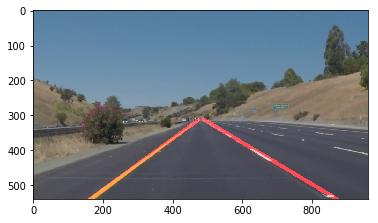

In [145]:
nFrames = 0
yellow_output = 'test_videos/modified_solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [194]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
avg_pos_slope = 0
avg_neg_slope = 0
nFrames = 0
challenge_output = 'test_videos/modified_challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,2)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

avg_neg_slope(before) =  0
mean_negative_slope =  -0.523668419015
nFrames =  1
avg_neg_slope =  -0.523668419015
highest =  [628, 401]
bottom =  [57.028008673126422, 700]
end-points =  628 401 57 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan
avg_pos_slope =  0
[MoviePy] >>>> Building video test_videos/modified_challenge.mp4
[MoviePy] Writing video test_videos/modified_challenge.mp4


  0%|          | 1/251 [00:00<00:31,  8.05it/s]

avg_neg_slope(before) =  -0.523668419015
mean_negative_slope =  -0.523668419015
nFrames =  2
avg_neg_slope =  -0.523668419015
highest =  [628, 401]
bottom =  [57.028008673126422, 700]
end-points =  628 401 57 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan
avg_pos_slope =  0
avg_neg_slope(before) =  -0.523668419015
mean_negative_slope =  -0.509339328952
nFrames =  3
avg_neg_slope =  -0.520086146499
highest =  [684, 419]
bottom =  [143.70489333076469, 700]
end-points =  684 419 143 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan
avg_pos_slope =  0


  1%|          | 2/251 [00:00<00:33,  7.53it/s]

avg_neg_slope(before) =  -0.520086146499
mean_negative_slope =  nan
nFrames =  4
avg_neg_slope =  -0.520086146499
highest =  [675, 415]
bottom =  [127.0138597838715, 700]
end-points =  675 415 127 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan
avg_pos_slope =  0


  1%|          | 3/251 [00:00<00:34,  7.11it/s]

avg_neg_slope(before) =  -0.520086146499
mean_negative_slope =  -0.571775361886
nFrames =  5
avg_neg_slope =  -0.52870101573
highest =  [683, 417]
bottom =  [147.72582503162675, 700]
end-points =  683 417 147 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan


  2%|▏         | 4/251 [00:00<00:36,  6.81it/s]

avg_pos_slope =  0
avg_neg_slope(before) =  -0.52870101573
mean_negative_slope =  -0.563127437045
nFrames =  6
avg_neg_slope =  -0.533619075918
highest =  [638, 421]
bottom =  [115.15512321227101, 700]
end-points =  638 421 115 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan
avg_pos_slope =  0


  2%|▏         | 5/251 [00:00<00:35,  6.92it/s]

avg_neg_slope(before) =  -0.533619075918
mean_negative_slope =  nan
nFrames =  7
avg_neg_slope =  -0.533619075918
highest =  [623, 407]
bottom =  [73.919179574177093, 700]
end-points =  623 407 73 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan
avg_pos_slope =  0


  2%|▏         | 6/251 [00:00<00:35,  6.82it/s]

avg_neg_slope(before) =  -0.533619075918
mean_negative_slope =  nan
nFrames =  8
avg_neg_slope =  -0.533619075918
highest =  [629, 406]
bottom =  [78.045183600027599, 700]
end-points =  629 406 78 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan
avg_pos_slope =  0


  3%|▎         | 7/251 [00:01<00:35,  6.87it/s]

avg_neg_slope(before) =  -0.533619075918
mean_negative_slope =  nan
nFrames =  9
avg_neg_slope =  -0.533619075918
highest =  [665, 408]
bottom =  [117.79317554832679, 700]
end-points =  665 408 117 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan


  3%|▎         | 8/251 [00:01<00:36,  6.73it/s]

avg_pos_slope =  0
avg_neg_slope(before) =  -0.533619075918
mean_negative_slope =  nan
nFrames =  10
avg_neg_slope =  -0.533619075918
highest =  [661, 407]
bottom =  [111.91917957417711, 700]
end-points =  661 407 111 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan


  4%|▎         | 9/251 [00:01<00:35,  6.76it/s]

avg_pos_slope =  0
avg_neg_slope(before) =  -0.533619075918
mean_negative_slope =  nan
nFrames =  11
avg_neg_slope =  -0.533619075918
highest =  [499, 540]
bottom =  [199.16064413606935, 700]
end-points =  499 540 199 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan
avg_pos_slope =  0


  4%|▍         | 10/251 [00:01<00:36,  6.54it/s]

avg_neg_slope(before) =  -0.533619075918
mean_negative_slope =  -0.507609953704
nFrames =  12
avg_neg_slope =  -0.531254610262
highest =  [656, 403]
bottom =  [96.946028019649958, 700]
end-points =  656 403 96 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan
avg_pos_slope =  0


  4%|▍         | 11/251 [00:01<00:33,  7.13it/s]

avg_neg_slope(before) =  -0.531254610262
mean_negative_slope =  -0.554455445545
nFrames =  13
avg_neg_slope =  -0.533363777106
highest =  [646, 438]
bottom =  [154.77803996826282, 700]
end-points =  646 438 154 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan
avg_pos_slope =  0


  5%|▍         | 12/251 [00:01<00:32,  7.41it/s]

avg_neg_slope(before) =  -0.533363777106
mean_negative_slope =  -0.565844903506
nFrames =  14
avg_neg_slope =  -0.536316606779
highest =  [653, 402]
bottom =  [97.358059710595981, 700]
end-points =  653 402 97 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan
avg_pos_slope =  0


  5%|▌         | 13/251 [00:01<00:31,  7.53it/s]

avg_neg_slope(before) =  -0.536316606779
mean_negative_slope =  nan
nFrames =  15
avg_neg_slope =  -0.536316606779
highest =  [651, 401]
bottom =  [93.493489441168549, 700]
end-points =  651 401 93 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan
avg_pos_slope =  0


  6%|▌         | 14/251 [00:02<00:32,  7.29it/s]

avg_neg_slope(before) =  -0.536316606779
mean_negative_slope =  nan
nFrames =  16
avg_neg_slope =  -0.536316606779
highest =  [666, 428]
bottom =  [158.8368867157117, 700]
end-points =  666 428 158 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan


  6%|▌         | 15/251 [00:02<00:33,  6.97it/s]

avg_pos_slope =  0
avg_neg_slope(before) =  -0.536316606779
mean_negative_slope =  nan
nFrames =  17
avg_neg_slope =  -0.536316606779
highest =  [621, 450]
bottom =  [154.85743264311739, 700]
end-points =  621 450 154 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan
avg_pos_slope =  0


  6%|▋         | 16/251 [00:02<00:34,  6.86it/s]

avg_neg_slope(before) =  -0.536316606779
mean_negative_slope =  nan
nFrames =  18
avg_neg_slope =  -0.536316606779
highest =  [673, 415]
bottom =  [141.5974732131541, 700]
end-points =  673 415 141 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan
avg_pos_slope =  0


  7%|▋         | 17/251 [00:02<00:34,  6.69it/s]

avg_neg_slope(before) =  -0.536316606779
mean_negative_slope =  nan
nFrames =  19
avg_neg_slope =  -0.536316606779
highest =  [0, 1000]
bottom =  [559.37108082825898, 700]
end-points =  0 1000 559 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan


  7%|▋         | 18/251 [00:02<00:35,  6.59it/s]

avg_pos_slope =  0
avg_neg_slope(before) =  -0.536316606779
mean_negative_slope =  -0.510895464282
nFrames =  20
avg_neg_slope =  -0.534005593825
highest =  [676, 416]
bottom =  [144.17036509671414, 700]
end-points =  676 416 144 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan
avg_pos_slope =  0


  8%|▊         | 20/251 [00:02<00:31,  7.29it/s]

avg_neg_slope(before) =  -0.534005593825
mean_negative_slope =  -0.533980582524
nFrames =  21
avg_neg_slope =  -0.53400332007
highest =  [676, 419]
bottom =  [149.78604319689197, 700]
end-points =  676 419 149 700
avg_pos_slope(before) =  0
mean_positive_slope =  nan
avg_pos_slope =  0
avg_neg_slope(before) =  -0.53400332007
mean_negative_slope =  -0.511278195489
nFrames =  22
avg_neg_slope =  -0.531937399653
highest =  [686, 419]
bottom =  [157.74235129348071, 700]
end-points =  686 419 157 700
avg_pos_slope(before) =  0
mean_positive_slope =  0.569053651866
avg_pos_slope =  0.569053651866
highest =  [640, 400]
bottom =  [1167.1910636478326, 700]
end points =  640 400 1167 700


  9%|▉         | 22/251 [00:03<00:29,  7.89it/s]

avg_neg_slope(before) =  -0.531937399653
mean_negative_slope =  -0.509615384615
nFrames =  23
avg_neg_slope =  -0.529908125559
highest =  [660, 431]
bottom =  [152.36483264682204, 700]
end-points =  660 431 152 700
avg_pos_slope(before) =  0.569053651866
mean_positive_slope =  nan
avg_pos_slope =  0.569053651866
highest =  [655, 421]
bottom =  [1145.2876891924841, 700]
end points =  655 421 1145 700
avg_neg_slope(before) =  -0.529908125559
mean_negative_slope =  nan
nFrames =  24
avg_neg_slope =  -0.529908125559
highest =  [608, 413]
bottom =  [66.396680184527639, 700]
end-points =  608 413 66 700
avg_pos_slope(before) =  0.569053651866
mean_positive_slope =  0.56346140703
avg_pos_slope =  0.568545265972
highest =  [649, 417]
bottom =  [1146.7615977792063, 700]
end points =  649 417 1146 700


 10%|▉         | 25/251 [00:03<00:26,  8.40it/s]

avg_neg_slope(before) =  -0.529908125559
mean_negative_slope =  nan
nFrames =  25
avg_neg_slope =  -0.529908125559
highest =  [0, 1000]
bottom =  [566.13587437157389, 700]
end-points =  0 1000 566 700
avg_pos_slope(before) =  0.568545265972
mean_positive_slope =  0.506833678315
avg_pos_slope =  0.562935121639
highest =  [635, 400]
bottom =  [1167.9210924454026, 700]
end points =  635 400 1167 700
avg_neg_slope(before) =  -0.529908125559
mean_negative_slope =  -0.579021791519
nFrames =  26
avg_neg_slope =  -0.534373004283
highest =  [342, 596]
bottom =  [147.37939011421477, 700]
end-points =  342 596 147 700
avg_pos_slope(before) =  0.562935121639
mean_positive_slope =  nan
avg_pos_slope =  0.562935121639
highest =  [639, 400]
bottom =  [1171.9210924454028, 700]
end points =  639 400 1171 700


 10%|█         | 26/251 [00:03<00:26,  8.35it/s]

avg_neg_slope(before) =  -0.534373004283
mean_negative_slope =  -0.563134928382
nFrames =  27
avg_neg_slope =  -0.536987724655
highest =  [677, 416]
bottom =  [148.12385076908154, 700]
end-points =  677 416 148 700
avg_pos_slope(before) =  0.562935121639
mean_positive_slope =  nan
avg_pos_slope =  0.562935121639
highest =  [632, 400]
bottom =  [1164.9210924454028, 700]
end points =  632 400 1164 700
avg_neg_slope(before) =  -0.536987724655
mean_negative_slope =  nan
nFrames =  28
avg_neg_slope =  -0.536987724655
highest =  [677, 423]
bottom =  [161.15953050364641, 700]
end-points =  677 423 161 700
avg_pos_slope(before) =  0.562935121639
mean_positive_slope =  nan
avg_pos_slope =  0.562935121639
highest =  [644, 401]
bottom =  [1175.1446888039179, 700]
end points =  644 401 1175 700


 12%|█▏        | 29/251 [00:03<00:27,  8.08it/s]

avg_neg_slope(before) =  -0.536987724655
mean_negative_slope =  -0.555425720313
nFrames =  29
avg_neg_slope =  -0.538663906079
highest =  [665, 418]
bottom =  [141.48246556404339, 700]
end-points =  665 418 141 700
avg_pos_slope(before) =  0.562935121639
mean_positive_slope =  0.654153954283
avg_pos_slope =  0.571227742789
highest =  [632, 402]
bottom =  [1153.6833456741767, 700]
end points =  632 402 1153 700
avg_neg_slope(before) =  -0.538663906079
mean_negative_slope =  nan
nFrames =  30
avg_neg_slope =  -0.538663906079
highest =  [681, 418]
bottom =  [157.48246556404328, 700]
end-points =  681 418 157 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [0, 1000]
bottom =  [-525.18457618205707, 700]
end points =  0 1000 -525 700


 12%|█▏        | 30/251 [00:04<00:27,  8.15it/s]

avg_neg_slope(before) =  -0.538663906079
mean_negative_slope =  -0.513513513514
nFrames =  31
avg_neg_slope =  -0.536377506755
highest =  [660, 416]
bottom =  [130.52216690006779, 700]
end-points =  660 416 130 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [0, 1000]
bottom =  [-525.18457618205707, 700]
end points =  0 1000 -525 700
avg_neg_slope(before) =  -0.536377506755
mean_negative_slope =  -0.532296373537
nFrames =  32
avg_neg_slope =  -0.536006494644
highest =  [683, 417]
bottom =  [155.02132282376721, 700]
end-points =  683 417 155 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [626, 402]
bottom =  [1147.6833456741767, 700]
end points =  626 402 1147 700


 13%|█▎        | 32/251 [00:04<00:26,  8.12it/s]

avg_neg_slope(before) =  -0.536006494644
mean_negative_slope =  -0.579960880196
nFrames =  33
avg_neg_slope =  -0.540002347876
highest =  [672, 425]
bottom =  [162.74295494882912, 700]
end-points =  672 425 162 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [628, 403]
bottom =  [1147.9327304202363, 700]
end points =  628 403 1147 700
avg_neg_slope(before) =  -0.540002347876
mean_negative_slope =  -0.788419695372
nFrames =  34
avg_neg_slope =  -0.562585743103
highest =  [680, 416]
bottom =  [175.18806069694094, 700]
end-points =  680 416 175 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [634, 402]
bottom =  [1155.6833456741767, 700]
end points =  634 402 1155 700


 14%|█▍        | 35/251 [00:04<00:25,  8.31it/s]

avg_neg_slope(before) =  -0.562585743103
mean_negative_slope =  -0.543746516997
nFrames =  35
avg_neg_slope =  -0.560873086184
highest =  [681, 419]
bottom =  [179.99539321495197, 700]
end-points =  681 419 179 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [638, 401]
bottom =  [1161.4339609281169, 700]
end points =  638 401 1161 700
avg_neg_slope(before) =  -0.560873086184
mean_negative_slope =  -0.55487804878
nFrames =  36
avg_neg_slope =  -0.560328082784
highest =  [678, 420]
bottom =  [178.29275954024598, 700]
end-points =  678 420 178 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [651, 402]
bottom =  [1172.6833456741767, 700]
end points =  651 402 1172 700


 14%|█▍        | 36/251 [00:04<00:27,  7.91it/s]

avg_neg_slope(before) =  -0.560328082784
mean_negative_slope =  -0.52002395412
nFrames =  37
avg_neg_slope =  -0.556664071087
highest =  [677, 425]
bottom =  [182.98572050292429, 700]
end-points =  677 425 182 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [637, 400]
bottom =  [1162.1845761820571, 700]
end points =  637 400 1162 700
avg_neg_slope(before) =  -0.556664071087
mean_negative_slope =  -0.51712932988
nFrames =  38
avg_neg_slope =  -0.553070003705
highest =  [686, 419]
bottom =  [177.92688426820135, 700]
end-points =  686 419 177 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [629, 402]
bottom =  [1150.683345674177, 700]
end points =  629 402 1150 700


 15%|█▌        | 38/251 [00:05<00:28,  7.50it/s]

avg_neg_slope(before) =  -0.553070003705
mean_negative_slope =  nan
nFrames =  39
avg_neg_slope =  -0.553070003705
highest =  [672, 430]
bottom =  [183.81586744631443, 700]
end-points =  672 430 183 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [632, 401]
bottom =  [1155.4339609281171, 700]
end points =  632 401 1155 700
avg_neg_slope(before) =  -0.553070003705
mean_negative_slope =  nan
nFrames =  40
avg_neg_slope = 

 16%|█▌        | 39/251 [00:05<00:31,  6.78it/s]

 -0.553070003705
highest =  [678, 415]
bottom =  [162.69452674888743, 700]
end-points =  678 415 162 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [648, 406]
bottom =  [1162.6808846584161, 700]
end points =  648 406 1162 700
avg_neg_slope(before) =  -0.553070003705
mean_negative_slope =  nan
nFrames =  41
avg_neg_slope =  -0.553070003705
highest =  [682, 419]
bottom =  [173.92688426820152, 700]
end-points =  682 419 173 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [630, 401]
bottom =  [1153.4339609281169, 700]
end points =  630 401 1153 700


 16%|█▋        | 41/251 [00:05<00:30,  6.85it/s]

avg_neg_slope(before) =  -0.553070003705
mean_negative_slope =  nan
nFrames =  42
avg_neg_slope =  -0.553070003705
highest =  [679, 420]
bottom =  [172.73497364803001, 700]
end-points =  679 420 172 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [627, 402]
bottom =  [1148.6833456741767, 700]
end points =  627 402 1148 700
avg_neg_slope(before) =  -0.553070003705
mean_negative_slope =  nan
nFrames =  43
avg_neg_slope =  -0.553070003705
highest =  [650, 409]
bottom =  [123.84599046991673, 700]
end-points =  650 409 123 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan


 17%|█▋        | 42/251 [00:05<00:30,  6.76it/s]

avg_pos_slope =  0.571227742789
highest =  [639, 400]
bottom =  [1164.1845761820571, 700]
end points =  639 400 1164 700
avg_neg_slope(before) =  -0.553070003705
mean_negative_slope =  nan
nFrames =  44
avg_neg_slope =  -0.553070003705
highest =  [670, 413]
bottom =  [151.07834798923059, 700]
end-points =  670 413 151 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [643, 408]
bottom =  [1154.1796541505355, 700]
end points =  643 408 1154 700


 18%|█▊        | 44/251 [00:06<00:31,  6.55it/s]

avg_neg_slope(before) =  -0.553070003705
mean_negative_slope =  nan
nFrames =  45
avg_neg_slope =  -0.553070003705
highest =  [645, 412]
bottom =  [124.27025860940223, 700]
end-points =  645 412 124 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [641, 407]
bottom =  [1153.9302694044759, 700]
end points =  641 407 1153 700
avg_neg_slope(before) =  -0.553070003705
mean_negative_slope =  nan
nFrames =  46
avg_neg_slope =  -0.553070003705
highest =  [0, 1000]
bottom =  [542.42681394853935, 700]
end-points =  0 1000 542 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan


 18%|█▊        | 46/251 [00:06<00:30,  6.68it/s]

avg_pos_slope =  0.571227742789
highest =  [640, 407]
bottom =  [1152.9302694044757, 700]
end points =  640 407 1152 700
avg_neg_slope(before) =  -0.553070003705
mean_negative_slope =  nan
nFrames =  47
avg_neg_slope =  -0.553070003705
highest =  [0, 1000]
bottom =  [542.42681394853935, 700]
end-points =  0 1000 542 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [640, 400]
bottom =  [1165.1845761820571, 700]
end points =  640 400 1165 700


 19%|█▊        | 47/251 [00:06<00:31,  6.55it/s]

avg_neg_slope(before) =  -0.553070003705
mean_negative_slope =  nan
nFrames =  48
avg_neg_slope =  -0.553070003705
highest =  [661, 427]
bottom =  [167.39159930682916, 700]
end-points =  661 427 167 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [634, 407]
bottom =  [1146.9302694044759, 700]
end points =  634 407 1146 700
avg_neg_slope(before) =  -0.553070003705
mean_negative_slope =  nan
nFrames =  49
avg_neg_slope =  -0.553070003705
highest =  [687, 420]
bottom =  [180.73497364802989, 700]
end-points =  687

 20%|█▉        | 49/251 [00:06<00:28,  6.99it/s]

 420 180 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [636, 407]
bottom =  [1148.9302694044757, 700]
end points =  636 407 1148 700
avg_neg_slope(before) =  -0.553070003705
mean_negative_slope =  -0.534008141311
nFrames =  50
avg_neg_slope =  -0.551337107123
highest =  [686, 420]
bottom =  [178.14374221805423, 700]
end-points =  686 420 178 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [634, 407]
bottom =  [1146.9302694044759, 700]
end points =  634 407 1146 700


 20%|█▉        | 50/251 [00:06<00:28,  7.17it/s]

avg_neg_slope(before) =  -0.551337107123
mean_negative_slope =  -0.547757094669
nFrames =  51
avg_neg_slope =  -0.551011651446
highest =  [636, 402]
bottom =  [95.176590516539335, 700]
end-points =  636 402 95 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [637, 403]
bottom =  [1156.9327304202366, 700]
end points =  637 403 1156 700
avg_neg_slope(before) =  -0.551011651446
mean_negative_slope =  -0.574271790588
nFrames =  52
avg_neg_slope =  -0.55312620955
highest =  [677, 417]
bottom =  [165.36270074696341, 700]
end-points =  677 417 165 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [636, 405]
bottom =  [1152.431499912356, 700]
end points =  636 405 1152 700


 21%|██        | 52/251 [00:07<00:29,  6.64it/s]

avg_neg_slope(before) =  -0.55312620955
mean_negative_slope =  nan
nFrames =  53
avg_neg_slope =  -0.55312620955
highest =  [675, 413]
bottom =  [156.13107814268025, 700]
end-points =  675 413 156 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [630, 408]
bottom =  [1141.1796541505355, 700]
end points =  630 408 1141 700
avg_neg_slope(before) =  -0.55312620955
mean_negative_slope =  nan
nFrames =  54
avg_neg_slope = 

 21%|██        | 53/251 [00:07<00:30,  6.44it/s]

 -0.55312620955
highest =  [0, 1000]
bottom =  [542.37169532124028, 700]
end-points =  0 1000 542 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [632, 404]
bottom =  [1150.1821151662964, 700]
end points =  632 404 1150 700
avg_neg_slope(before) =  -0.55312620955
mean_negative_slope =  nan
nFrames =  55
avg_neg_slope =  -0.55312620955
highest =  [659, 407]
bottom =  [129.2836442362553, 700]
end-points =  659 407 129 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [630, 401]
bottom =  [1153.4339609281169, 700]
end points =  630 401 1153 700


 22%|██▏       | 55/251 [00:07<00:31,  6.22it/s]

avg_neg_slope(before) =  -0.55312620955
mean_negative_slope =  nan
nFrames =  56
avg_neg_slope =  -0.55312620955
highest =  [661, 411]
bottom =  [138.51526684053863, 700]
end-points =  661 411 138 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [625, 408]
bottom =  [1136.1796541505355, 700]
end points =  625 408 1136 700
avg_neg_slope(before) =  -0.55312620955
mean_negative_slope =  nan
nFrames =  57


 22%|██▏       | 56/251 [00:07<00:32,  6.03it/s]

avg_neg_slope =  -0.55312620955
highest =  [657, 405]
bottom =  [123.66783293411353, 700]
end-points =  657 405 123 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [654, 410]
bottom =  [1161.6784236426552, 700]
end points =  654 410 1161 700
avg_neg_slope(before) =  -0.55312620955
mean_negative_slope =  -0.5692650813
nFrames =  58
avg_neg_slope =  -0.554593379709
highest =  [652, 411]
bottom =  [130.89749395885872, 700]
end-points =  652 411 130 700
avg_pos_slope(before) =  0.571227742789
mean_positive_slope =  nan
avg_pos_slope =  0.571227742789
highest =  [627, 406]
bottom =  [1141.6808846584161, 700]
end points =  627 406 1141 700


 23%|██▎       | 57/251 [00:07<00:29,  6.54it/s]

In [197]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))